In [33]:
import yfinance as yf
import pandas as pd
import json
import numpy as np
from datetime import datetime, datetime, timedelta
from statsmodels.regression.linear_model import OLS
from scipy import stats
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from itertools import combinations

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm

In [34]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['10%']
    if (pvalue < 0.10) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

def kpss_test(data):
    result = kpss(data)
    labels = ['KPSS Test Statistic','p-value','Orders of Integration','Confidence Interval:Crit Value']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is non-stationary")
    else:
        print("Weak evidence against null hypothesis, time series may be stationary")

In [35]:
import os
# Path for 'data' folder
# Create a data folder that is in the upper level directory
# e.g. 'C:\Users\user\QF621\data'

folder_path = 'data/commods/'
# Check if the folder doesn't already exist
if not os.path.exists(folder_path):
    # Create the 'data' folder
    os.makedirs(folder_path)
    print("Folder 'data' created successfully.")
else:
    print("Folder 'data' already exists.")

DATA_FOLDER = 'data/commods/'

Folder 'data' already exists.


## 1. Data

In [36]:
etf_metals = ['GLD', 'SLV', 'IAU', 'GLDM', 'SGOL', 'PPLT', 'BAR', 'GLTR', 'OUNZ', 'AAAU', 'DBP', 'IGLD',
              'GLDI', 'IAUF', 'PLTM', 'BGLD', 'PSLV', 'DBB', 'PALL', 'SIVR', 'PPLT', 'URA', 'SGOL', 'CPER']
etf_energy = ['UNG', 'USO', 'DBO', 'OILK', 'DBE', 'BNO', 'UGA', 'DBE', 'USL', 'UNL']
etf_agri = ['DBA', 'CORN', 'WEAT', 'SOYB', 'TAGS', 'CANE', 'OAIA', 'KROP', 'TILL']

fut_metals = ['PL=F', 'PA=F', 'GC=F', 'SI=F', 'HG=F']
fut_energy = ['CL=F', 'NG=F', 'HO=F', 'RB=F', 'BZ=F']
fut_agri = ['ZW=F', 'ZC=F', 'ZL=F', 'ZS=F', 'ZO=F', 'ZR=F', 'KE=F']

# Date range
start_date = '2019-05-22'
end_date = '2024-05-23'

etf_metals_data = pd.DataFrame
etf_metals_data = yf.download(etf_metals, start=start_date, end=end_date)
etf_metals_data.drop(columns = ['Volume', 'Close', 'High', 'Low', 'Open'], inplace=True)
etf_metals_data = etf_metals_data.loc[:, ('Adj Close')]

etf_energy_data = pd.DataFrame
etf_energy_data = yf.download(etf_energy, start=start_date, end=end_date)
etf_energy_data.drop(columns = ['Volume', 'Close', 'High', 'Low', 'Open'], inplace=True)
etf_energy_data = etf_energy_data.loc[:, ('Adj Close')]

etf_agri_data = pd.DataFrame
etf_agri_data = yf.download(etf_agri, start=start_date, end=end_date)
etf_agri_data.drop(columns = ['Volume', 'Close', 'High', 'Low', 'Open'], inplace=True)
etf_agri_data = etf_agri_data.loc[:, ('Adj Close')]


[*********************100%***********************]  22 of 22 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed


In [37]:
fut_metals_data = yf.download(fut_metals, start=start_date, end=end_date)
fut_metals_data.drop(columns = ['Volume', 'Close', 'High', 'Low', 'Open'], inplace=True)
fut_metals_data = fut_metals_data.loc[:, ('Adj Close')]

fut_energy_data = yf.download(fut_energy, start=start_date, end=end_date)
fut_energy_data.drop(columns = ['Volume', 'Close', 'High', 'Low', 'Open'], inplace=True)
fut_energy_data = fut_energy_data.loc[:, ('Adj Close')]

fut_agri_data = yf.download(fut_agri, start=start_date, end=end_date)
fut_agri_data.drop(columns = ['Volume', 'Close', 'High', 'Low', 'Open'], inplace=True)
fut_agri_data = fut_agri_data.loc[:, ('Adj Close')]

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  7 of 7 completed


### We use this equation in order to match the Notionals of each futures contract. This is to ensure the pairs spread is of a 1:1 ratio

$$
\text{Futures Notional Value} = \text{Number of units} \times \text{Price per unit}
$$
$$
\text{/GC} = \text{100 troy ounces} \times \text{\$100 per ounce}
$$

In [38]:
fut_metals_data['GC=F'] = fut_metals_data['GC=F'] * 100
fut_metals_data['PL=F'] = fut_metals_data['PL=F'] * 50
fut_metals_data['PA=F'] = fut_metals_data['PA=F'] * 50
fut_metals_data['SI=F'] = fut_metals_data['SI=F'] * 5000
fut_metals_data['HG=F'] = fut_metals_data['HG=F'] * 25000

fut_energy_data['CL=F'] = fut_energy_data['CL=F'] * 1000
fut_energy_data['NG=F'] = fut_energy_data['NG=F'] * 10000
fut_energy_data['HO=F'] = fut_energy_data['HO=F'] * 42000
fut_energy_data['RB=F'] = fut_energy_data['RB=F'] * 42000
fut_energy_data['BZ=F'] = fut_energy_data['BZ=F'] * 1000

fut_agri_data['ZW=F'] = fut_agri_data['ZW=F'] * 5000
fut_agri_data['ZC=F'] = fut_agri_data['ZC=F'] * 5000
fut_agri_data['ZL=F'] = fut_agri_data['ZL=F'] * 60000
fut_agri_data['ZS=F'] = fut_agri_data['ZS=F'] * 5000
fut_agri_data['ZO=F'] = fut_agri_data['ZO=F'] * 5000
fut_agri_data['ZR=F'] = fut_agri_data['ZR=F'] * 2000
fut_agri_data['KE=F'] = fut_agri_data['KE=F'] * 5000

In [39]:
energy_data = pd.concat([fut_energy_data, etf_energy_data], axis=1)
metals_data = pd.concat([fut_metals_data, etf_metals_data], axis=1)
agri_data = pd.concat([fut_agri_data, etf_agri_data], axis=1)

In [40]:
metals_data.isna().mean() * 100

Ticker
GC=F     0.079302
HG=F     0.000000
PA=F     0.079302
PL=F     0.079302
SI=F     0.079302
AAAU     0.079302
BAR      0.079302
BGLD    33.386201
CPER     0.079302
DBB      0.079302
DBP      0.079302
GLD      0.079302
GLDI     0.079302
GLDM     0.079302
GLTR     0.079302
IAU      0.079302
IAUF     0.079302
IGLD    35.685964
OUNZ     0.079302
PALL     0.079302
PLTM     0.079302
PPLT     0.079302
PSLV     0.079302
SGOL     0.079302
SIVR     0.079302
SLV      0.079302
URA      0.079302
dtype: float64

In [41]:
def remove_null(df, threshold):
    missing_percentage = df.isnull().mean() * 100
    columns_to_drop = missing_percentage[missing_percentage > threshold].index
    df.drop(columns=columns_to_drop, inplace=True)
    return df
    
metals_data = remove_null(metals_data, 10)
energy_data = remove_null(energy_data, 10)
agri_data = remove_null(agri_data, 10)

In [42]:
agri_data.dropna(inplace=True)

In [43]:
metals_data

Ticker               GC=F           HG=F          PA=F          PL=F  \
Date                                                                   
2019-05-22  127359.997559   67150.002718  65909.997559  40139.999390   
2019-05-23  128480.004883   67162.501812  65625.000000  39860.000610   
2019-05-24  128300.000000   67662.501335  66520.001221  40029.998779   
2019-05-28  127650.000000   67587.500811  67209.997559  39750.000000   
2019-05-29  128059.997559   66812.497377  67665.002441  39479.998779   
...                   ...            ...           ...           ...   
2024-05-16  238000.000000  122300.004959  49875.000000  53270.001221   
2024-05-17  241219.995117  126425.004005  50495.001221  54229.998779   
2024-05-20  243389.990234  127187.502384  51534.997559  52984.997559   
2024-05-21  242169.995117  127974.998951  51470.001221  52834.997559   
2024-05-22  238919.995117  121687.495708  50145.001221  52204.998779   

Ticker               SI=F       AAAU        BAR       CPER        DBB  \
Date                                                                    
2019-05-22   72069.997787  12.720000  12.700000  16.730000  13.940142   
2019-05-23   72884.998322  12.820000  12.810000  16.790001  13.976350   
2019-05-24   72600.002289  12.830000  12.810000  16.910000  14.094026   
2019-05-28   71405.000687  12.780000  12.760000  16.840000  14.094026   
2019-05-29   71859.998703  12.780000  12.760000  16.670000  14.003506   
...                   ...        ...        ...        ...        ...   
2024-05-16  148325.004578  23.540001  23.490000  30.010000  20.840000   
2024-05-17  155235.004425  23.920000  23.870001  31.190001  21.340000   
2024-05-20  161025.009155  24.020000  23.980000  31.330000  21.629999   
2024-05-21  159340.000153  23.990000  23.940001  31.379999  21.639999   
2024-05-22  156475.000381  23.559999  23.520000  29.559999  21.090000   

Ticker            DBP  ...       IAUF       OUNZ        PALL    PLTM  \
Date                   ...                                             
2019-05-22  33.264637  ...  35.656773  12.480000  124.400002   8.040   
2019-05-23  33.546616  ...  35.928329  12.579000  123.720001   7.950   
2019-05-24  33.537216  ...  35.952652  12.591000  126.250000   7.980   
2019-05-28  33.339832  ...  35.803722  12.540000  126.790001   7.960   
2019-05-29  33.358631  ...  35.826790  12.550000  126.809998   7.885   
...               ...  ...        ...        ...         ...     ...   
2024-05-16  58.570000  ...  62.529301  22.980000   91.279999  10.320   
2024-05-17  60.099998  ...  63.437599  23.360001   93.010002  10.540   
2024-05-20  60.459999  ...  63.785599  23.459999   95.480003  10.220   
2024-05-21  60.459999  ...  63.724098  23.420000   94.800003  10.252   
2024-05-22  59.110001  ...  62.520302  22.980000   91.760002  10.090   

Ticker           PPLT   PSLV       SGOL       SIVR        SLV        URA  
Date                                                                      
2019-05-22  76.050003   5.19  12.272000  14.040000  13.540000   9.870512  
2019-05-23  75.570000   5.23  12.370000  14.170000  13.680000   9.742873  
2019-05-24  76.120003   5.22  12.384000  14.140000  13.650000   9.751384  
2019-05-28  75.529999   5.15  12.333000  13.950000  13.460000   9.785420  
2019-05-29  75.010002   5.19  12.340000  14.030000  13.520000   9.674801  
...               ...    ...        ...        ...        ...        ...  
2024-05-16  97.610001   9.97  22.719999  28.320000  27.059999  31.492922  
2024-05-17  99.800003  10.54  23.100000  30.139999  28.790001  32.621952  
2024-05-20  96.690002  10.68  23.190001  30.330000  28.980000  33.181469  
2024-05-21  96.940002  10.76  23.150000  30.629999  29.270000  33.091545  
2024-05-22  95.400002  10.34  22.730000  29.520000  28.219999  31.972509  

[1261 rows x 25 columns]

In [44]:
metals_data.ffill(inplace=True)
energy_data.ffill(inplace=True)
agri_data.ffill(inplace=True)

In-sample/Out-Sample split

In [45]:
def is_os_split(data, ratio):
    split_point = int(len(data) * ratio)
    in_sample = data[:split_point]
    out_sample = data[split_point:]
    return in_sample, out_sample

# Split into in-sample and out-sample
energy_data_is, energy_data_os = is_os_split(energy_data, 0.8)
agri_data_is, agri_data_os = is_os_split(agri_data, 0.8)
metals_data_is, metals_data_os = is_os_split(metals_data, 0.8)

Time series graphs

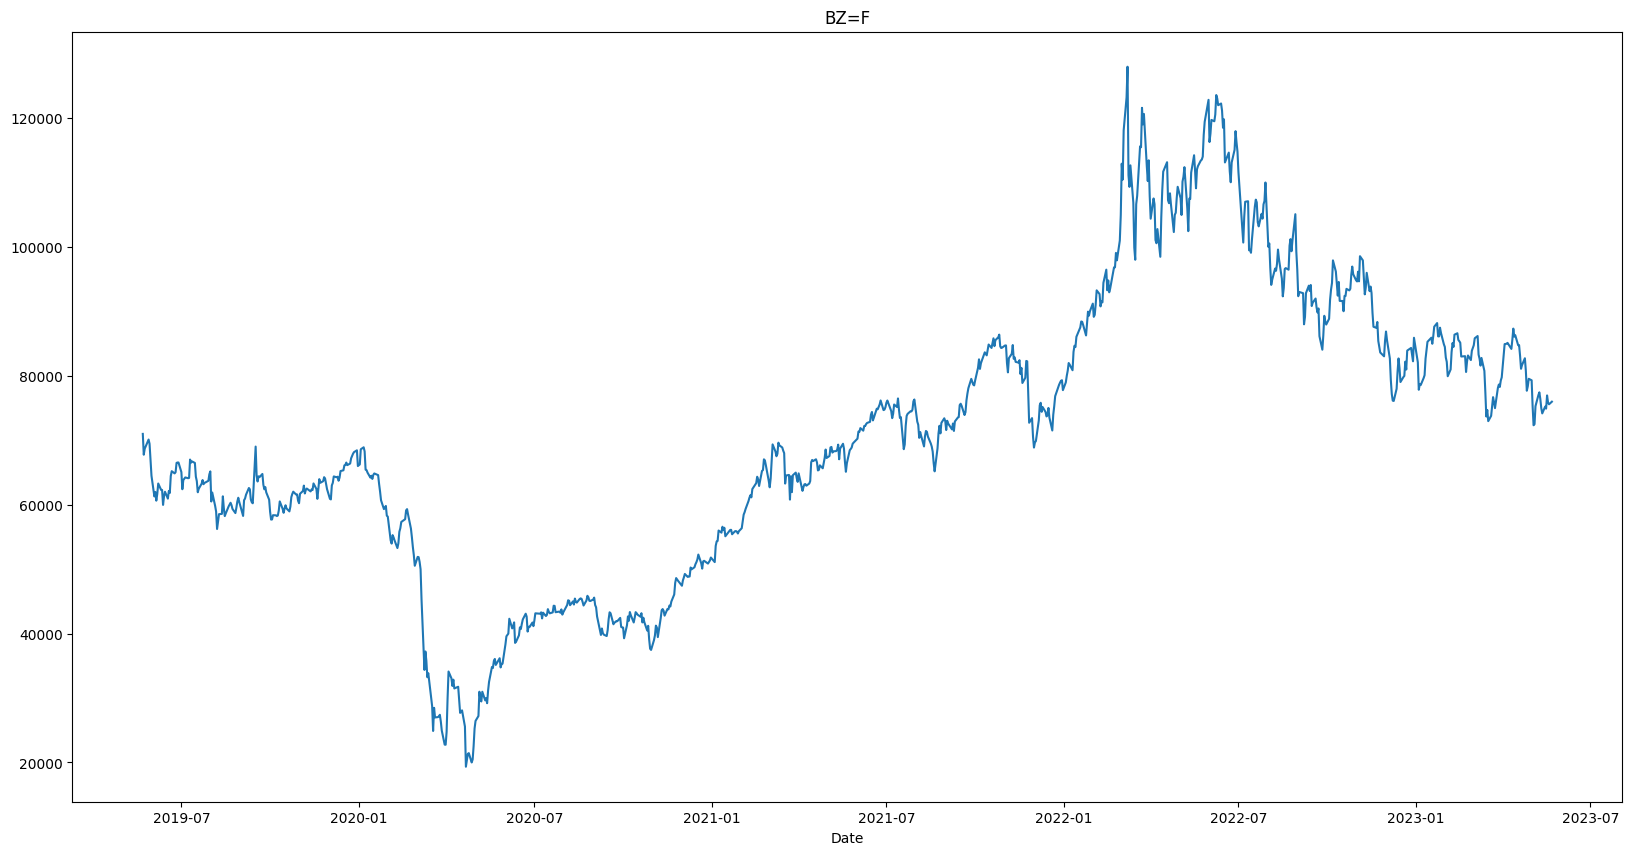

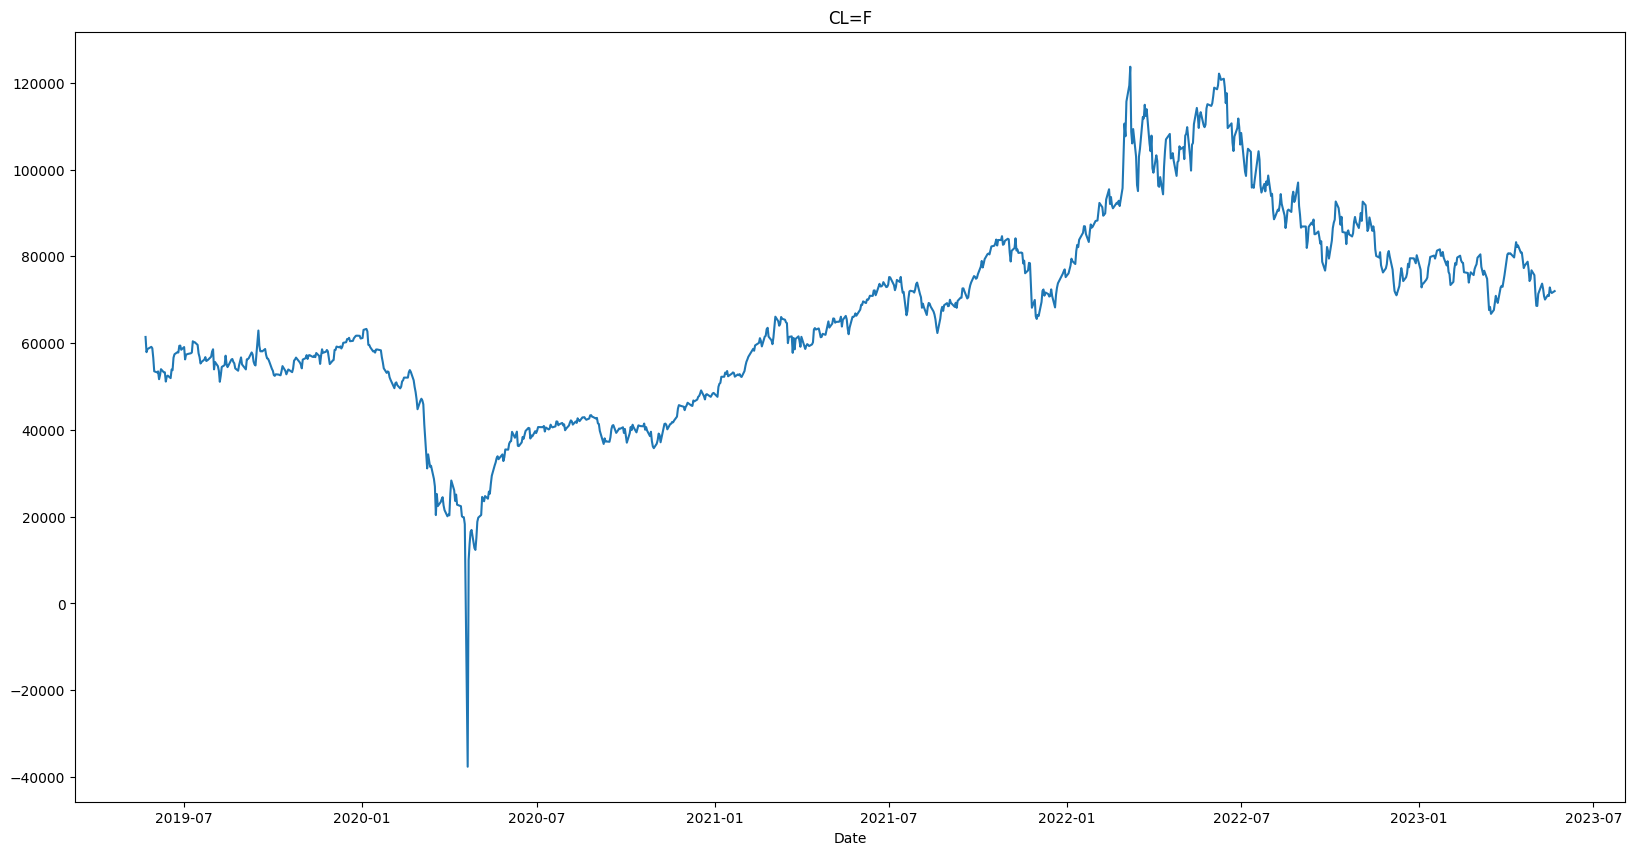

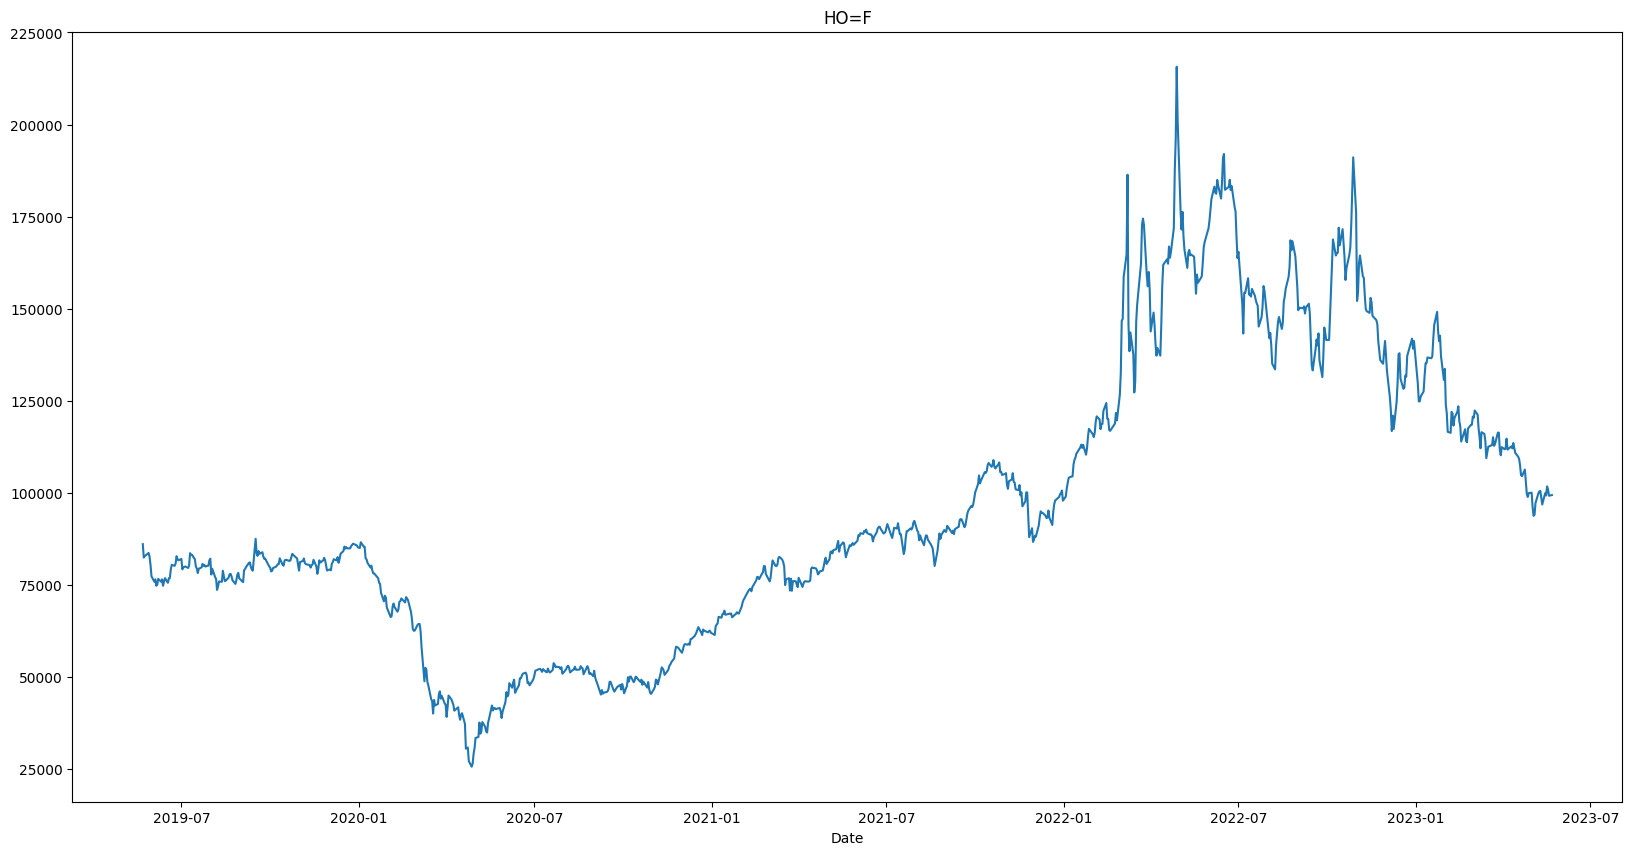

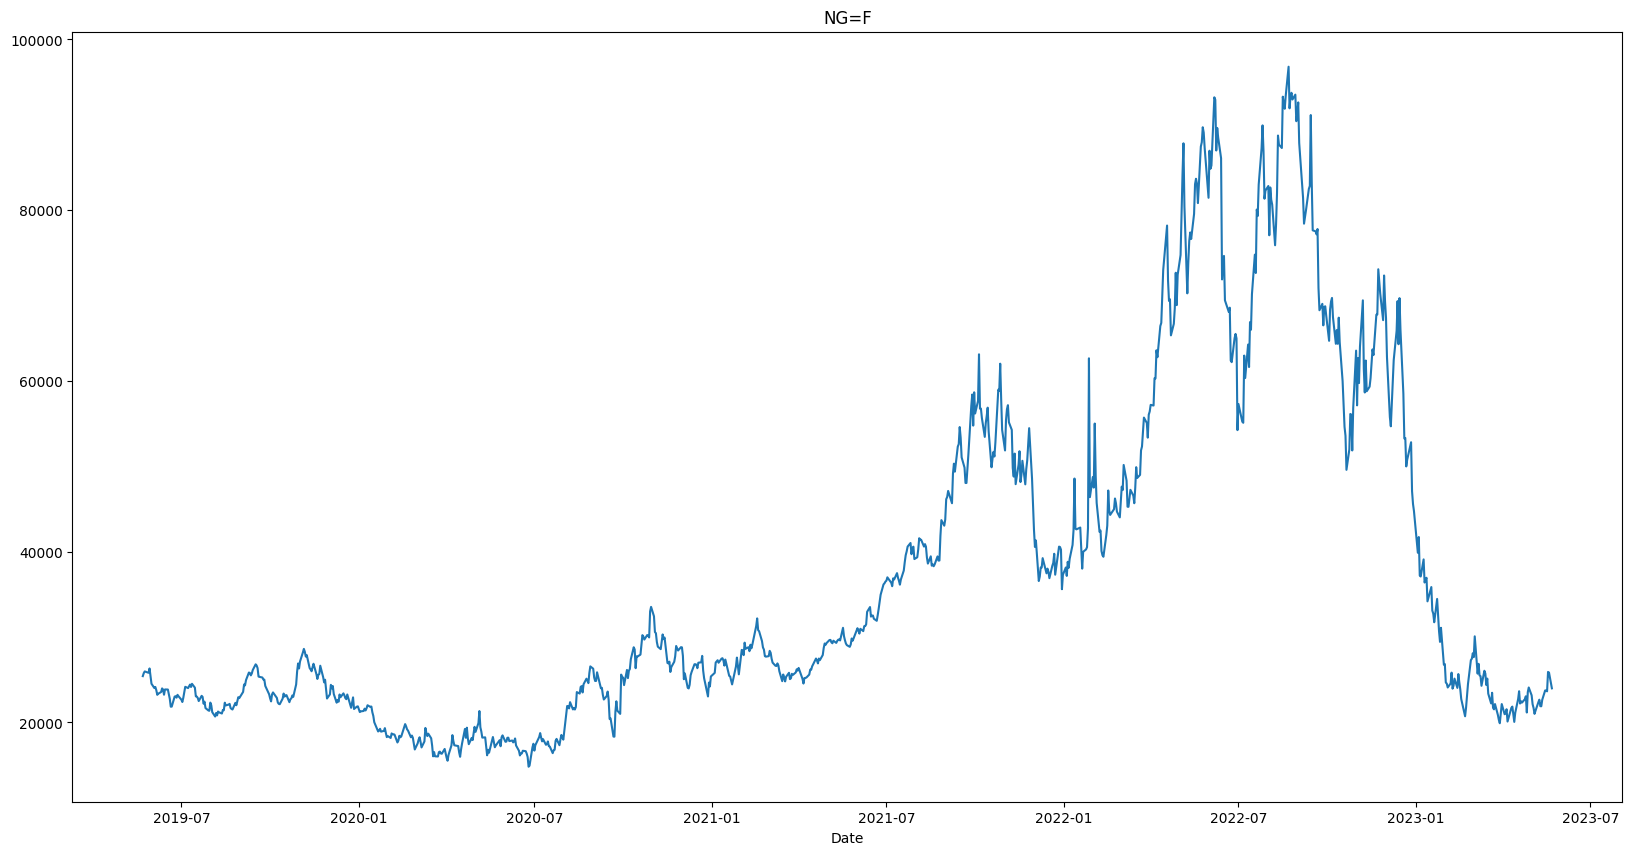

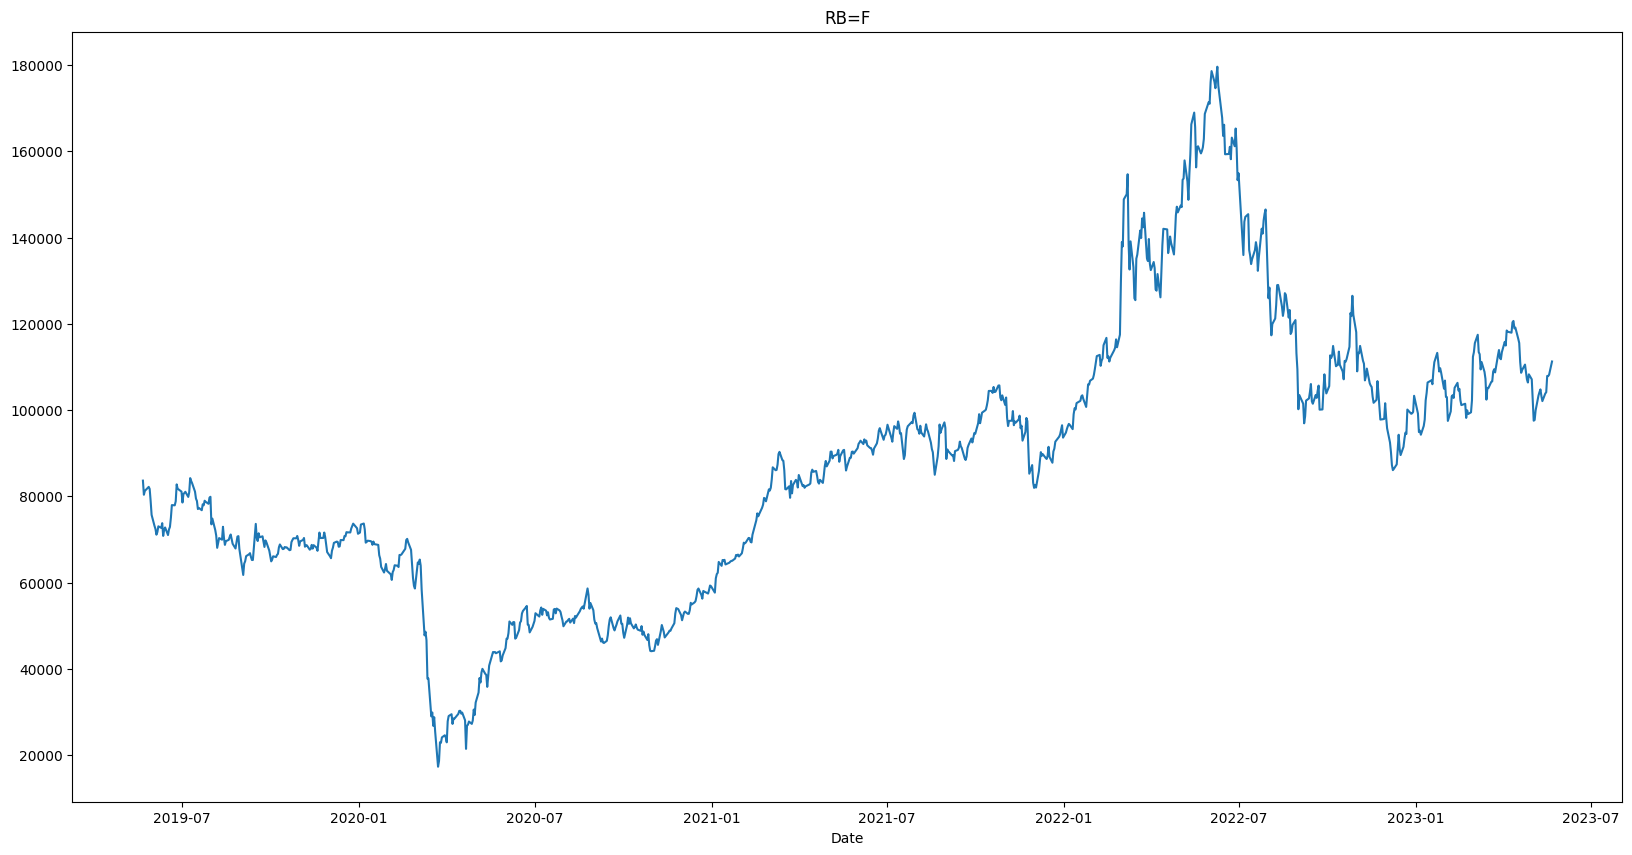

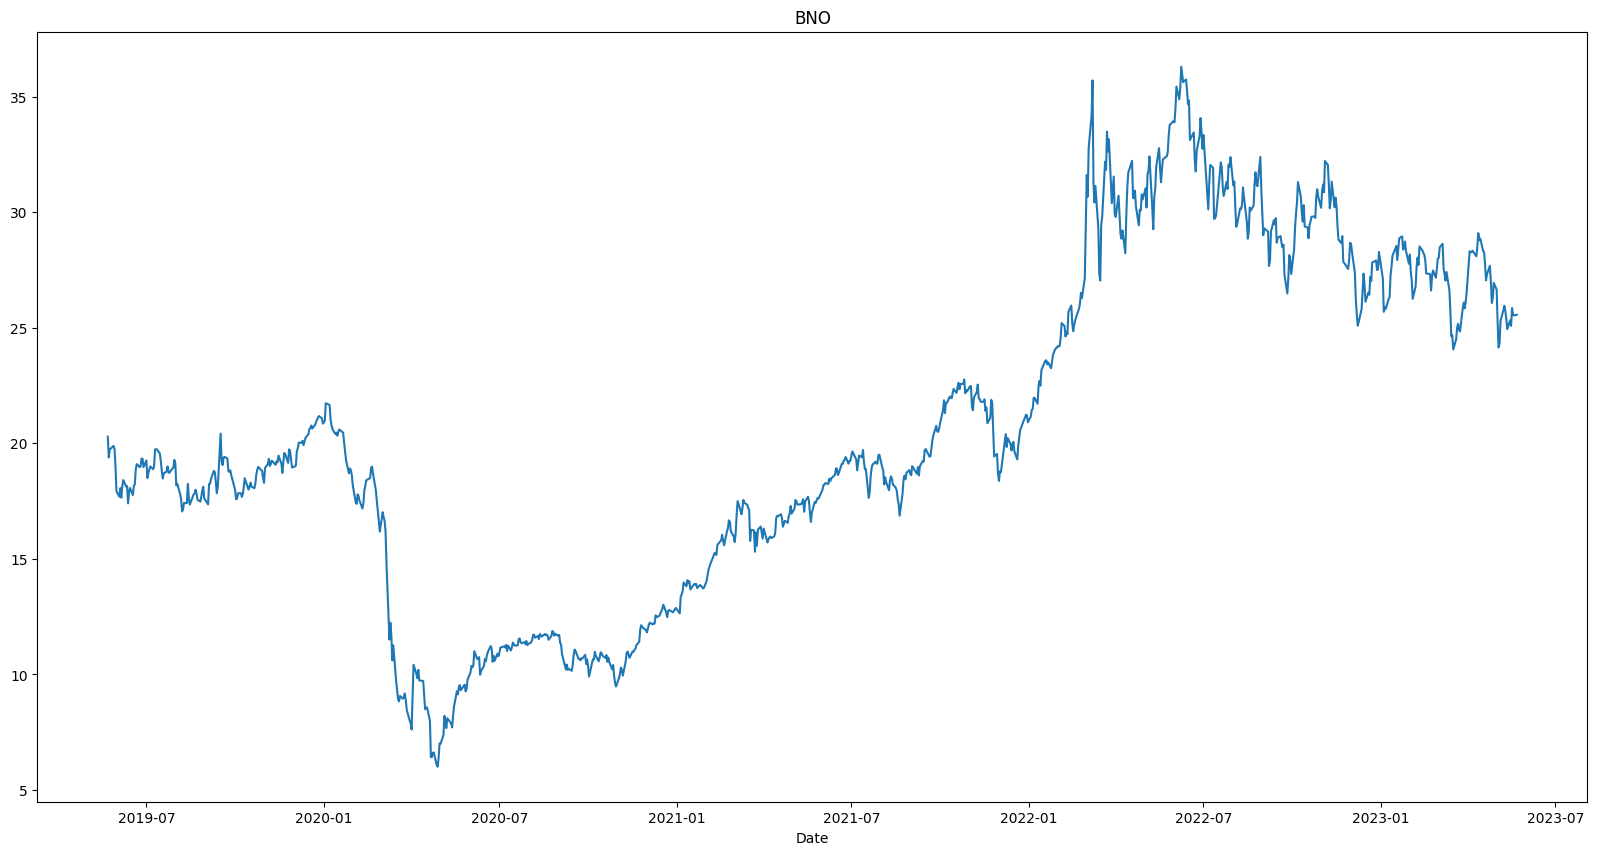

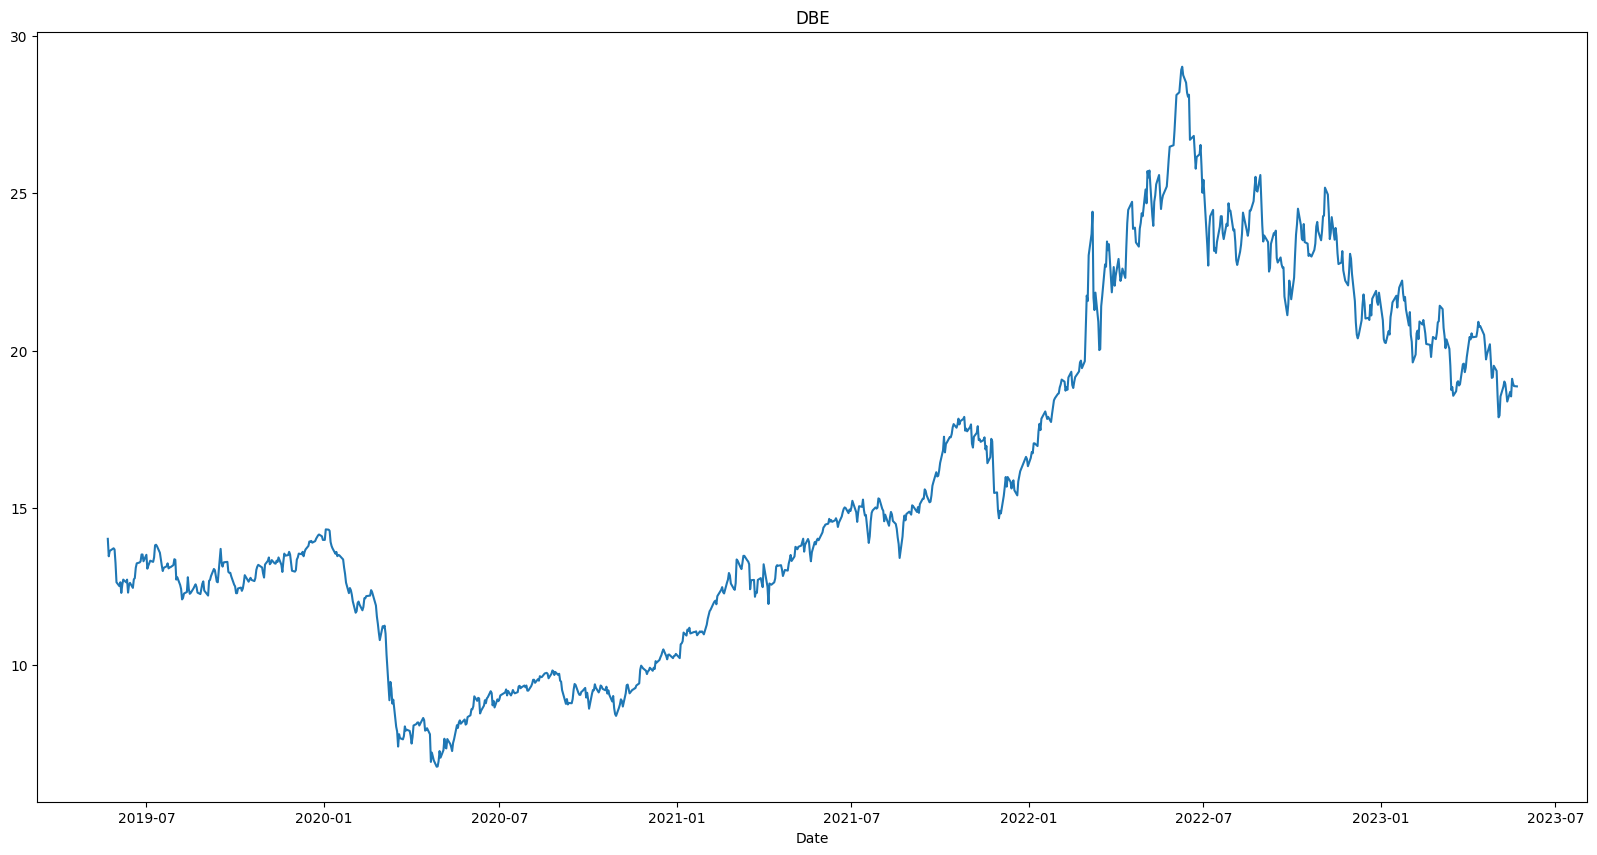

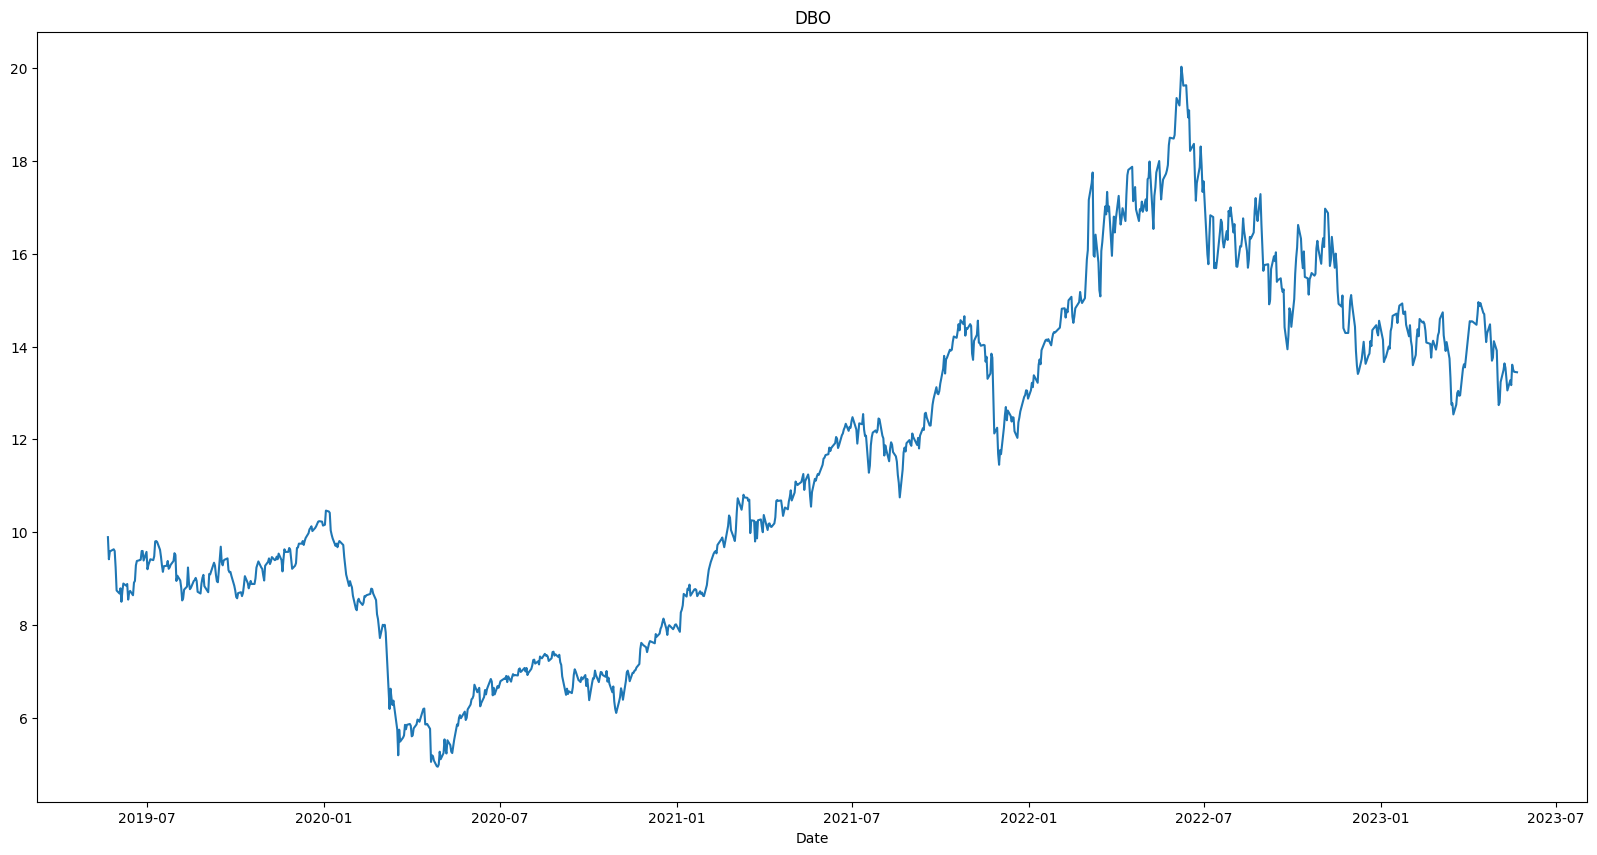

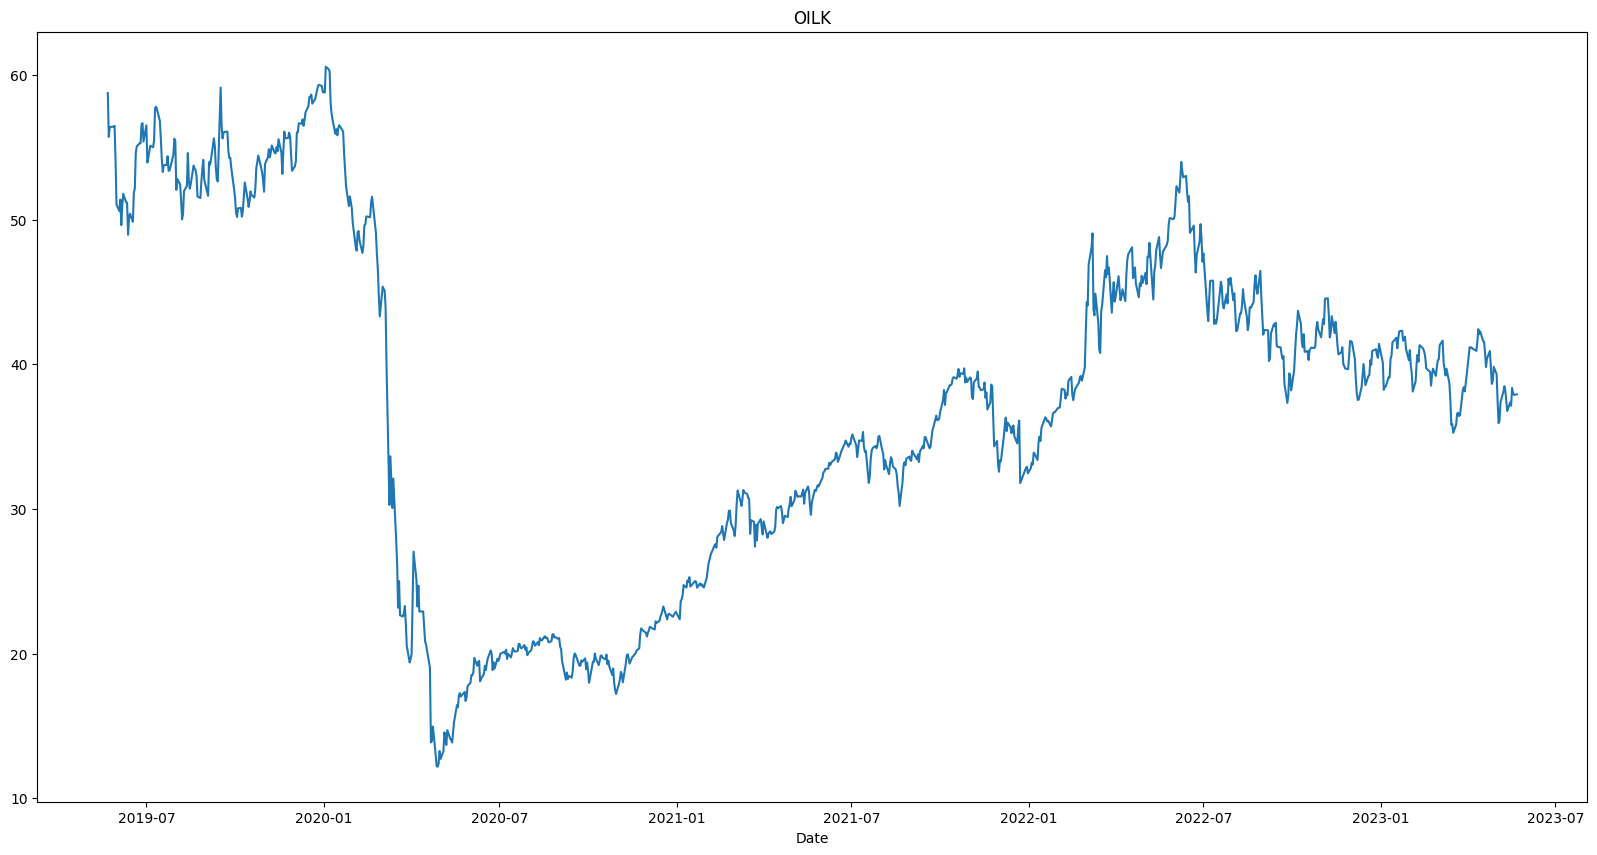

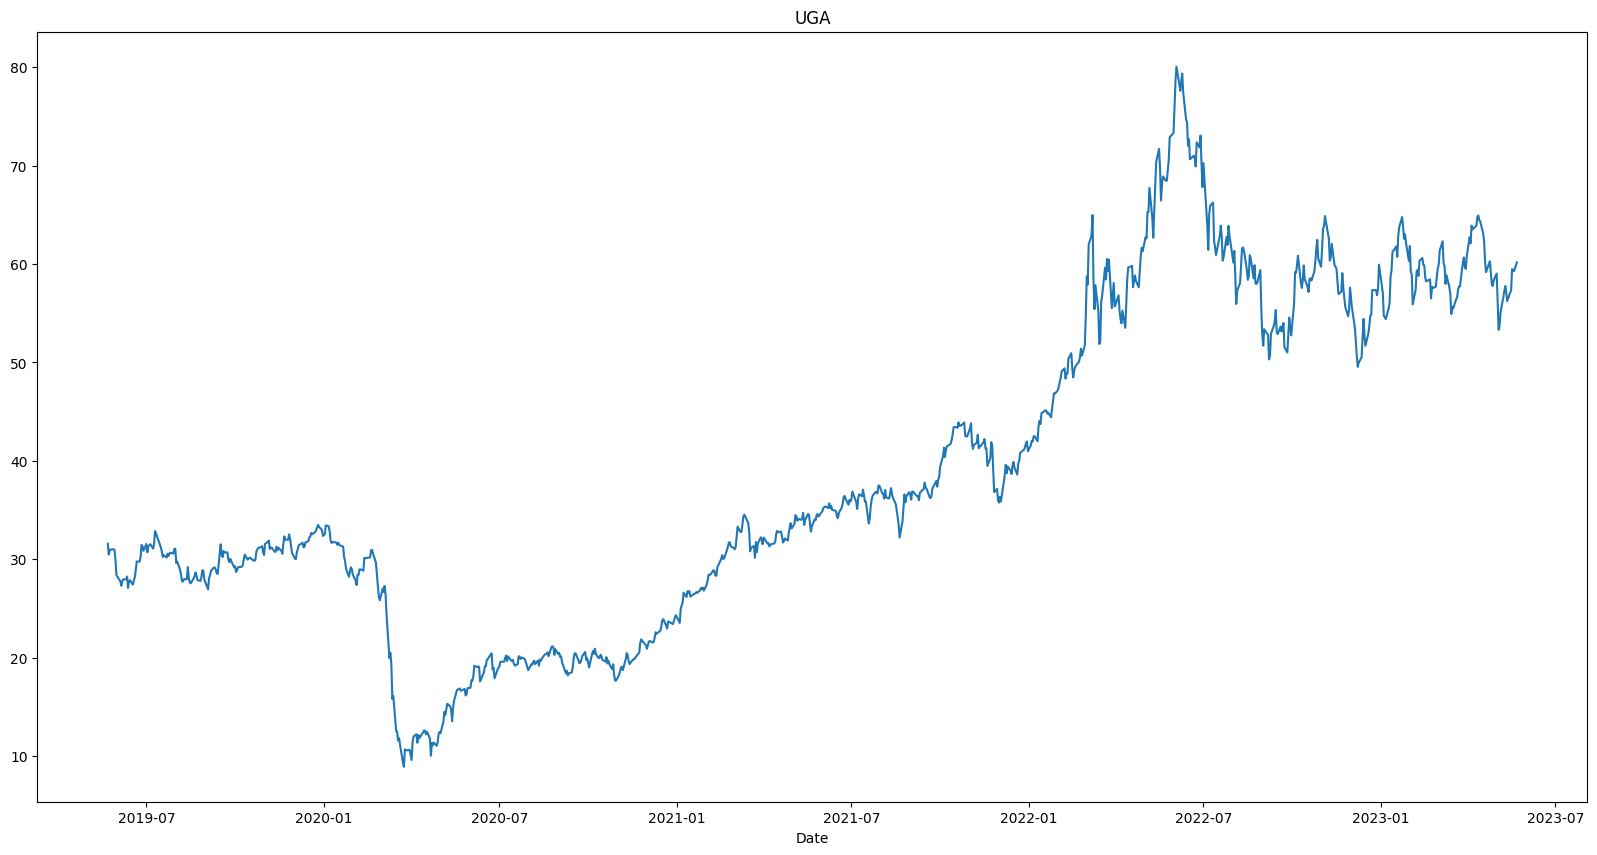

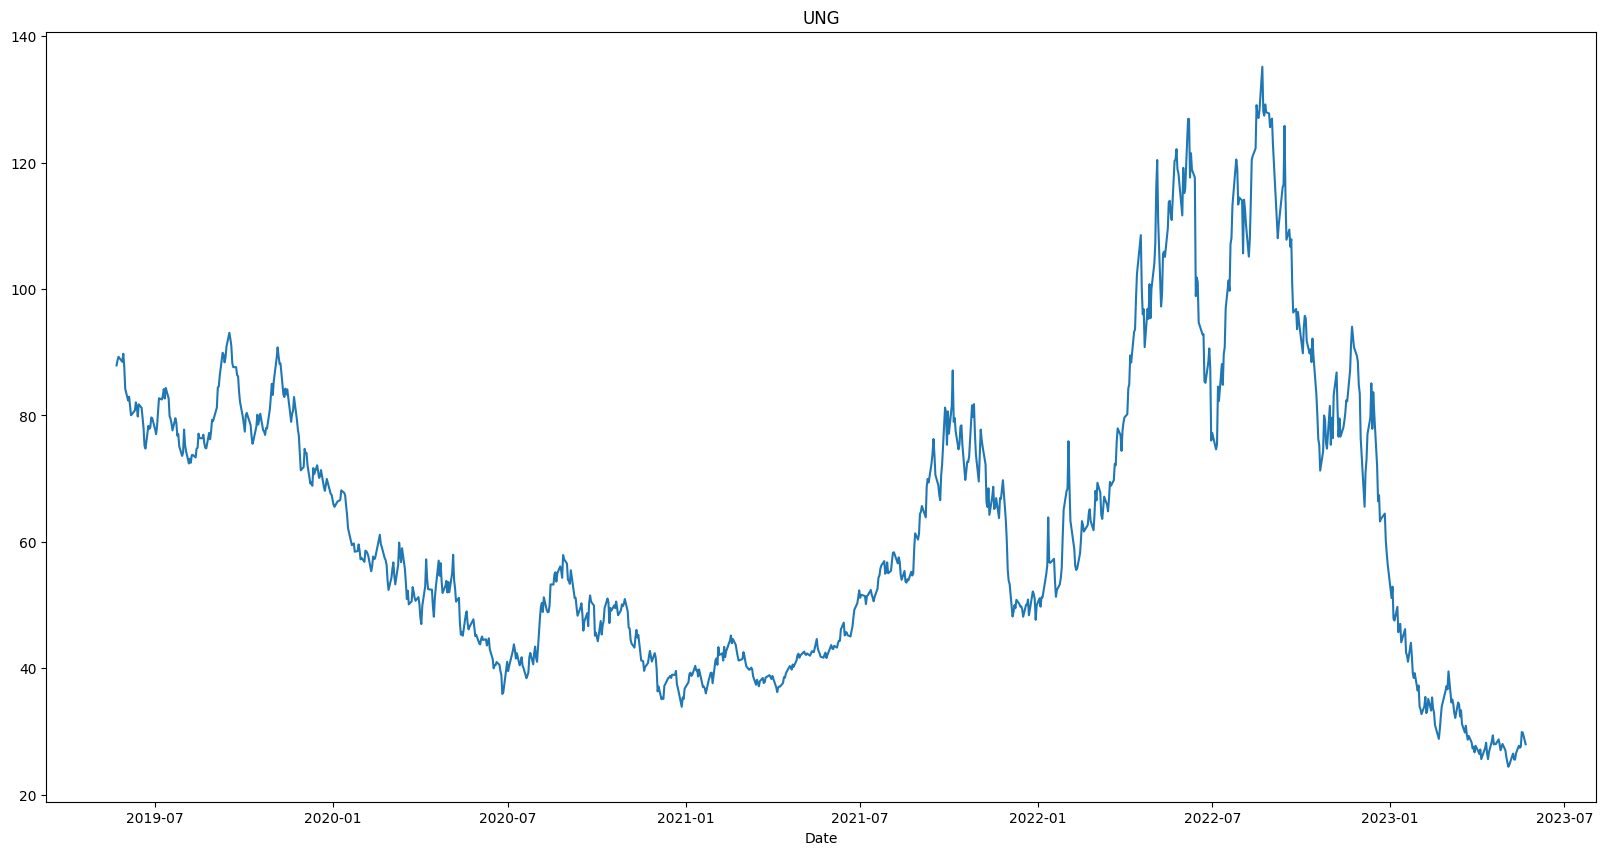

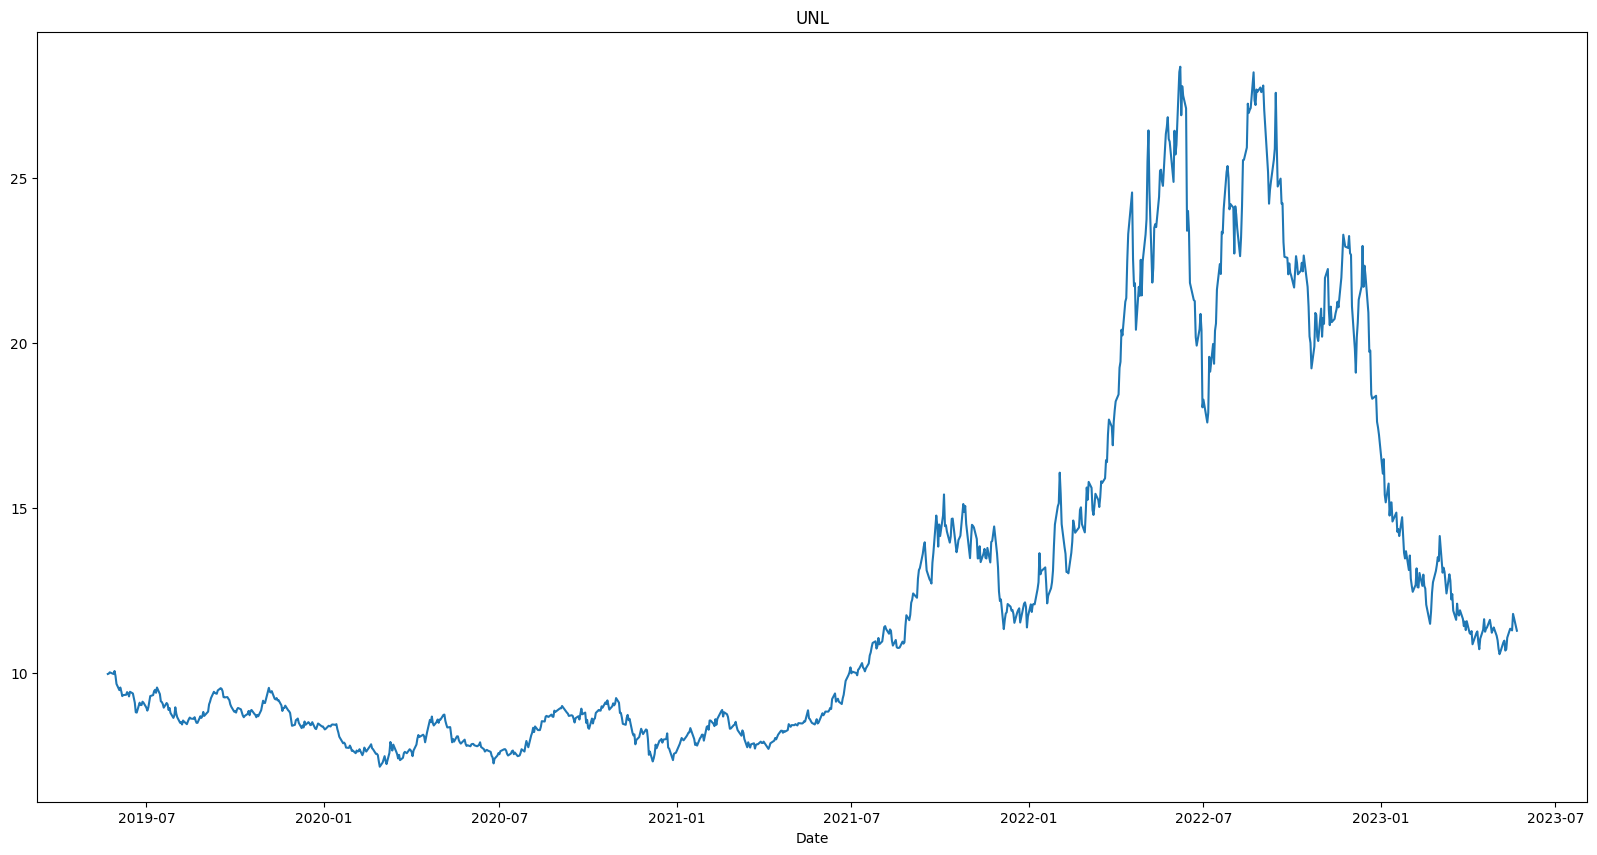

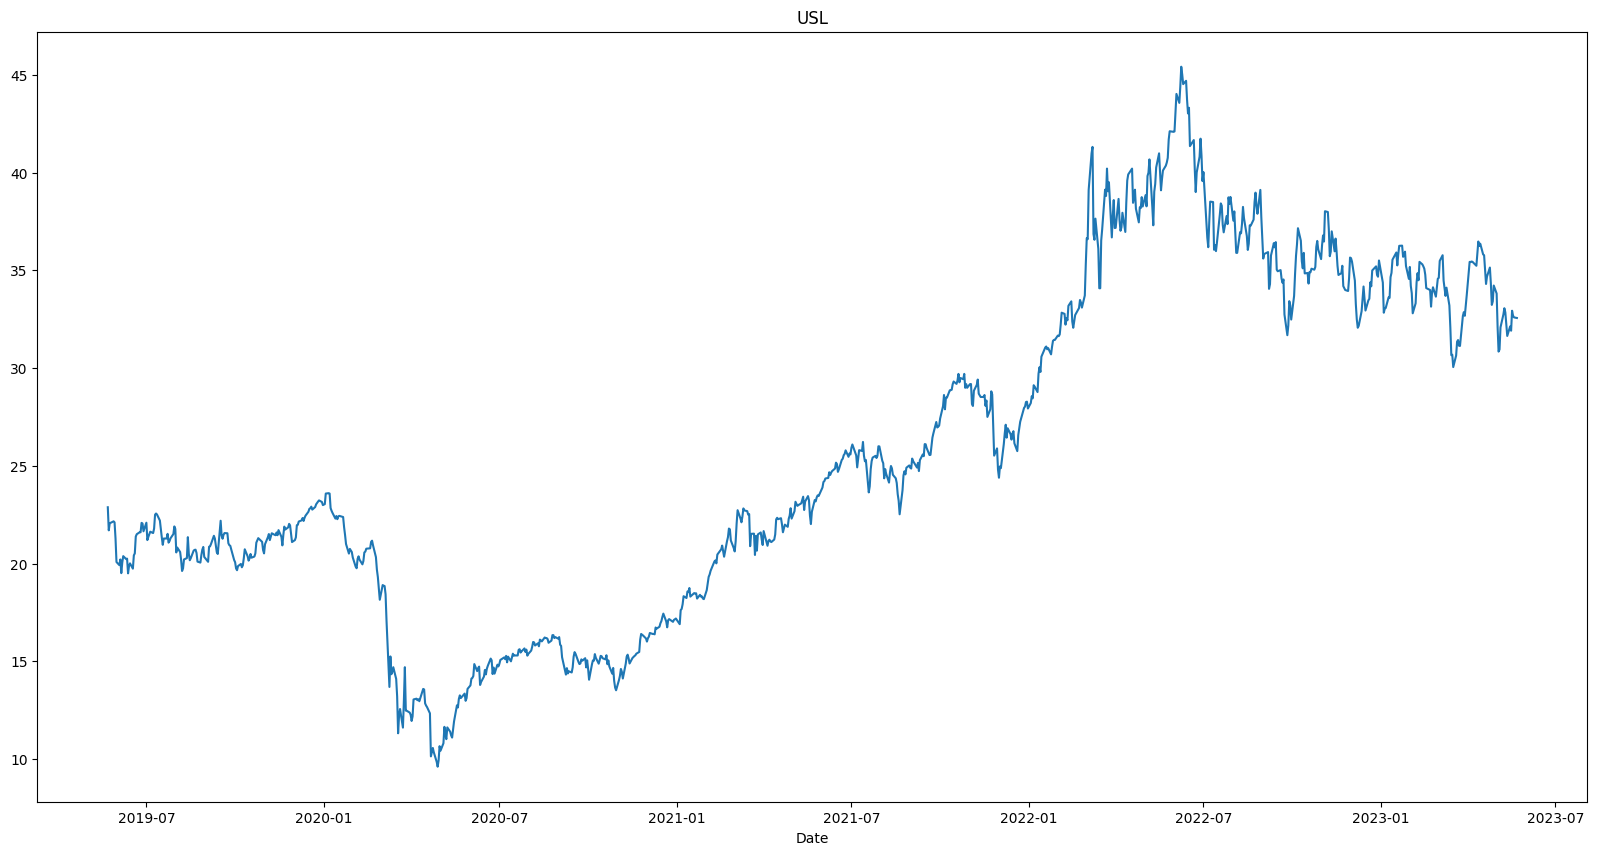

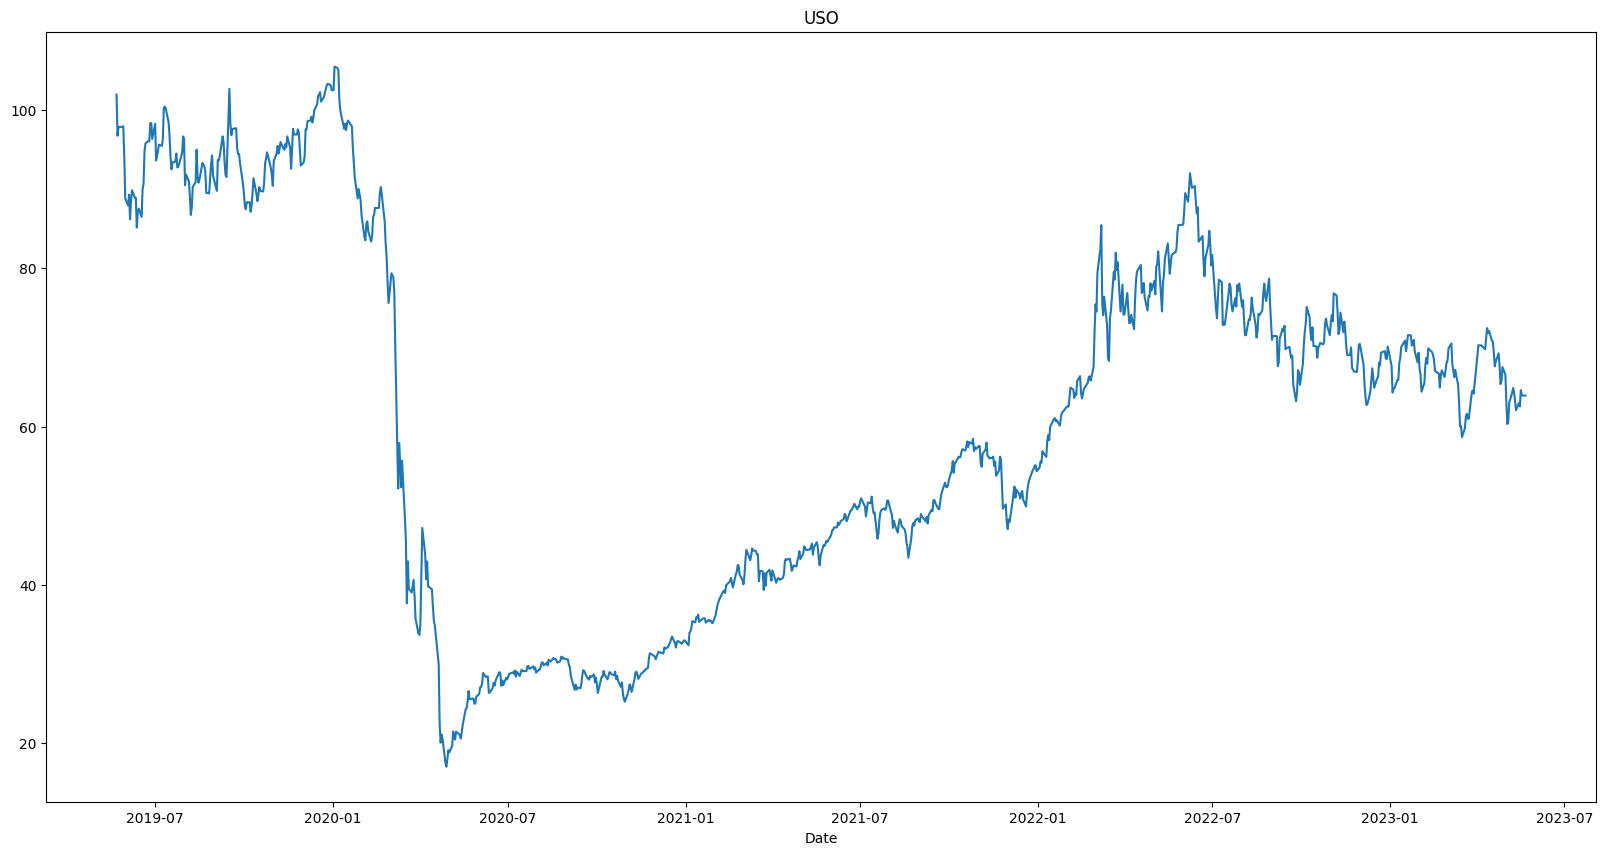

In [46]:
for column in energy_data_is.columns:
    plt.figure(figsize=(20, 10))
    plt.plot(energy_data_is.index, energy_data_is[column])
    plt.title(column)
    plt.xlabel('Date')
    plt.show()

Time series I(1) graphs

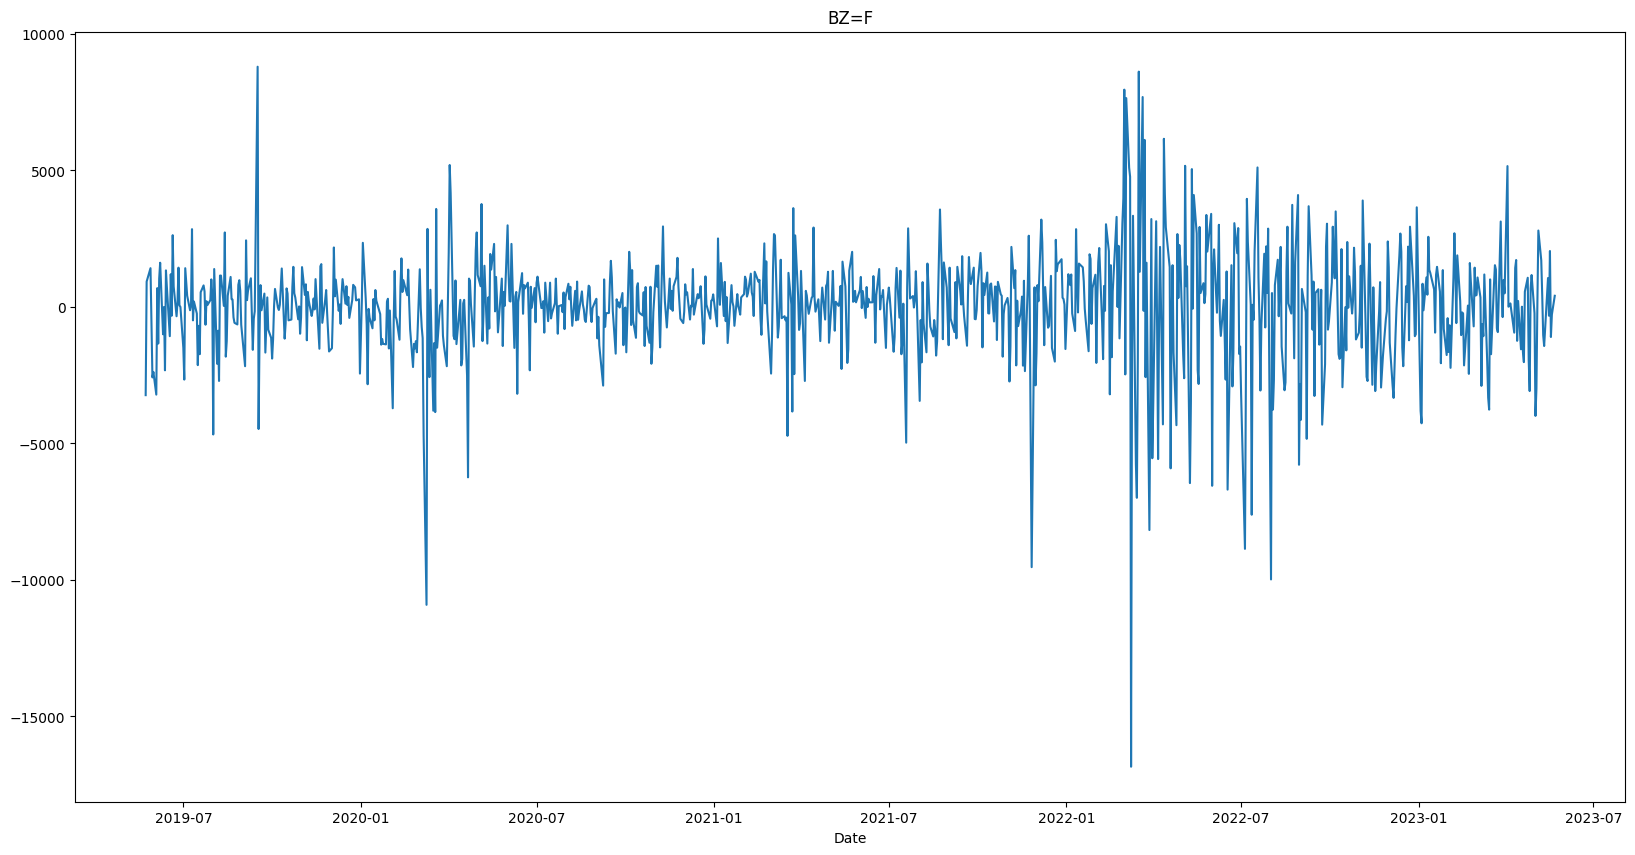

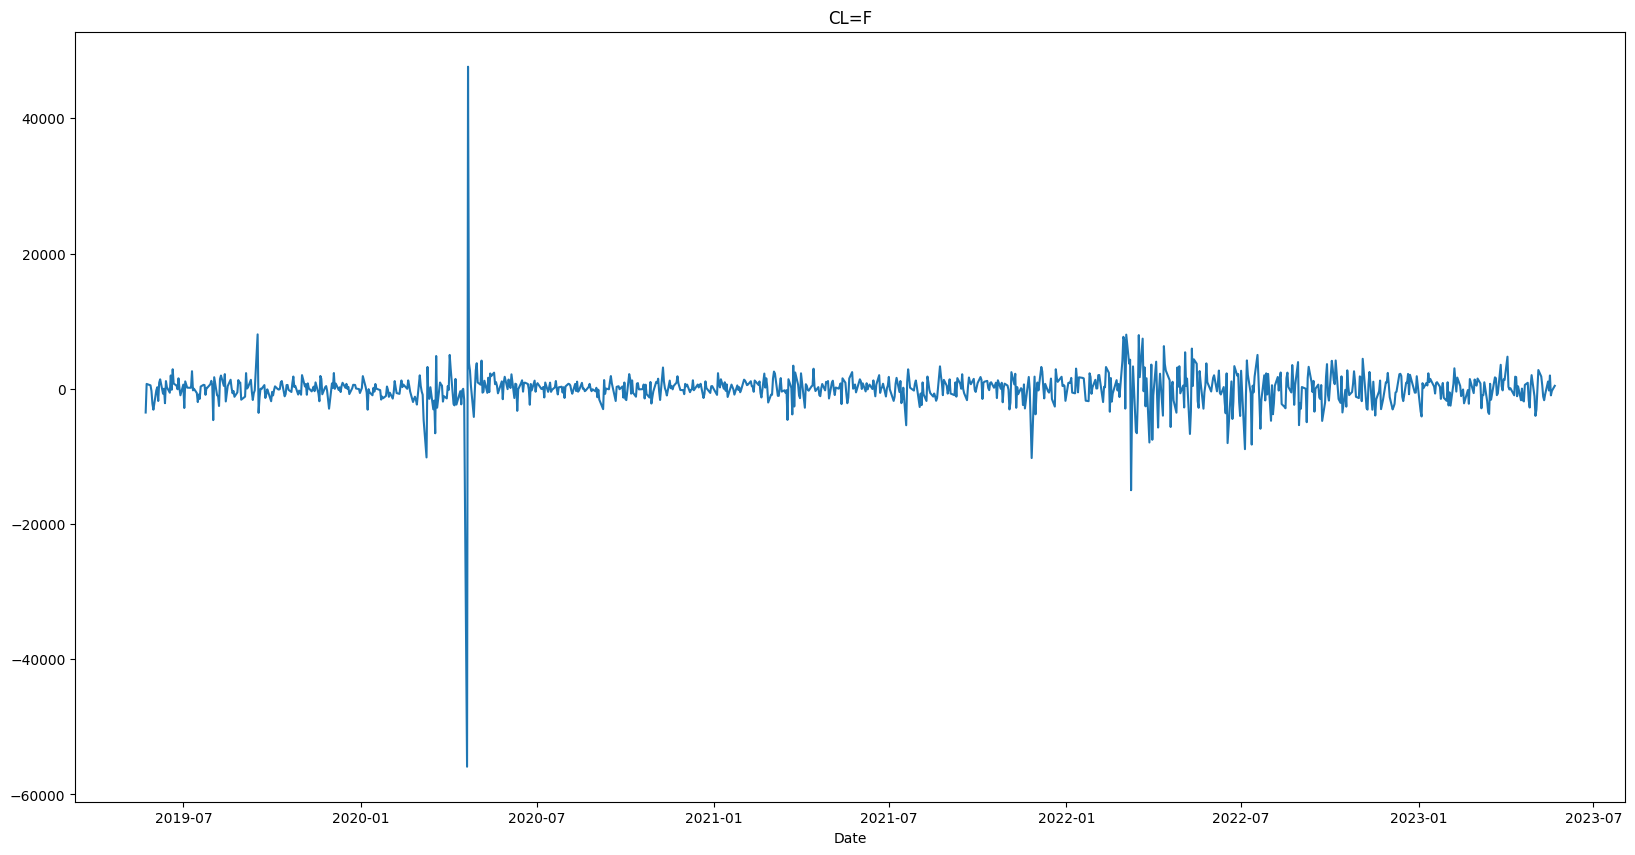

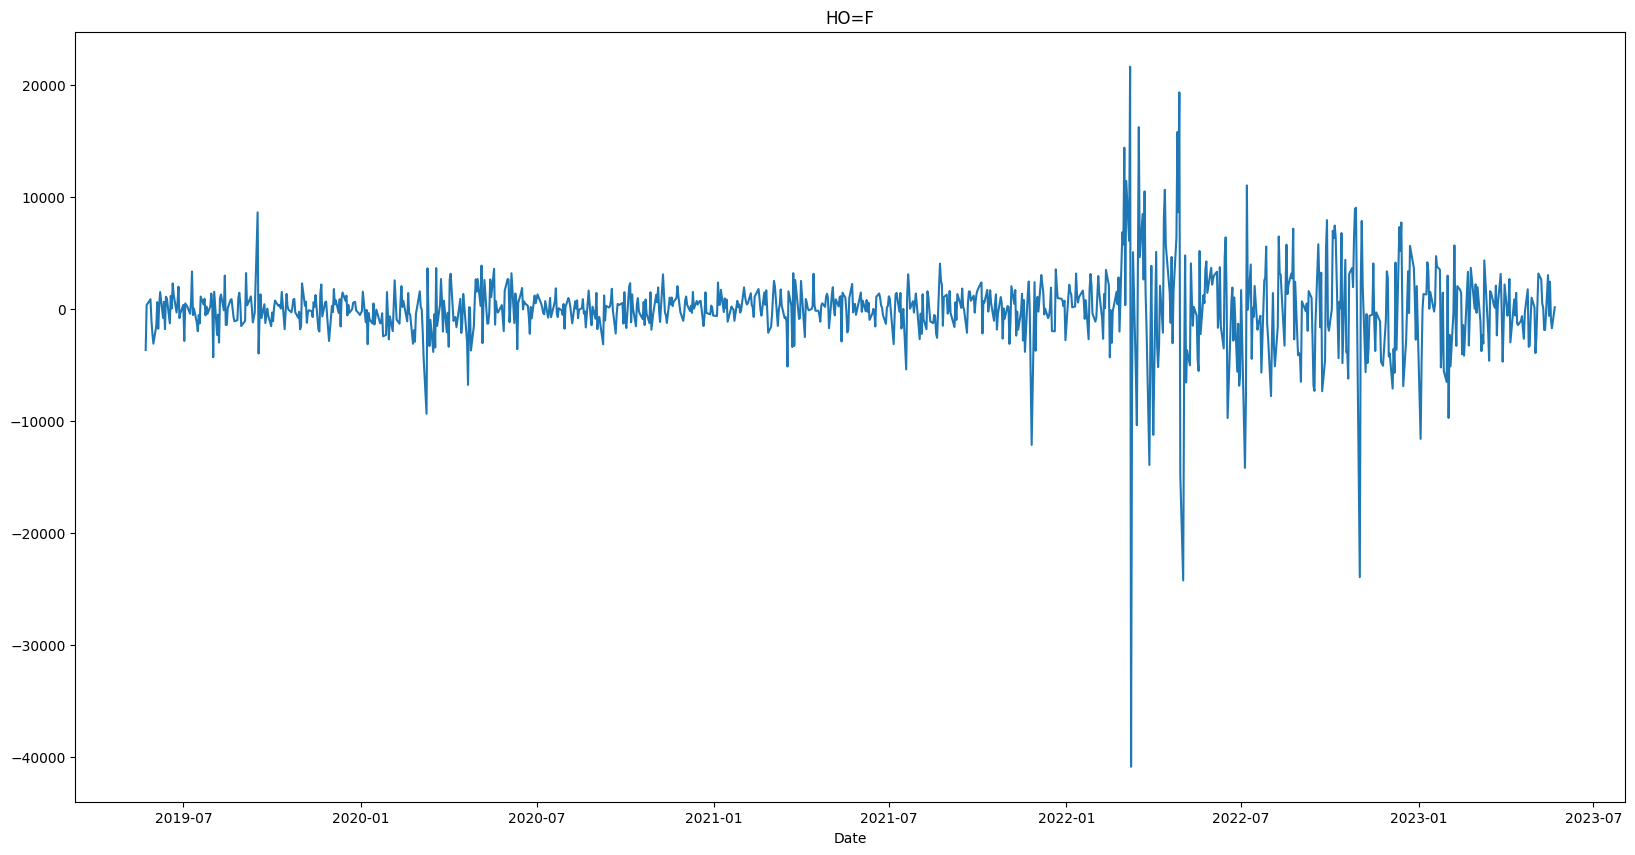

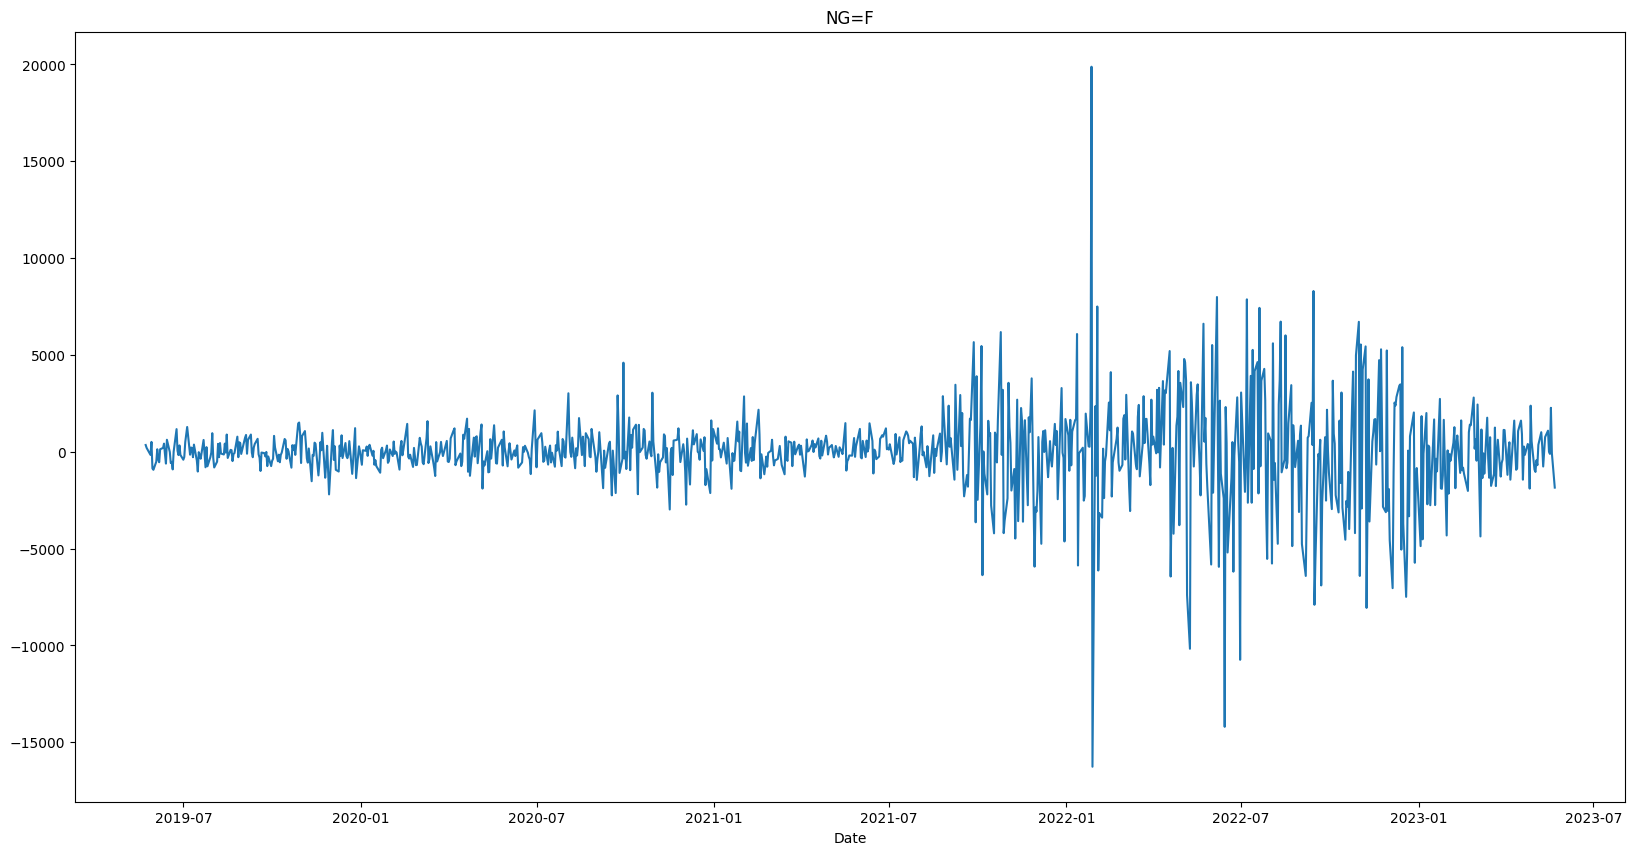

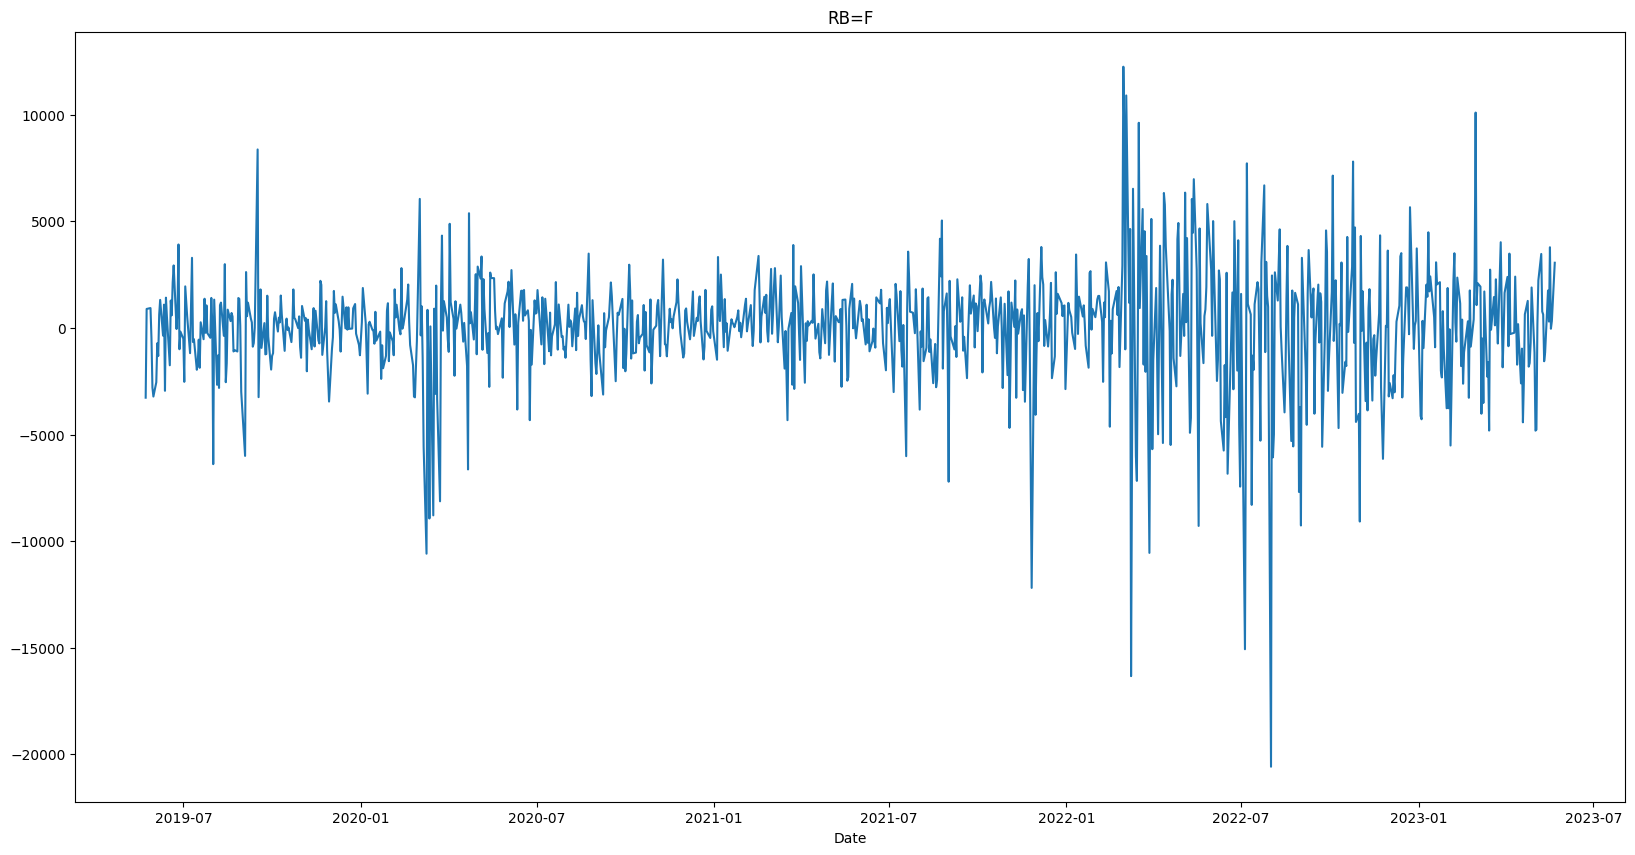

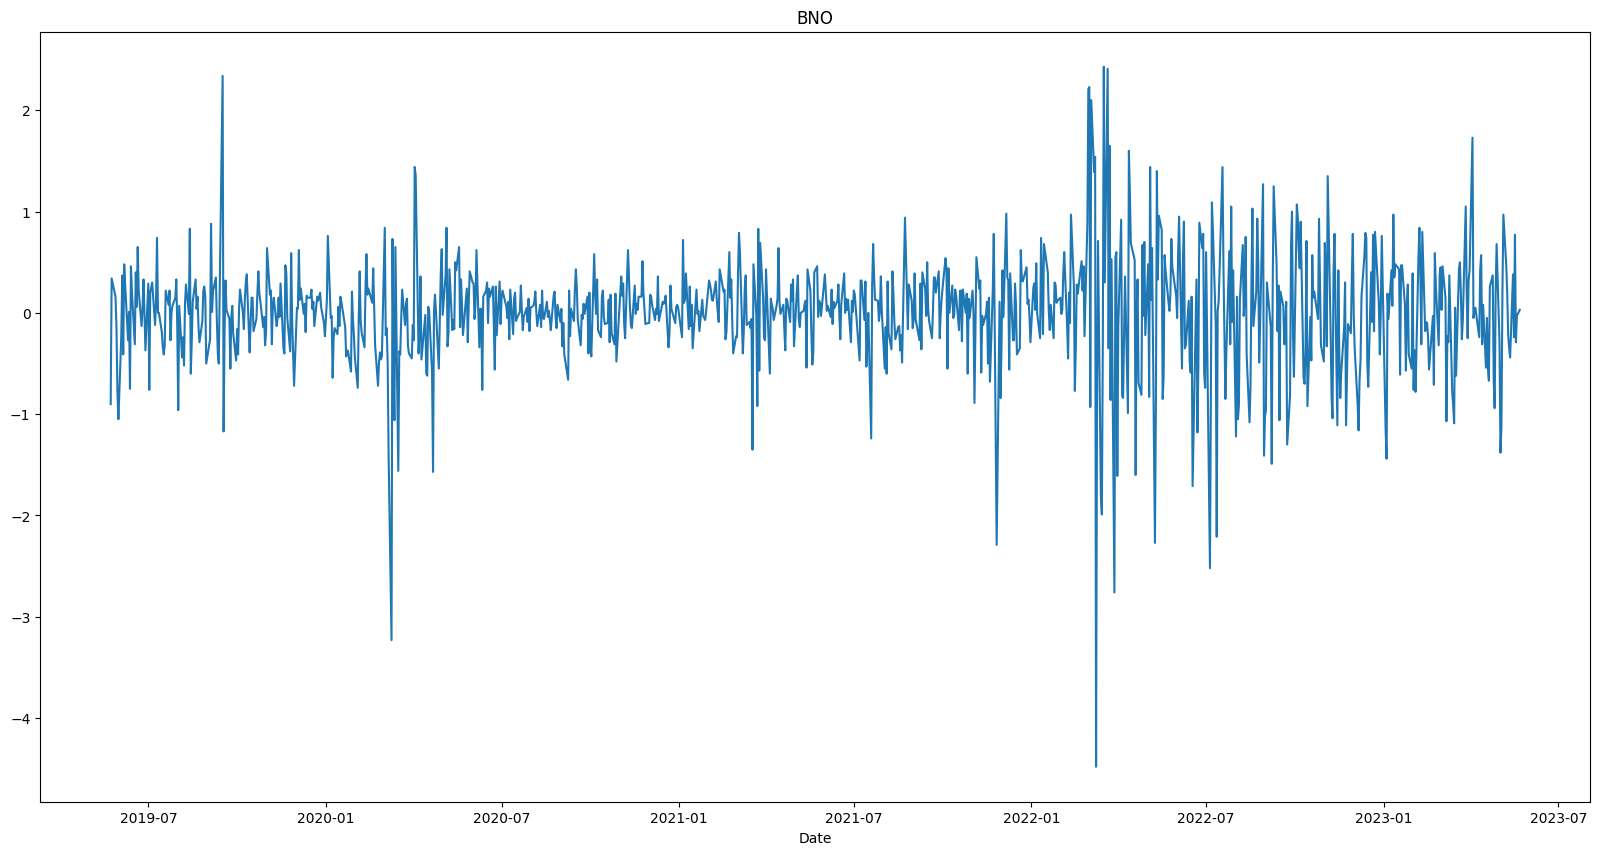

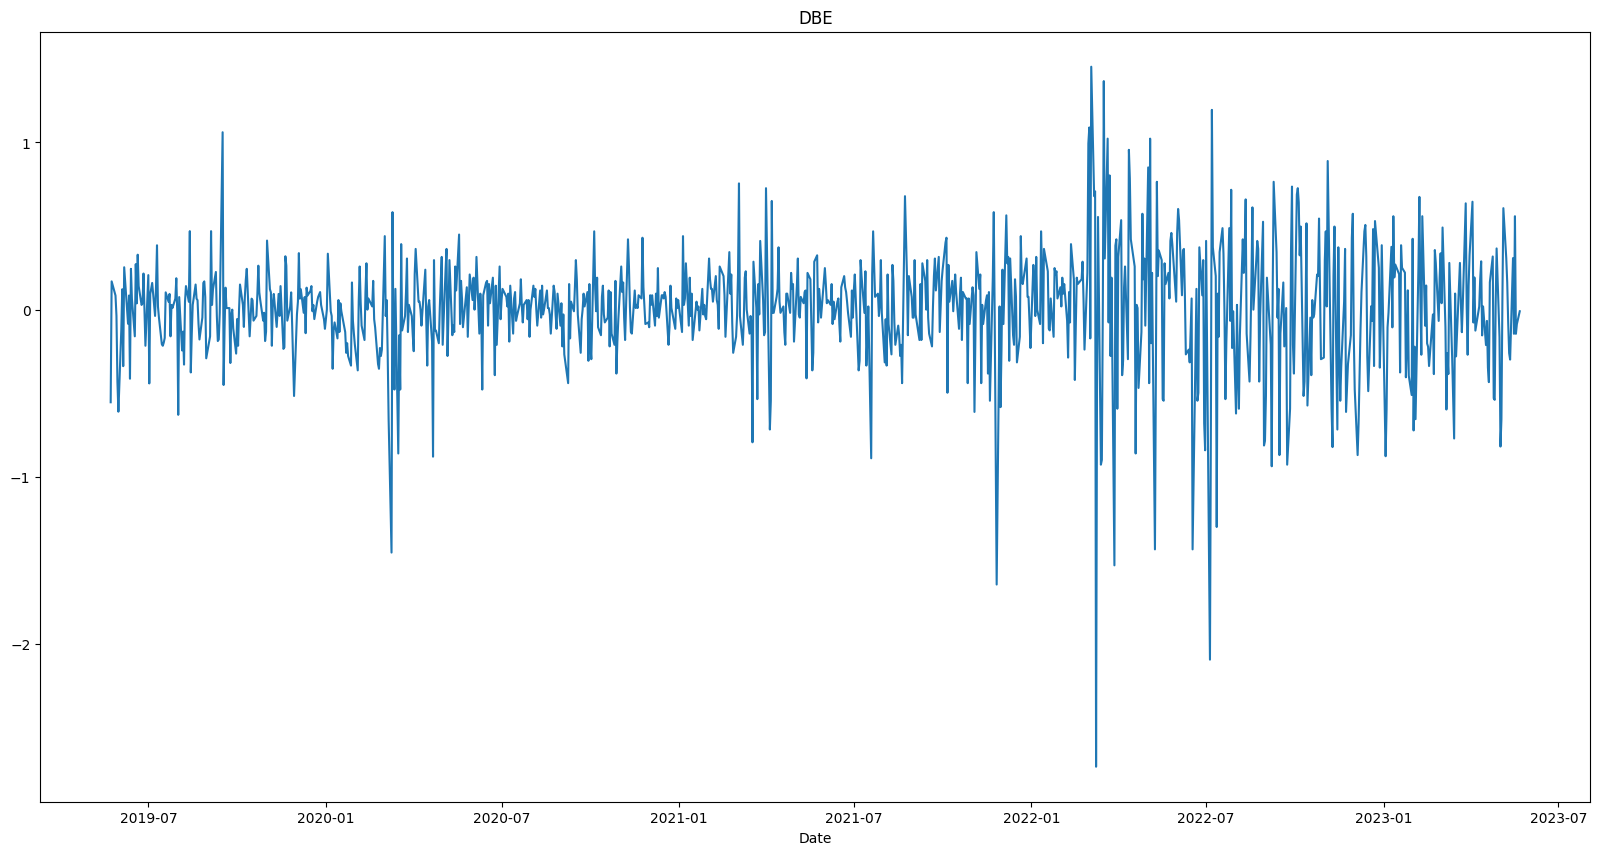

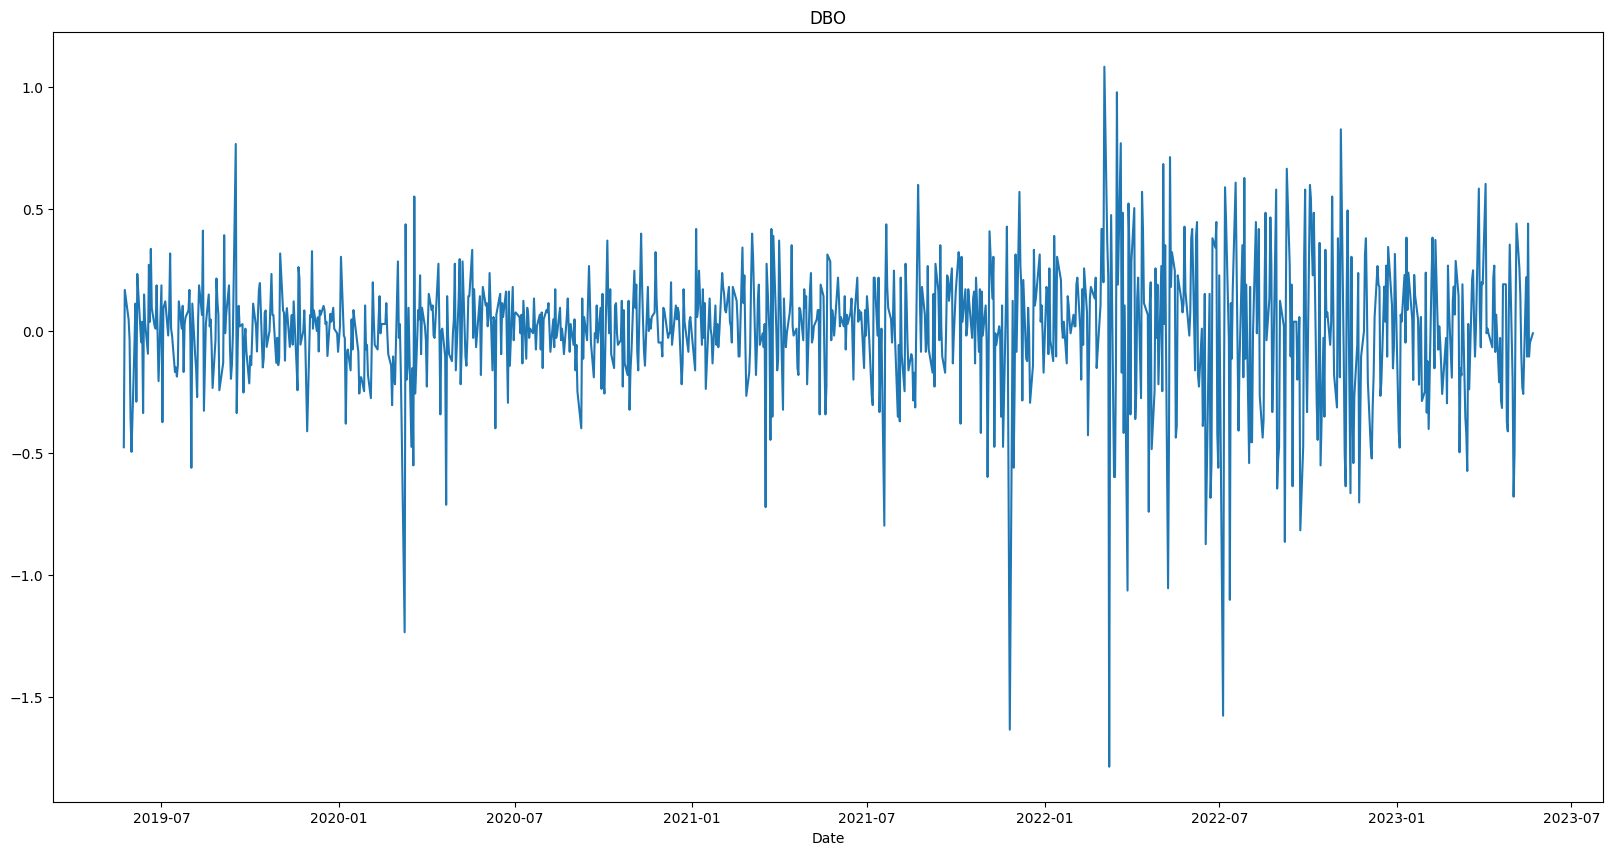

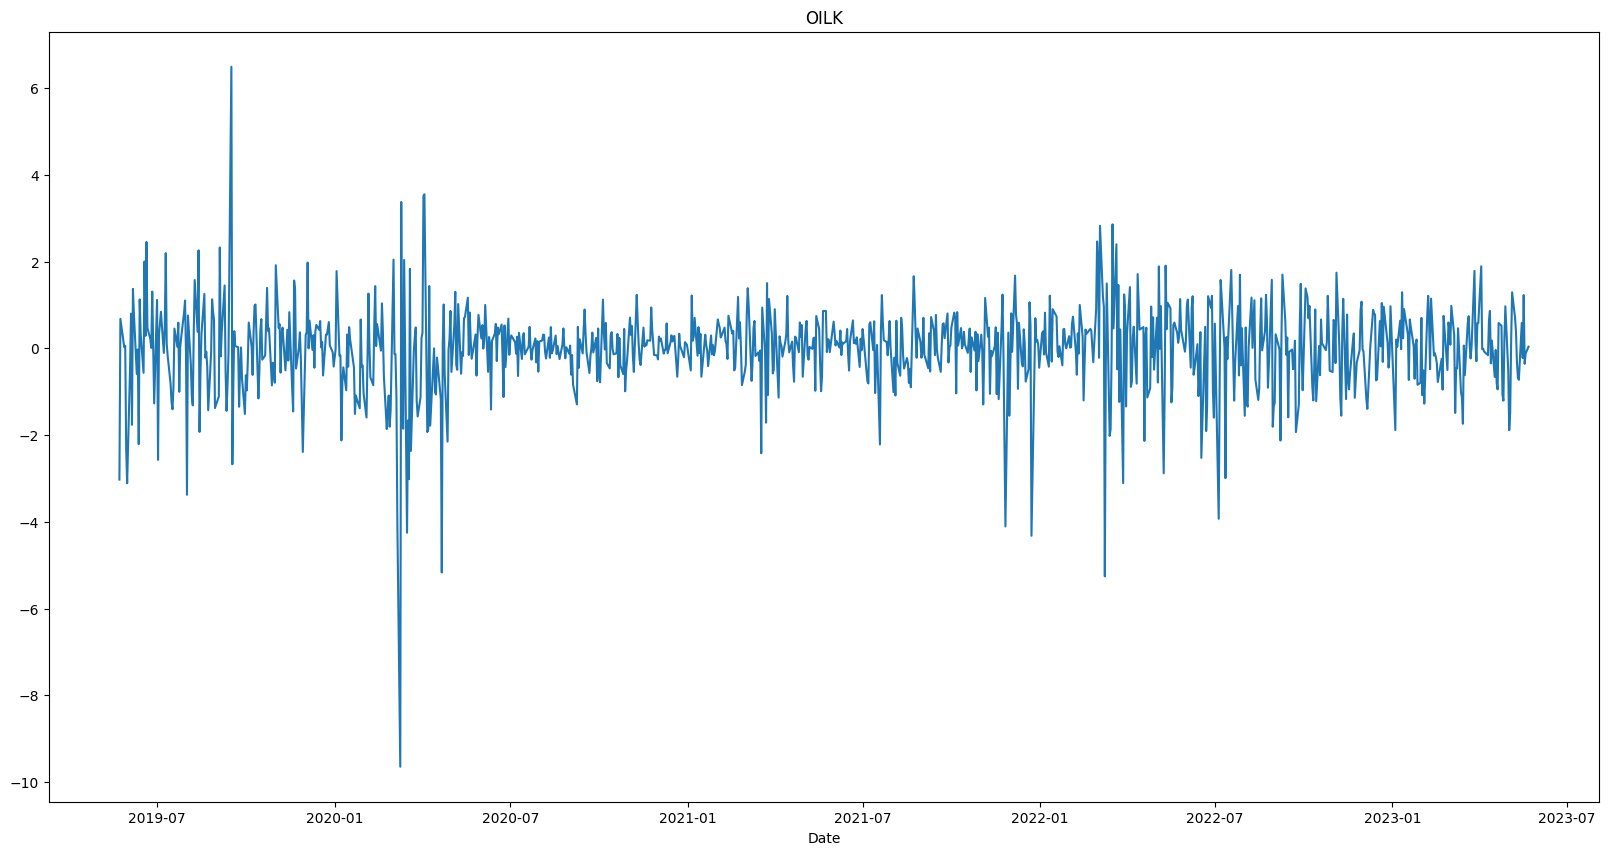

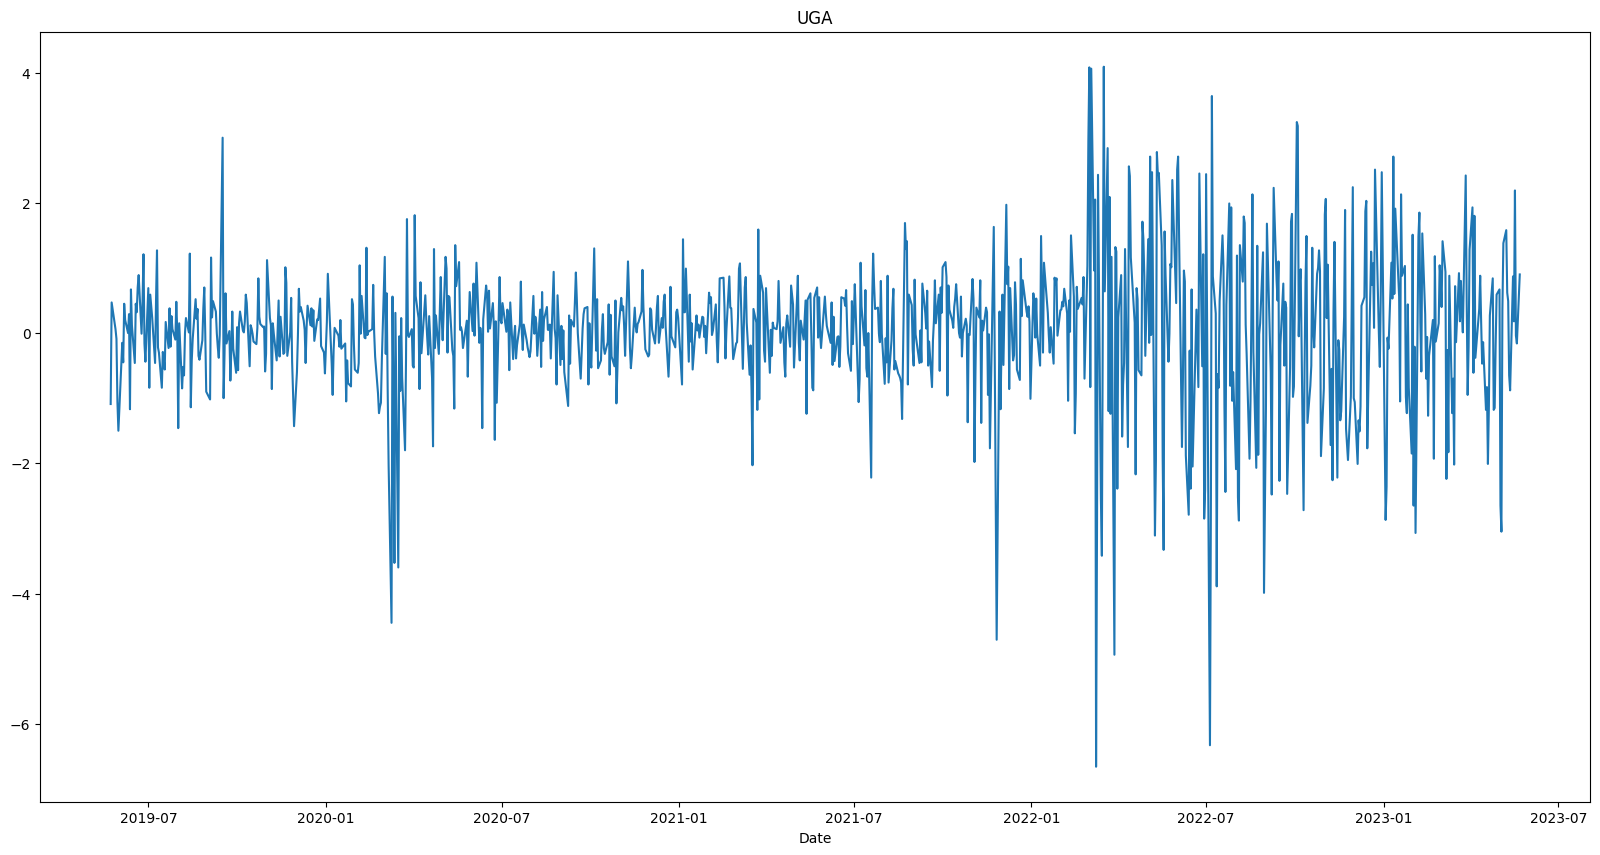

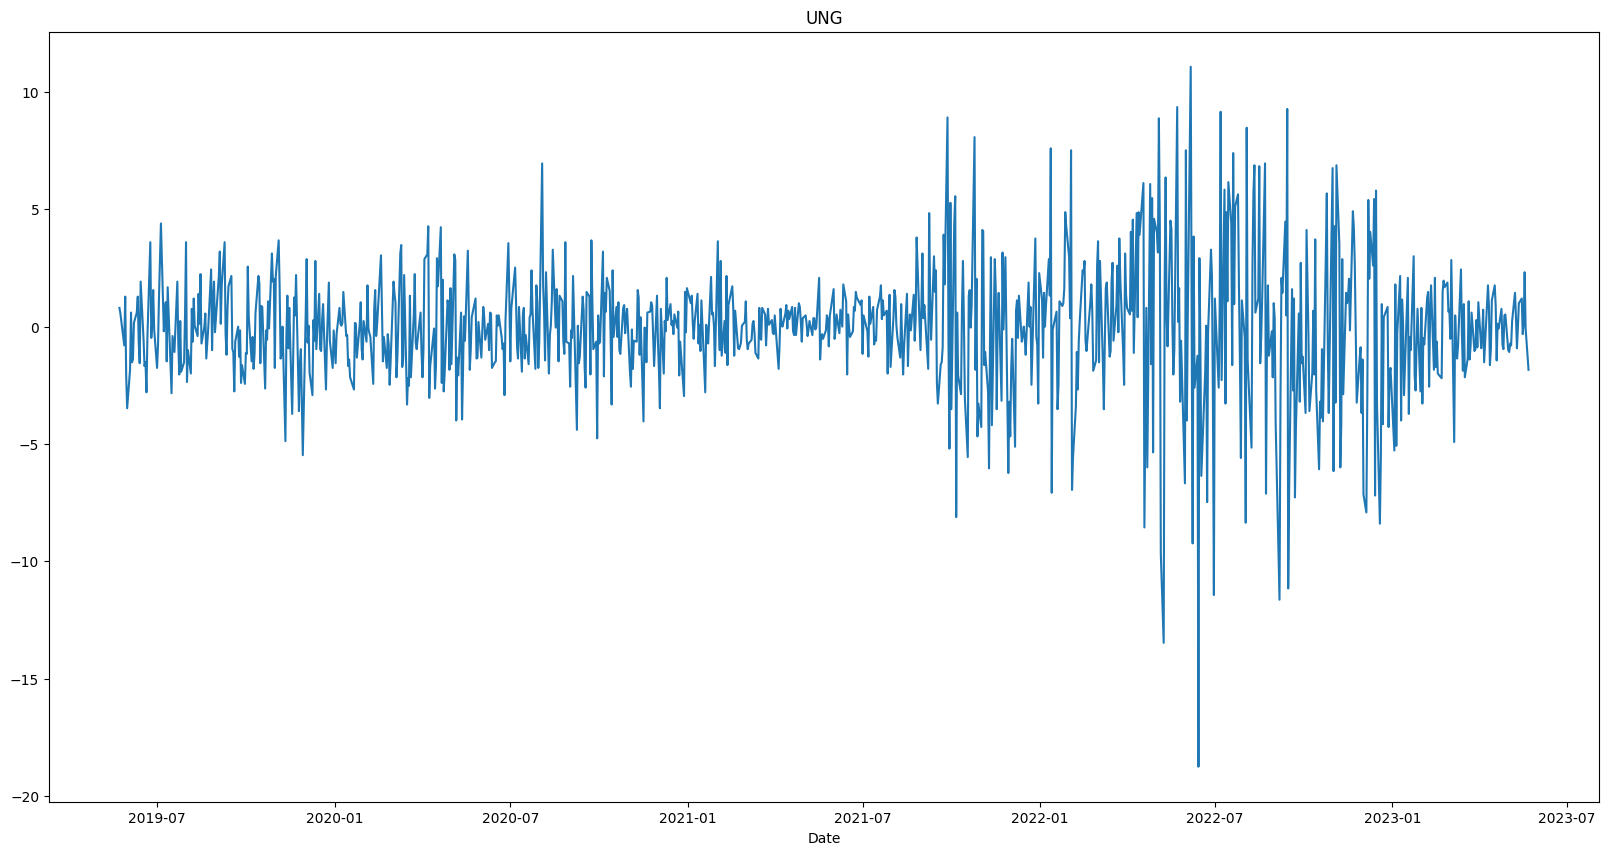

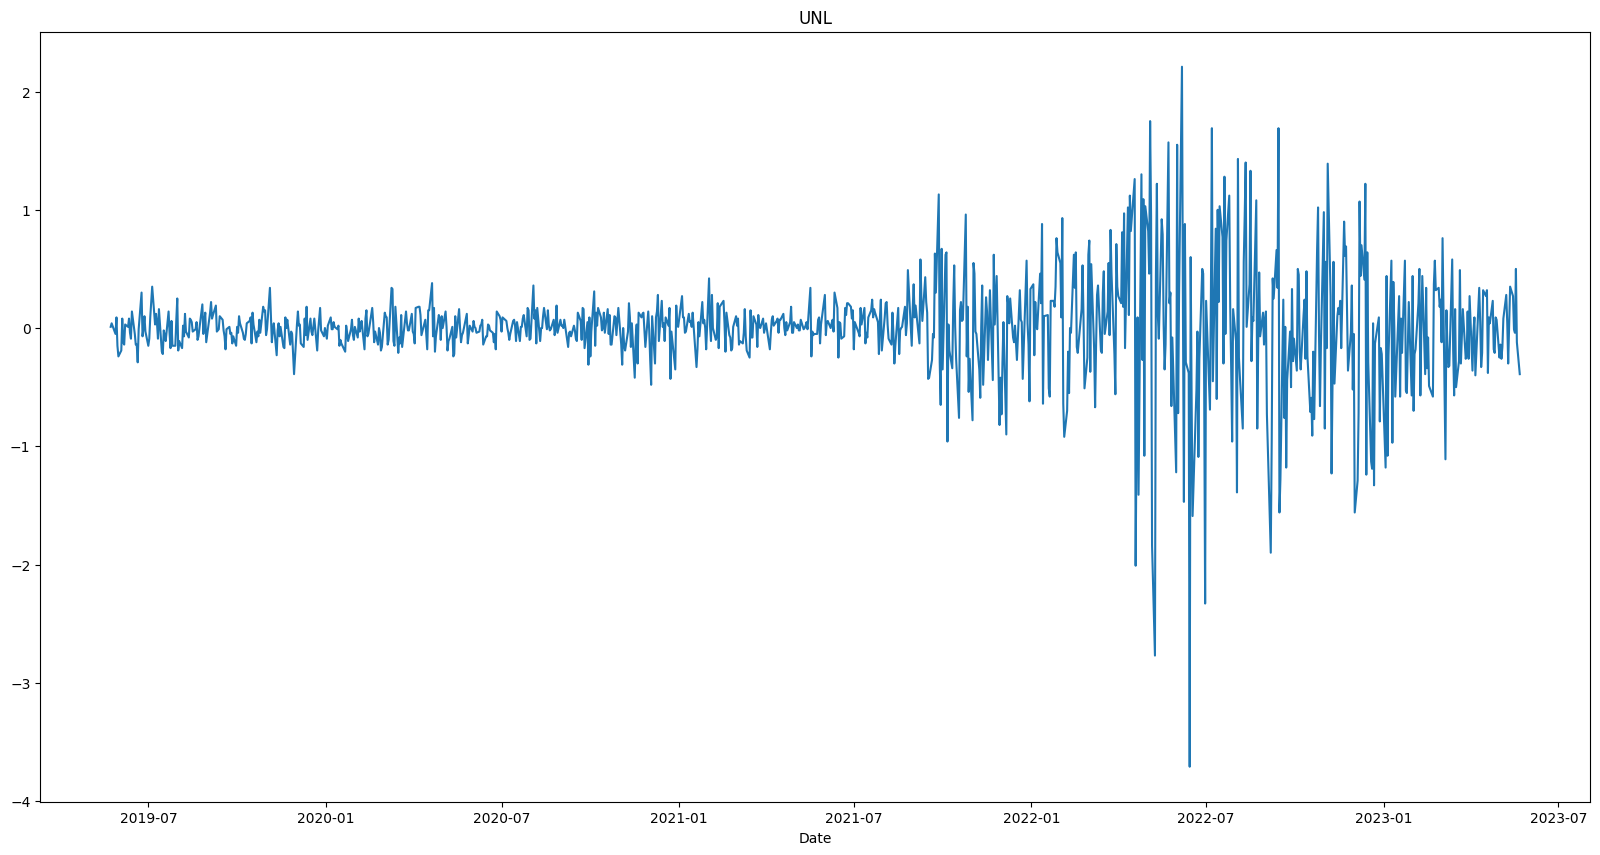

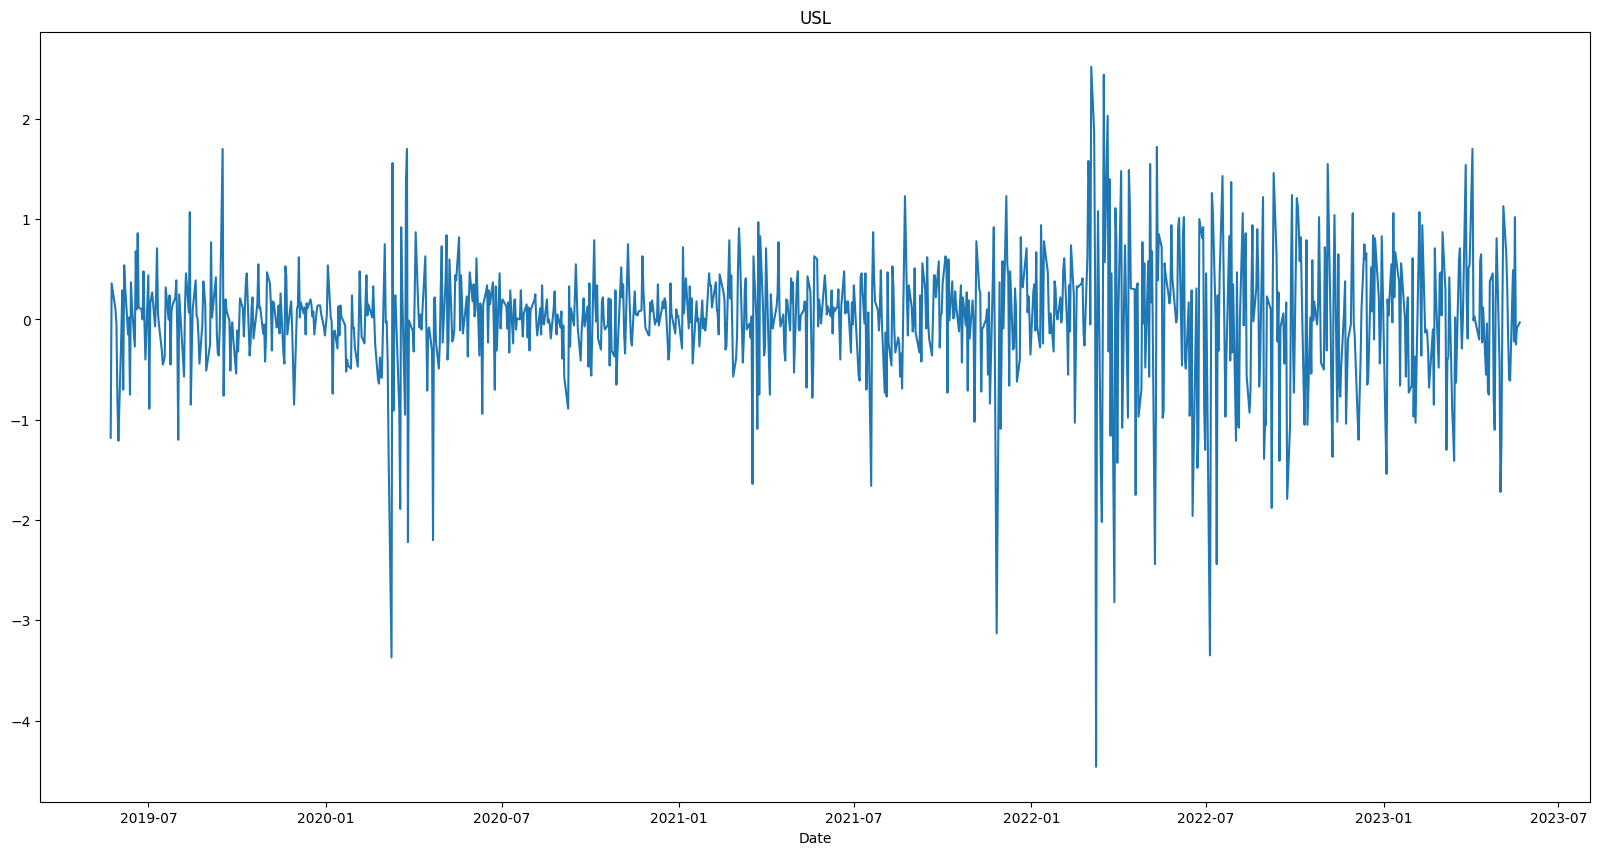

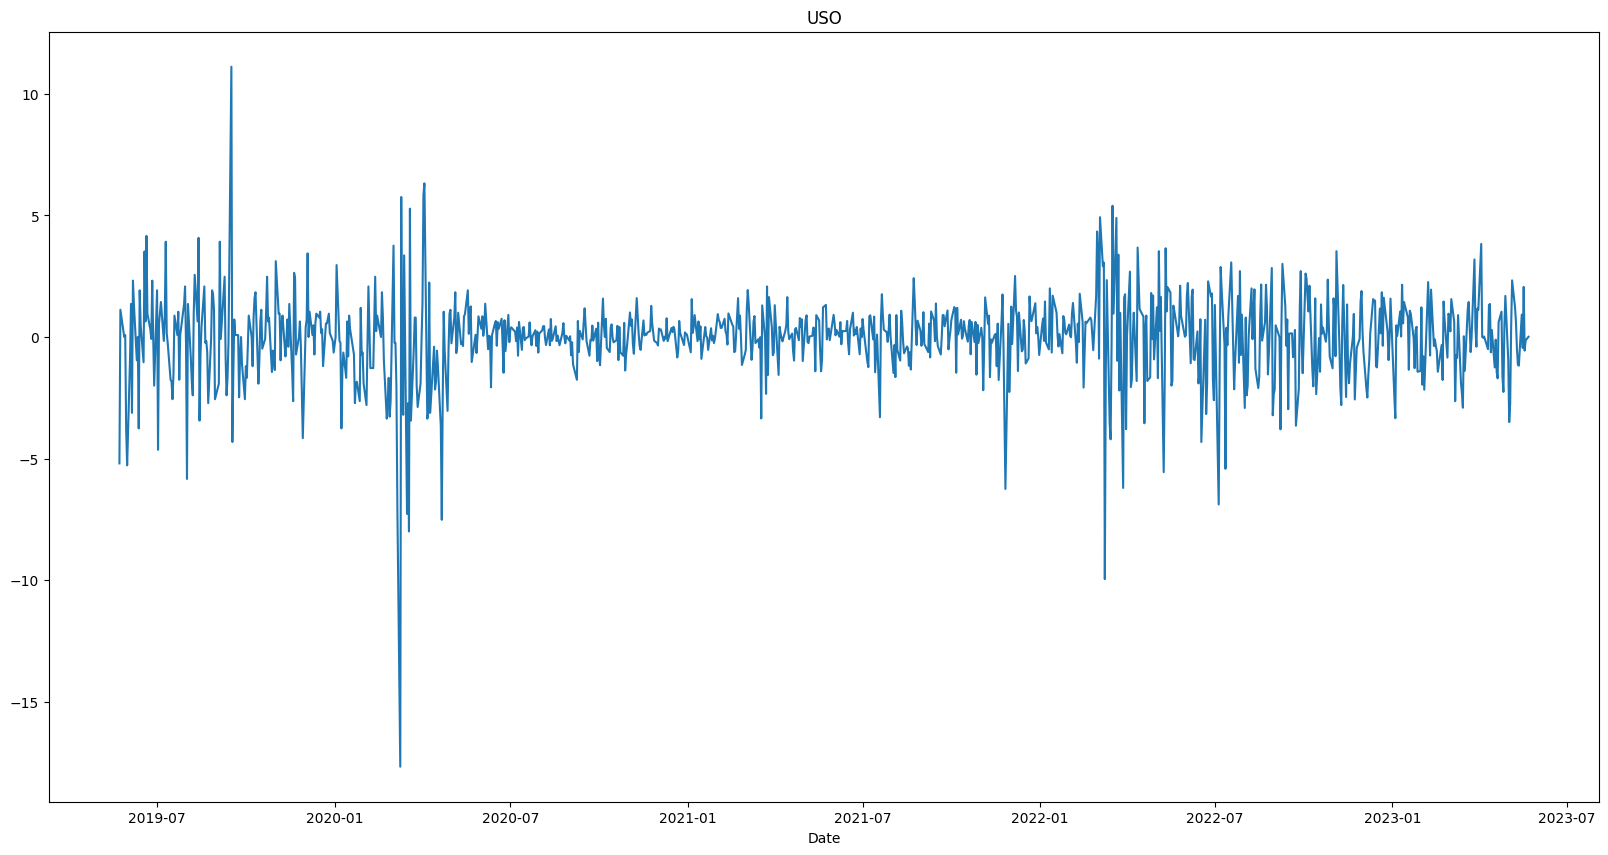

In [47]:
for column in energy_data_is.columns:
    plt.figure(figsize=(20, 10))
    plt.plot(energy_data_is.diff().dropna().index, energy_data_is[column].diff().dropna())
    plt.title(column)
    plt.xlabel('Date')
    plt.show()

In [48]:
for ticker in energy_data_is:
    print(ticker)
    check_stationarity(energy_data_is[ticker].diff().dropna())
    print(" ")
    kpss_test(energy_data_is[ticker])
    print('------------------------------------------------------------------------------------')

BZ=F
The series is stationary
 
KPSS Test Statistic : 3.266219599994291
p-value : 0.01
Orders of Integration : 19
Confidence Interval:Crit Value : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is non-stationary
------------------------------------------------------------------------------------
CL=F
The series is stationary
 
KPSS Test Statistic : 3.2975279703617484
p-value : 0.01
Orders of Integration : 19
Confidence Interval:Crit Value : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is non-stationary
------------------------------------------------------------------------------------
HO=F
The series is stationary
 
KPSS Test Statistic : 3.450168732163156
p-value : 0.01
Orders of Integration : 19
Confidence Interval:Crit Value : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Strong evidence agai

## 2. Functions for cointegration tests, backtesting, generating dataframes

Dataframes broken down into Pairs, Positions, Returns

In [ ]:
def engle_granger_test(series1, series2):
    model = OLS(series1, sm.add_constant(series2)).fit()
    residuals = model.resid
    adf_result = adfuller(residuals)
    rsquared = model.rsquared
    return adf_result[1], residuals, model, rsquared

# Find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    keys = data.columns
    pairs = []
    pvalues = np.ones((n, n))
    
    for i, j in combinations(range(n), 2):
        series1 = data[keys[i]]
        series2 = data[keys[j]]
        
        pvalue, residuals, model, rsquared = engle_granger_test(series1, series2)
        pvalues[i, j] = pvalue
        if pvalue < 0.05:  # Cointegration at 5% significance level
            pairs.append((keys[i], keys[j], residuals, model, series1, series2))
            print(f"Pair: ({keys[i]}, {keys[j]}) - R-squared: {rsquared}, p-value: {pvalue}")
            
    return pairs, pvalues

# def plot_residuals(pairs):
#     for stock1, stock2, residuals, model in pairs:
#         plt.figure(figsize=(10, 5))
#         plt.plot(residuals, label=f'Residuals of {stock1} and {stock2}')
#         plt.axhline(0, color='red', linestyle='--', lw=1)
#         plt.title(f'Residuals of {stock1} and {stock2}')
#         plt.xlabel('Time')
#         plt.ylabel('Residuals')
#         plt.legend()
#         plt.show()
        
def kalman_filter_pairs(data_1, data_2, Q=0.1, R=0.1):
    n = len(data_1)
    spread = data_1 - data_2
    x_hat = np.zeros(n)    # Predicted state estimate
    P = np.zeros(n)        # Predicted error covariance
    x_hat_minus = np.zeros(n)
    P_minus = np.zeros(n)
    for k in range(1, n):
        # Time update
        x_hat_minus[k] = x_hat[k-1]
        P_minus[k] = P[k-1] + Q
        # Measurement update
        K = P_minus[k] / (P_minus[k] + R)
        x_hat[k] = x_hat_minus[k] + K * (spread[k] - x_hat_minus[k])
        P[k] = (1 - K) * P_minus[k]
    return x_hat   

def equal_weights(num_assets):
    return num_assets * [1. / num_assets]

def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe = (returns) / std
    return std, returns, sharpe

def neg_sharpe_ratio(weights, mean_returns, cov_matrix):
    std, returns, sharpe = portfolio_performance(weights, mean_returns, cov_matrix)
    return -sharpe

def max_sharpe_ratio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(neg_sharpe_ratio, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def combine(dictionary):
    dataframe = pd.DataFrame()

    for key, df in dictionary.items():
        dataframe = dataframe.add(df, fill_value=0)

    dataframe.dropna(inplace=True)
    return dataframe

def cumulative_returns(returns, weights):
    weighted_returns = returns * weights
    portfolio_returns = weighted_returns.sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    return cumulative_returns

def daily_returns(returns, weights):
    weighted_returns = returns * weights
    portfolio_returns = weighted_returns.sum(axis=1)
    return portfolio_returns

In [77]:
def backtest(data, std, stop, label):
    
    pairs, pvalues = find_cointegrated_pairs(data) 
    
    dataframes_dict = {}
    positions_dict = {}
    returns_dict = {}
    pairs_returns_dict = {}
    
    print('-------------------------------------------------------------------------------------')
    
    for stock1, stock2, residuals, model, series1, series2 in pairs:
        
        print(f'{stock1}/{stock2} Hedge Ratio: {model.params[1]:.2f}')
        return_df = pd.DataFrame()
        pairs_return = pd.DataFrame()
        
        dataframe = pd.DataFrame()
        dataframe[stock1] = series1
        dataframe[stock2] = series2
        dataframe['Spread'] = residuals
        dataframe['Spread_norm'] = (residuals - dataframe['Spread'].mean())/dataframe['Spread'].std()
        
        dataframe['mean'] = dataframe['Spread_norm'].mean()
        dataframe['upper_bound'] = std
        dataframe['lower_bound'] = -std
        dataframe['3sd_upper'] = stop
        dataframe['3sd_lower'] = -stop
        
        dataframe['Spread Position'] = np.nan
        dataframe['Spread Position'] = np.where((dataframe['3sd_upper'] > dataframe['Spread_norm']) &\
                                                (dataframe['Spread_norm'] > dataframe['upper_bound']), -1, dataframe['Spread Position'])
        dataframe['Spread Position'] = np.where((dataframe['3sd_lower'] < dataframe['Spread_norm']) &\
                                                (dataframe['Spread_norm'] < dataframe['lower_bound']), 1, dataframe['Spread Position'])
        dataframe['Spread Position'] = np.where(dataframe['Spread_norm']*dataframe['Spread_norm'].shift(1) < 0, 0, dataframe['Spread Position'])
        dataframe['Spread Position'] = np.where(dataframe['3sd_upper'] < dataframe['Spread_norm'], 0, dataframe['Spread Position'])
        dataframe['Spread Position'] = np.where(dataframe['3sd_lower'] > dataframe['Spread_norm'], 0, dataframe['Spread Position'])
        dataframe['Spread Position'] = dataframe['Spread Position'].ffill()
        dataframe['Spread Position'].fillna(0, inplace=True)
        
        position = pd.DataFrame(index = dataframe.index)
        
        position[stock1 + ' Positions'] = dataframe['Spread Position']
        position[stock2 + ' Positions'] = dataframe['Spread Position'] * model.params[1] * -1
        
        position[stock1 + ' Normalized Pos'] = dataframe['Spread Position'] / model.params[1]
        position[stock2 + ' Normalized Pos'] = dataframe['Spread Position'] * -1
        
        #pair positions
        dataframe[stock1 + ' Notional'] = position[stock1 + ' Positions'] * dataframe[stock1].shift(-1)
        dataframe[stock2 + ' Notional'] = position[stock2 + ' Positions'] * dataframe[stock2].shift(-1)
        
        #pair returns
        return_df[stock1 + ' return'] = dataframe[stock1] / dataframe[stock1].shift(1) - 1
        return_df[stock2 + ' return'] = dataframe[stock2] / dataframe[stock2].shift(1) - 1
        return_df.dropna(inplace=True)
        
        #pair pnl
        dataframe['dailypnl'] = position[stock1 + ' Normalized Pos'] * return_df[stock1 + ' return'].shift(-1) +\
                                 position[stock2 + ' Normalized Pos'] * return_df[stock2 + ' return'].shift(-1)
        
        dataframe['cumpnl'] = dataframe['dailypnl'].cumsum()
        
        dataframe.dropna(inplace=True)
        
        pairs_return[stock1 + '/' + stock2 + ' return'] = dataframe['dailypnl']
        
        dataframes_dict[stock1 + '/' + stock2] = dataframe
        
        positions_dict[stock1 + '/' + stock2] = position
        
        returns_dict[stock1 + '/' + stock2] = return_df
        
        pairs_returns_dict[stock1 + '/' + stock2] = pairs_return
        
        plt.figure(figsize=(14, 7))
        plt.plot(dataframe['Spread_norm'], label='Spread')
        plt.axhline(dataframe['mean'].iloc[0], color='black', linestyle='--', label='Mean')
        plt.axhline(dataframe['upper_bound'].iloc[0], color='red', linestyle='--', label='+2')
        plt.axhline(dataframe['lower_bound'].iloc[0], color='red', linestyle='--', label='-2')
        plt.axhline(dataframe['3sd_upper'].iloc[0], color='green', linestyle='--', label='+3')
        plt.axhline(dataframe['3sd_lower'].iloc[0], color='green', linestyle='--', label='-3')
        plt.title(f'Spread of {stock1} and {stock2}')
        plt.xlabel('Time')
        plt.ylabel('Spread')
        plt.legend()
        plt.show()      
    
    combined_positions = combine(positions_dict)
    combined_returns = combine(returns_dict)
    combined_pairs_returns = combine(pairs_returns_dict)
    
    returns = combined_pairs_returns
    
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    # Maximize Sharpe Ratio
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix)
    max_sharpe_weights = max_sharpe['x']

    # Equal weights
    equal_weight = equal_weights(len(mean_returns))

    returns_assets = (1 + returns).cumprod()

    # Cumulative returns for max Sharpe ratio portfolio
    returns_max_sharpe = cumulative_returns(returns, max_sharpe_weights)

    # Cumulative returns for equal weight portfolio
    returns_equal = cumulative_returns(returns, equal_weight)
    
    # Daily returns
    daily_returns_max_sharpe = daily_returns(returns, max_sharpe_weights)
    
    # Daily returns
    daily_returns_equal = daily_returns(returns, equal_weight)
    
    
    for column in returns.columns:
        plt.figure(figsize=(9, 6))
        plt.plot(returns_assets.index, returns_assets[column], label=column)
        plt.title(f'Daily Returns of {column}')
        plt.xlabel('Time')
        plt.ylabel('Cumulative Return')
        plt.legend(prop={'size': 10})
        plt.show()

    plt.figure(figsize=(9, 6))
    plt.plot(returns_max_sharpe, label='Max Sharpe Ratio Portfolio (In-sample)')
    plt.plot(returns_equal, label='Equal Weight Portfolio (In-sample)')
    plt.title(f'Cumulative Returns of {label} Portfolio')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.show()
    
    pnl = daily_returns_max_sharpe 
    cumpnl = pnl.cumsum(skipna = True)

    sharpe = pnl.mean()/np.std(pnl)
    sharpe = sharpe*np.sqrt(252)
    print("")
    print ("PERFORMANCE STATISTICS FOR "+label +' MAX SHARPE');
    print("Daily annualized sharpe: "+str(sharpe))
    print ("Average annual returns: "+str(pnl.mean()*252*100)+"%")
    print ("Total returns: "+str(pnl.sum()*100)+"%");
    highwatermark_df = cumpnl.cummax();
    drawdown_df = cumpnl - highwatermark_df;
    maxdrawdown = drawdown_df.min();
    print ("Max drawdown: "+str(maxdrawdown*100)+"%");
    
    pnl = daily_returns_equal 
    cumpnl = pnl.cumsum(skipna = True)

    sharpe = pnl.mean()/np.std(pnl)
    sharpe = sharpe*np.sqrt(252)
    print("")
    print ("PERFORMANCE STATISTICS FOR "+label +' EQUAL WEIGHTS');
    print("Daily annualized sharpe: "+str(sharpe))
    print ("Average annual returns: "+str(pnl.mean()*252*100)+"%")
    print ("Total returns: "+str(pnl.sum()*100)+"%");
    highwatermark_df = cumpnl.cummax();
    drawdown_df = cumpnl - highwatermark_df;
    maxdrawdown = drawdown_df.min();
    print ("Max drawdown: "+str(maxdrawdown*100)+"%");
    
    return daily_returns_max_sharpe, daily_returns_equal

In [78]:
def backtest_os(is_data, os_data, std, stop, label):

    out_sample_data = os_data
    
    # Perform in-sample backtest to get the parameters
    pairs, pvalues = find_cointegrated_pairs(is_data) 
    
    # Dictionary to store out-of-sample results
    os_dataframes_dict = {}
    os_positions_dict = {}
    os_returns_dict = {}
    os_pairs_returns_dict = {}
    
    print('-------------------------------------------------------------------------------------')
    
    for stock1, stock2, residuals, model, series1, series2 in pairs:
        
        print(f'{stock1}/{stock2} Hedge Ratio: {model.params[1]:.2f}')
        
        os_dataframe = pd.DataFrame()
        os_series1 = out_sample_data[stock1]
        os_series2 = out_sample_data[stock2]
        
        hedge_ratio = model.params[1]
        
        os_dataframe[stock1] = os_series1
        os_dataframe[stock2] = os_series2
        os_dataframe['Spread'] = os_series1 - hedge_ratio * os_series2
        os_dataframe['Spread_norm'] = (os_dataframe['Spread'] - os_dataframe['Spread'].mean())/os_dataframe['Spread'].std()
        
        os_dataframe['mean'] = os_dataframe['Spread_norm'].mean()
        os_dataframe['upper_bound'] = std
        os_dataframe['lower_bound'] = -std
        os_dataframe['3sd_upper'] = stop
        os_dataframe['3sd_lower'] = -stop
        
        os_dataframe['Spread Position'] = np.nan
        os_dataframe['Spread Position'] = np.where((os_dataframe['3sd_upper'] > os_dataframe['Spread_norm']) &\
                                                    (os_dataframe['Spread_norm'] > os_dataframe['upper_bound']), -1, os_dataframe['Spread Position'])
        os_dataframe['Spread Position'] = np.where((os_dataframe['3sd_lower'] < os_dataframe['Spread_norm']) &\
                                                    (os_dataframe['Spread_norm'] < os_dataframe['lower_bound']), 1, os_dataframe['Spread Position'])
        os_dataframe['Spread Position'] = np.where(os_dataframe['Spread_norm']*os_dataframe['Spread_norm'].shift(1) < 0, 0, os_dataframe['Spread Position'])
        os_dataframe['Spread Position'] = np.where(os_dataframe['3sd_upper'] < os_dataframe['Spread_norm'], 0, os_dataframe['Spread Position'])
        os_dataframe['Spread Position'] = np.where(os_dataframe['3sd_lower'] > os_dataframe['Spread_norm'], 0, os_dataframe['Spread Position'])
        os_dataframe['Spread Position'] = os_dataframe['Spread Position'].ffill()
        os_dataframe['Spread Position'].fillna(0, inplace=True)
        
        os_position = pd.DataFrame(index = os_dataframe.index)
        
        os_position[stock1 + ' Positions'] = os_dataframe['Spread Position']
        os_position[stock2 + ' Positions'] = os_dataframe['Spread Position'] * hedge_ratio * -1
        
        os_position[stock1 + ' Normalized Pos'] = os_dataframe['Spread Position'] / hedge_ratio
        os_position[stock2 + ' Normalized Pos'] = os_dataframe['Spread Position'] * -1
        
        # Pair positions
        os_dataframe[stock1 + ' Notional'] = os_position[stock1 + ' Positions'] * os_dataframe[stock1].shift(-1)
        os_dataframe[stock2 + ' Notional'] = os_position[stock2 + ' Positions'] * os_dataframe[stock2].shift(-1)
        
        # Pair returns
        os_return_df = pd.DataFrame()
        os_return_df[stock1 + ' return'] = os_dataframe[stock1] / os_dataframe[stock1].shift(1) - 1
        os_return_df[stock2 + ' return'] = os_dataframe[stock2] / os_dataframe[stock2].shift(1) - 1
        os_return_df.dropna(inplace=True)
        
        # Pair pnl
        os_dataframe['dailypnl'] = os_position[stock1 + ' Normalized Pos'] * os_return_df[stock1 + ' return'].shift(-1) +\
                                    os_position[stock2 + ' Normalized Pos'] * os_return_df[stock2 + ' return'].shift(-1)
        
        os_dataframe['cumpnl'] = os_dataframe['dailypnl'].cumsum()
        
        os_dataframe.dropna(inplace=True)
        
        os_pairs_return = pd.DataFrame()
        os_pairs_return[stock1 + '/' + stock2 + ' return'] = os_dataframe['dailypnl']
        
        os_dataframes_dict[stock1 + '/' + stock2] = os_dataframe
        os_positions_dict[stock1 + '/' + stock2] = os_position
        os_returns_dict[stock1 + '/' + stock2] = os_return_df
        os_pairs_returns_dict[stock1 + '/' + stock2] = os_pairs_return
        
        plt.figure(figsize=(14, 7))
        plt.plot(os_dataframe['Spread_norm'], label='Spread')
        plt.axhline(os_dataframe['mean'].iloc[0], color='black', linestyle='--', label='Mean')
        plt.axhline(os_dataframe['upper_bound'].iloc[0], color='red', linestyle='--', label='+2')
        plt.axhline(os_dataframe['lower_bound'].iloc[0], color='red', linestyle='--', label='-2')
        plt.axhline(os_dataframe['3sd_upper'].iloc[0], color='green', linestyle='--', label='+3')
        plt.axhline(os_dataframe['3sd_lower'].iloc[0], color='green', linestyle='--', label='-3')
        plt.title(f'Spread of {stock1} and {stock2} (Out-of-Sample)')
        plt.xlabel('Time')
        plt.ylabel('Spread')
        plt.legend()
        plt.show()      
    
    combined_os_positions = combine(os_positions_dict)
    combined_os_returns = combine(os_returns_dict)
    combined_os_pairs_returns = combine(os_pairs_returns_dict)
    
    os_returns = combined_os_pairs_returns
    
    mean_os_returns = os_returns.mean()
    cov_os_matrix = os_returns.cov()

    # Maximize Sharpe Ratio
    max_sharpe_os = max_sharpe_ratio(mean_os_returns, cov_os_matrix)
    max_sharpe_weights_os = max_sharpe_os['x']

    # Equal weights
    equal_weight_os = equal_weights(len(mean_os_returns))

    os_returns_assets = (1 + os_returns).cumprod()

    # Cumulative returns for max Sharpe ratio portfolio
    os_returns_max_sharpe = cumulative_returns(os_returns, max_sharpe_weights_os)

    # Cumulative returns for equal weight portfolio
    os_returns_equal = cumulative_returns(os_returns, equal_weight_os)
    
    # Daily returns
    os_daily_returns_max_sharpe = daily_returns(os_returns, max_sharpe_weights_os)
    
    # Daily returns
    os_daily_returns_equal = daily_returns(os_returns, equal_weight_os)
    
    for column in os_returns.columns:
        plt.figure(figsize=(9, 6))
        plt.plot(os_returns_assets.index, os_returns_assets[column], label=column)
        plt.title(f'Cumulative Returns of {column} Pair (OOS)')
        plt.xlabel('Time')
        plt.ylabel('Cumulative Return')
        plt.legend(prop={'size': 10})
        plt.show()

    plt.figure(figsize=(9, 6))
    plt.plot(os_returns_max_sharpe, label='Max Sharpe Ratio Portfolio (Out-Sample)')
    plt.plot(os_returns_equal, label='Equal Weight Portfolio (Out-Sample)')
    plt.title(f'Cumulative Returns of {label} Portfolio (Out-of-Sample)')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.show()
    
    pnl = os_daily_returns_max_sharpe 
    cumpnl = pnl.cumsum(skipna = True)

    sharpe = pnl.mean()/np.std(pnl)
    sharpe = sharpe*np.sqrt(252)
    print("")
    print ("PERFORMANCE STATISTICS FOR "+label +' MAX SHARPE');
    print("Daily annualized sharpe: "+str(sharpe))
    print ("Average annual returns: "+str(pnl.mean()*252*100)+"%")
    print ("Total returns: "+str(pnl.sum()*100)+"%");
    highwatermark_df = cumpnl.cummax();
    drawdown_df = cumpnl - highwatermark_df;
    maxdrawdown = drawdown_df.min();
    print ("Max drawdown: "+str(maxdrawdown*100)+"%");
    
    pnl = os_daily_returns_equal 
    cumpnl = pnl.cumsum(skipna = True)
    
    sharpe = pnl.mean()/np.std(pnl)
    sharpe = sharpe*np.sqrt(252)
    print("")
    print ("PERFORMANCE STATISTICS FOR "+label + " EQUAL WEIGHTS");
    print("Daily annualized sharpe: "+str(sharpe))
    print ("Average annual returns: "+str(pnl.mean()*252*100)+"%")
    print ("Total returns: "+str(pnl.sum()*100)+"%");
    highwatermark_df = cumpnl.cummax();
    drawdown_df = cumpnl - highwatermark_df;
    maxdrawdown = drawdown_df.min();
    print ("Max drawdown: "+str(maxdrawdown*100)+"%");
    
    return os_daily_returns_max_sharpe, os_daily_returns_equal

# At this point, we can replace the data in the backtest() function with different datasets in order analyse the performance statistics and other important metrics of the backtesting.

Pair: (BZ=F, CL=F) - R-squared: 0.9847707702014177, p-value: 3.1549816344276415e-06
Pair: (BZ=F, NG=F) - R-squared: 0.6231536248510741, p-value: 0.010442642431772156
Pair: (BZ=F, RB=F) - R-squared: 0.9539057975931339, p-value: 0.006594002443001353
Pair: (BZ=F, DBO) - R-squared: 0.9627512873657074, p-value: 0.03936859854339734
Pair: (BZ=F, UNL) - R-squared: 0.6565620245780157, p-value: 0.016092235196480675
Pair: (CL=F, HO=F) - R-squared: 0.8836724348393492, p-value: 0.023487798885470878
Pair: (CL=F, RB=F) - R-squared: 0.9501608566462174, p-value: 0.0009608812294029536
Pair: (CL=F, DBO) - R-squared: 0.949405552771246, p-value: 0.025316329039821953
Pair: (HO=F, DBE) - R-squared: 0.9670604455768879, p-value: 0.044620174757429104
Pair: (HO=F, UNL) - R-squared: 0.7928755339413406, p-value: 0.011648500585617552
Pair: (NG=F, BNO) - R-squared: 0.5498911017961372, p-value: 0.034843603872951906
Pair: (NG=F, DBE) - R-squared: 0.6660321701446783, p-value: 0.04976989784125948
Pair: (NG=F, DBO) - R-s

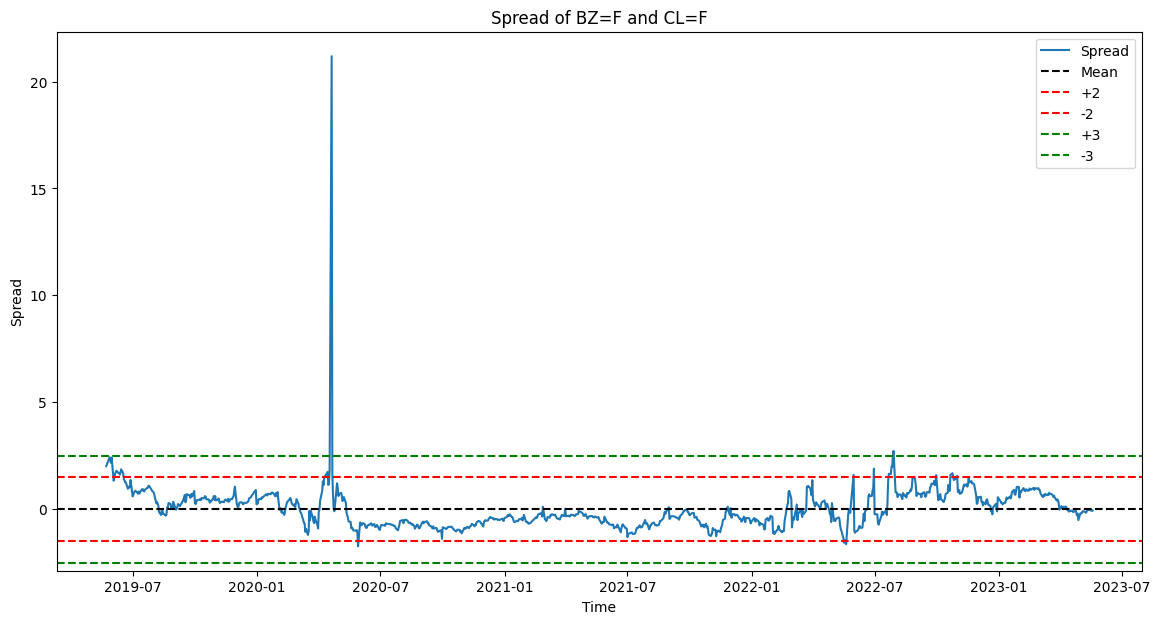

BZ=F/NG=F Hedge Ratio: 0.88


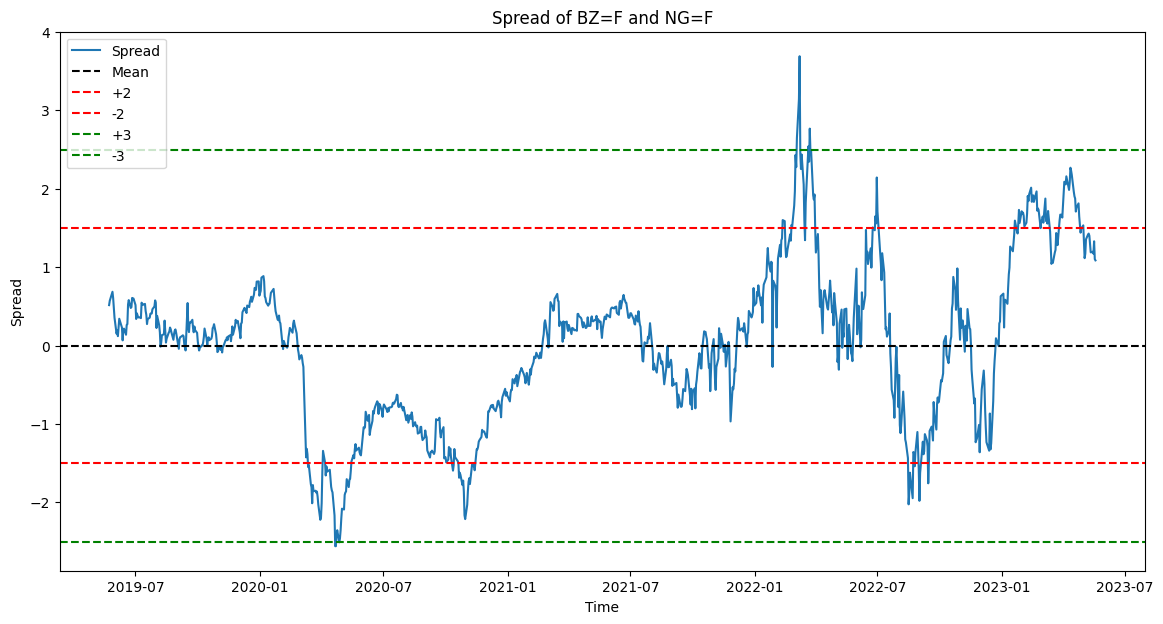

BZ=F/RB=F Hedge Ratio: 0.69


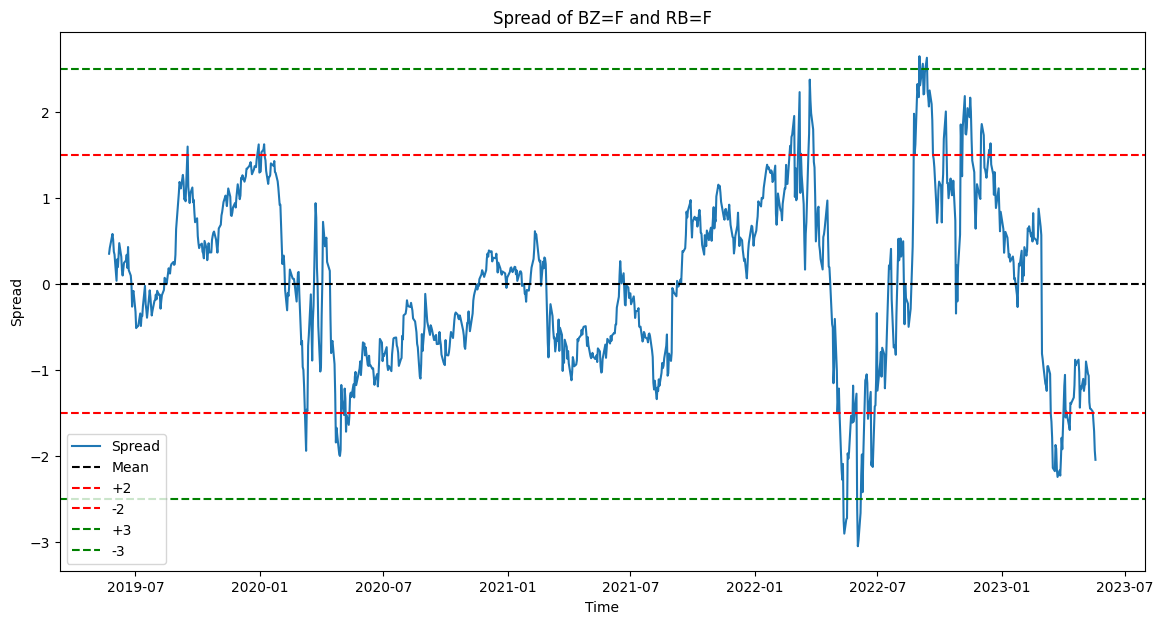

BZ=F/DBO Hedge Ratio: 6040.03


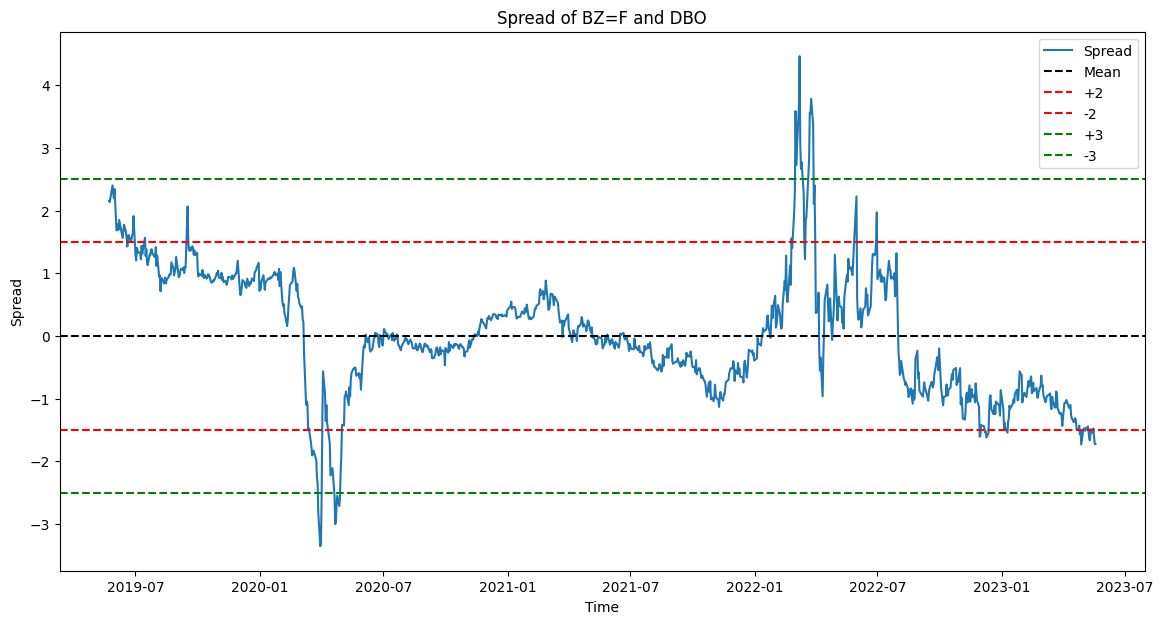

BZ=F/UNL Hedge Ratio: 3216.98


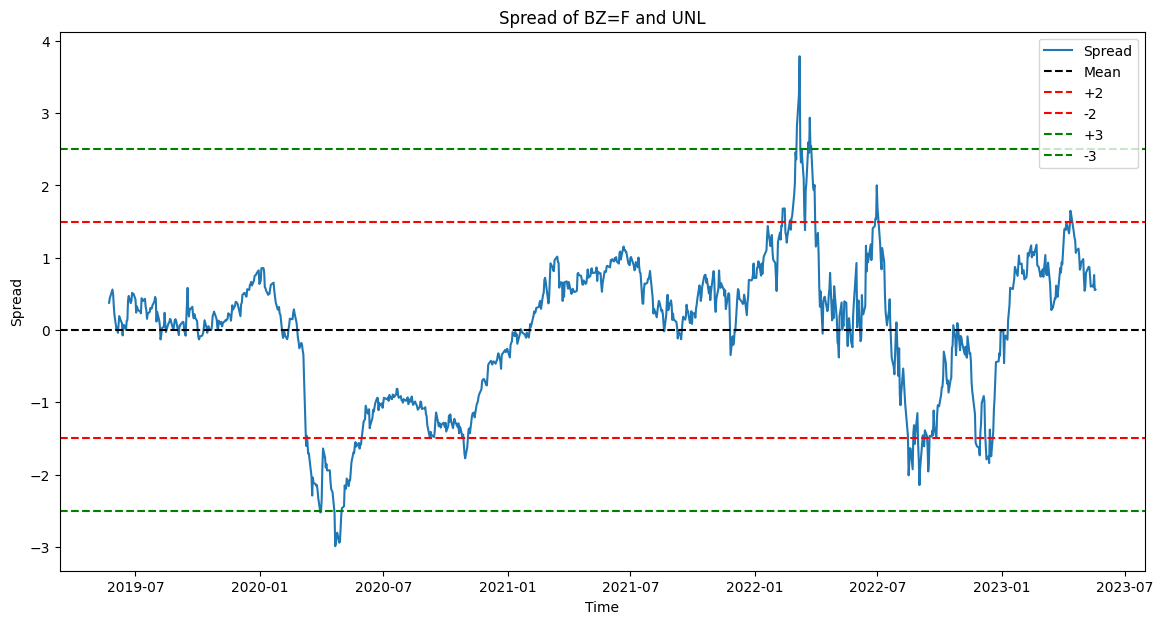

CL=F/HO=F Hedge Ratio: 0.54


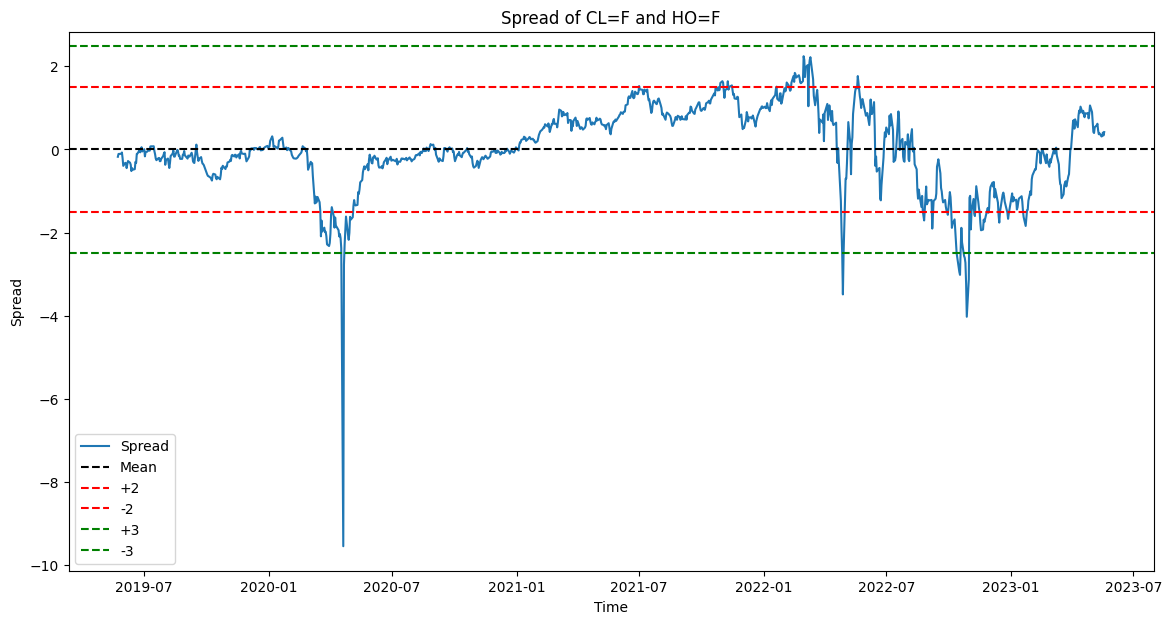

CL=F/RB=F Hedge Ratio: 0.69


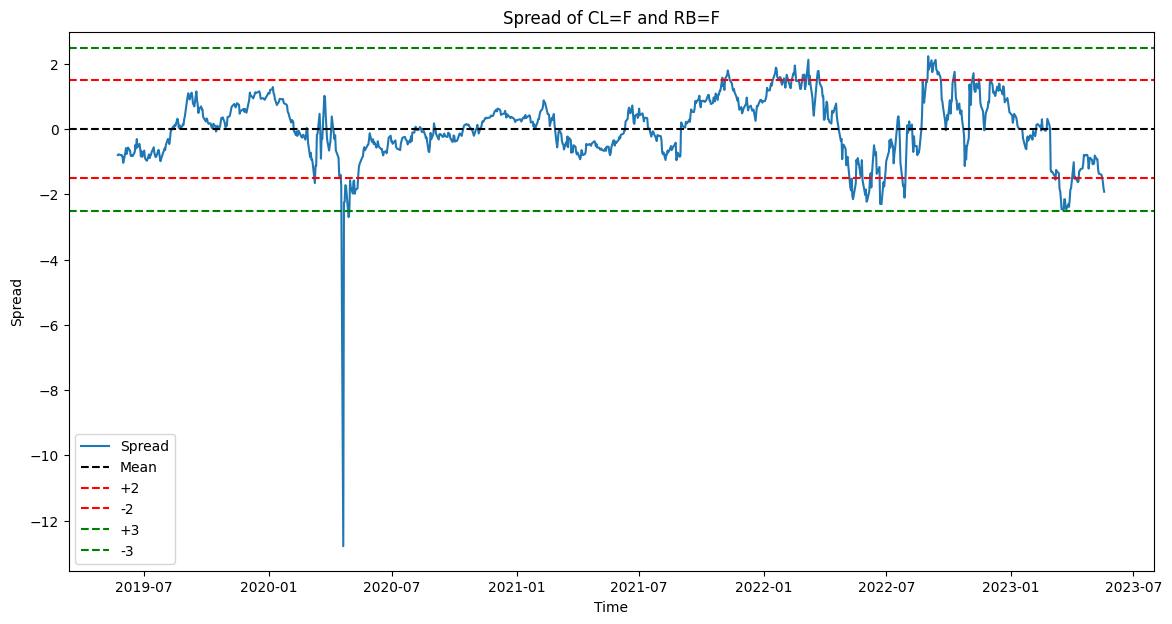

CL=F/DBO Hedge Ratio: 6012.70


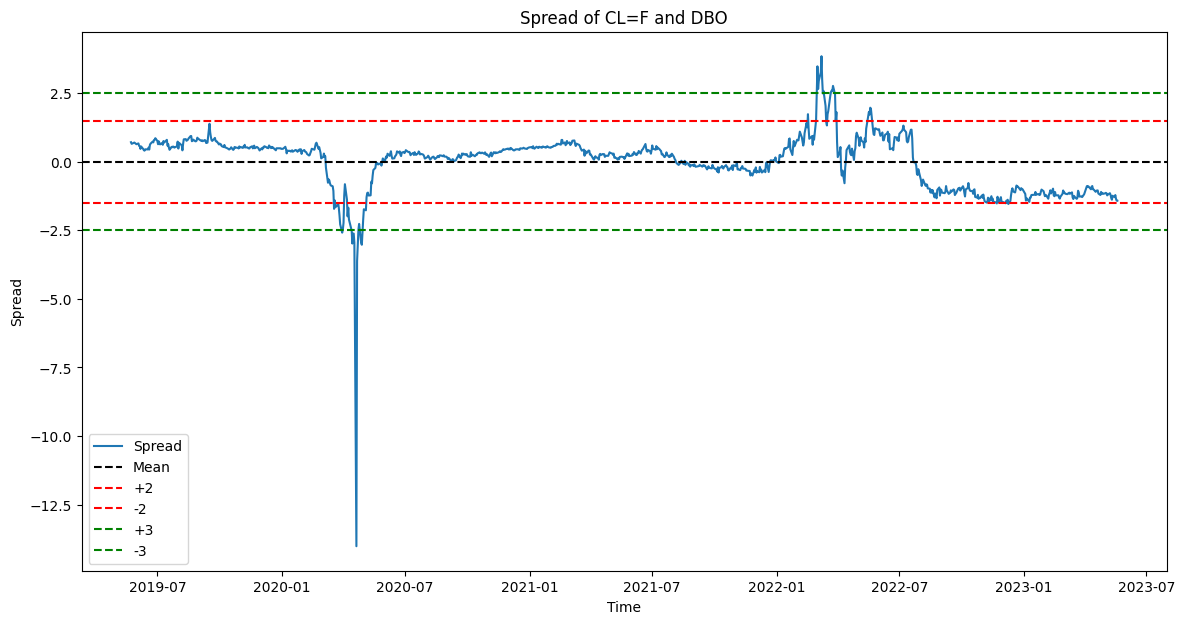

HO=F/DBE Hedge Ratio: 6995.08


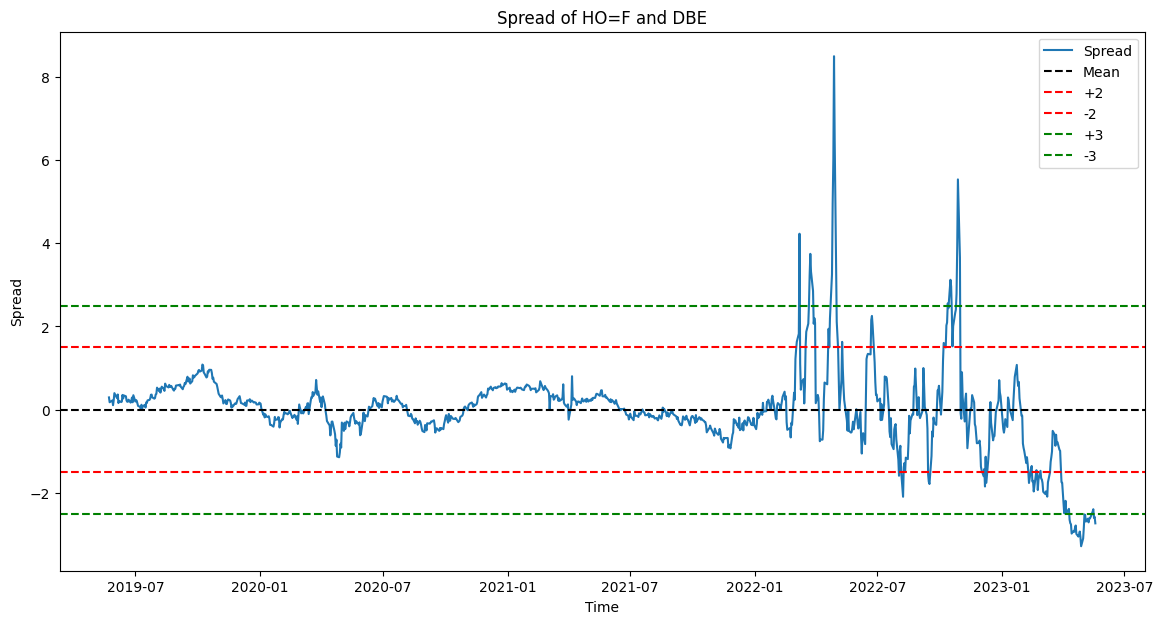

HO=F/UNL Hedge Ratio: 6120.71


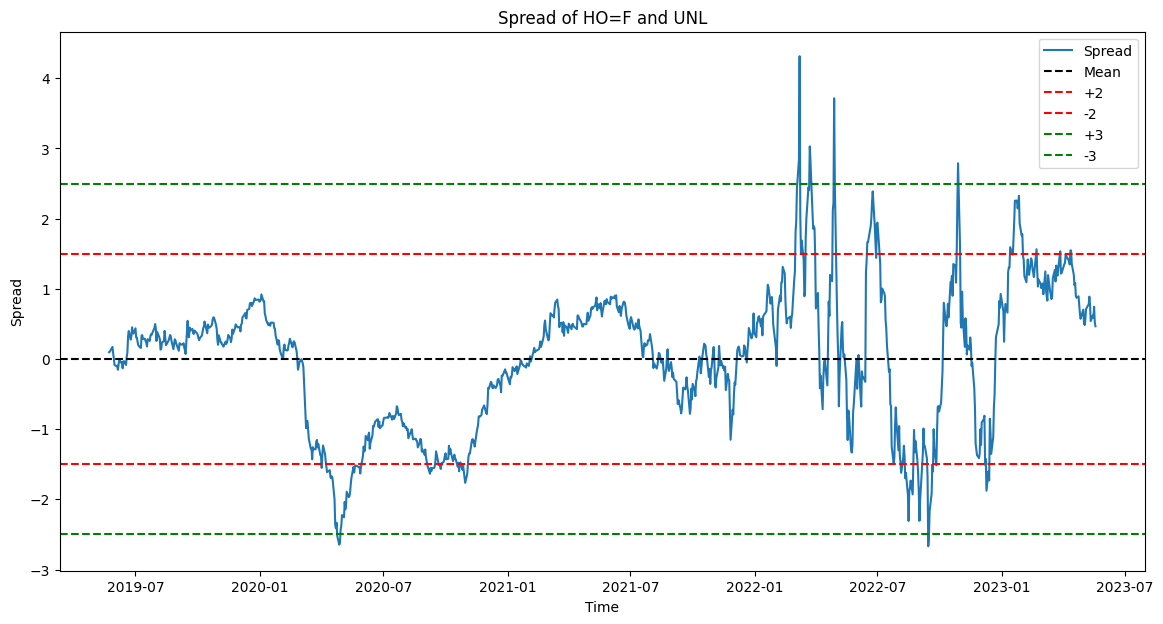

NG=F/BNO Hedge Ratio: 2070.29


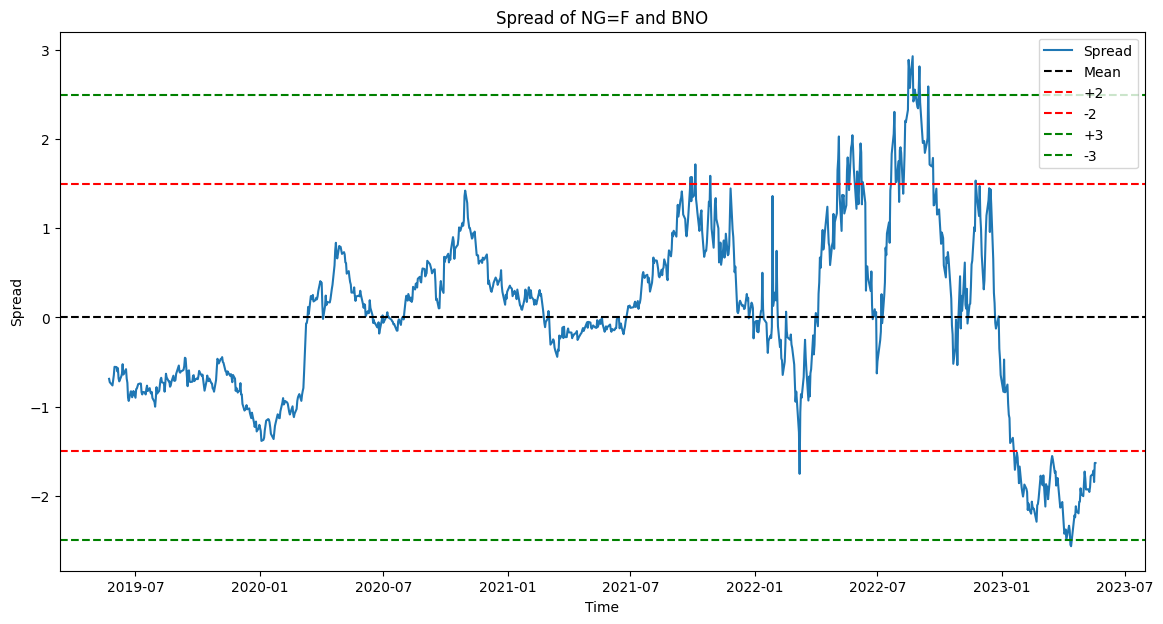

NG=F/DBE Hedge Ratio: 3022.54


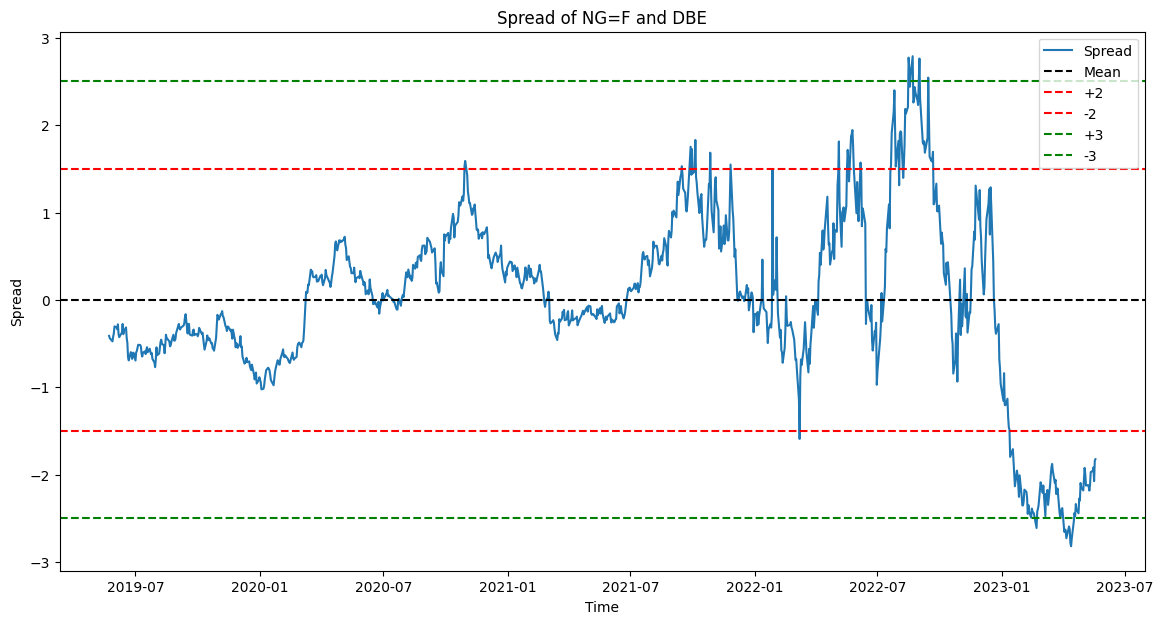

NG=F/DBO Hedge Ratio: 4506.97


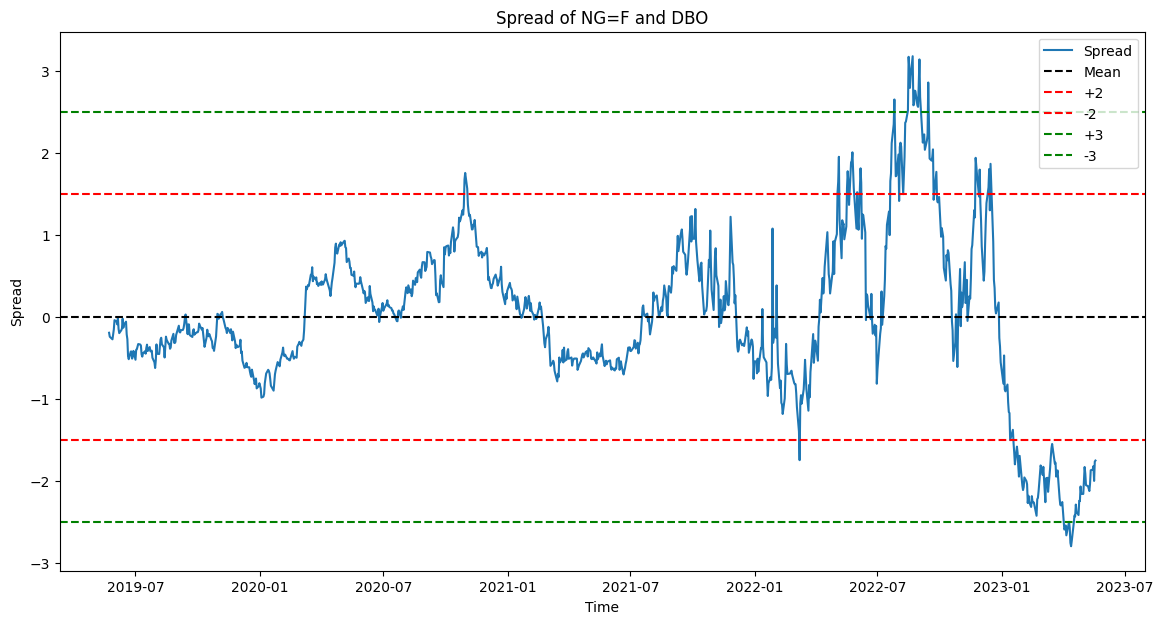

RB=F/DBO Hedge Ratio: 8405.44


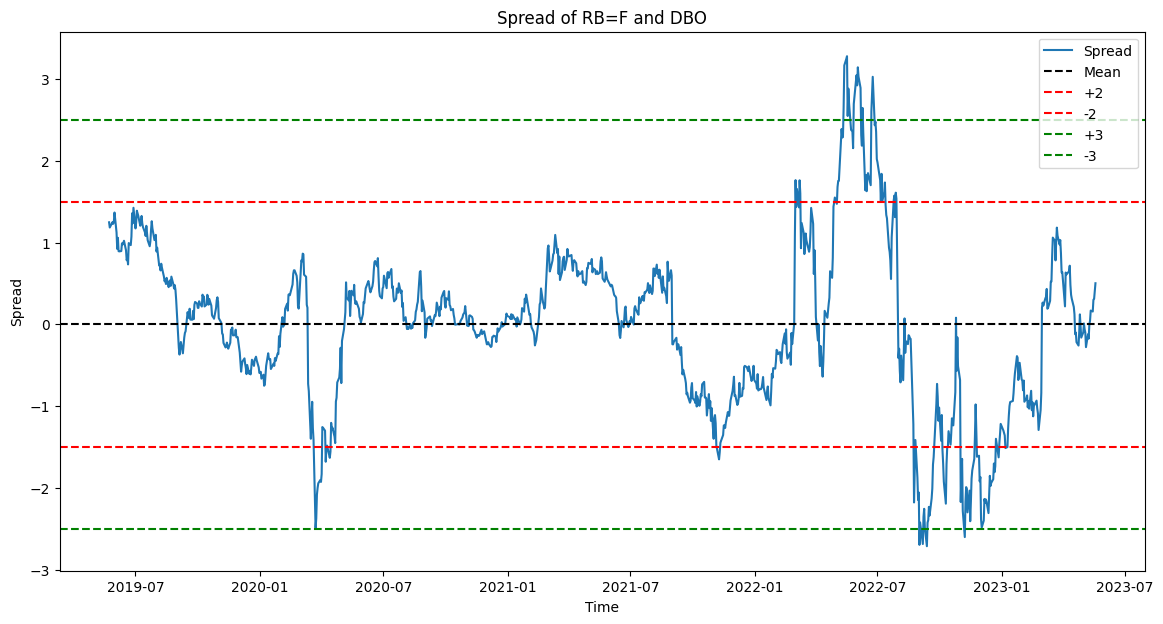

RB=F/USL Hedge Ratio: 3528.51


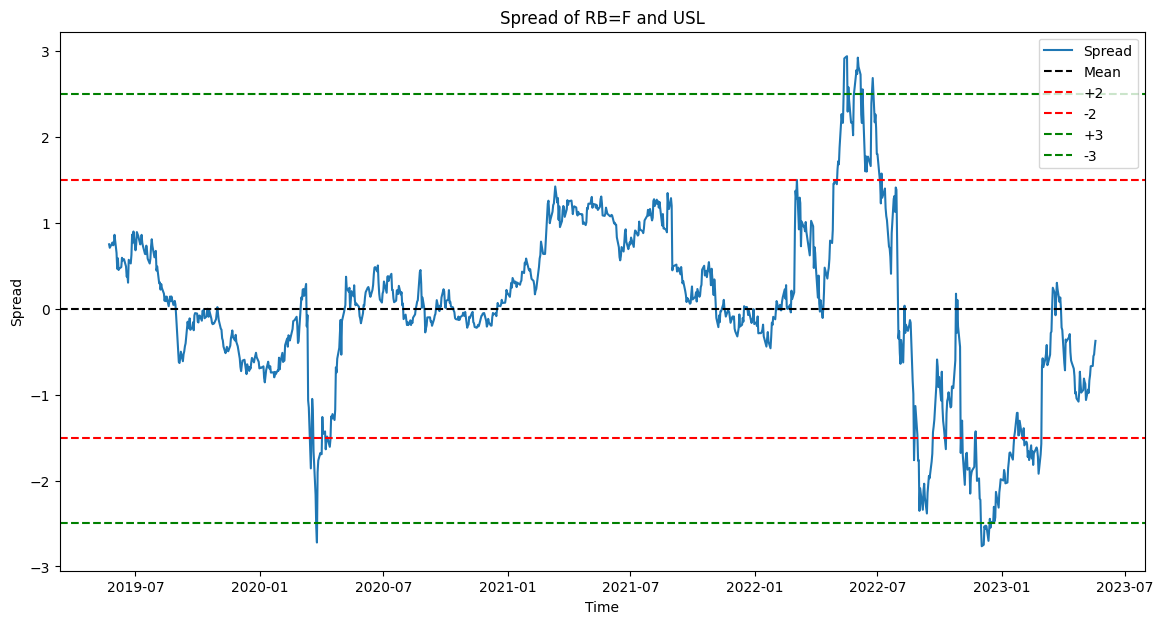

BNO/UNL Hedge Ratio: 1.06


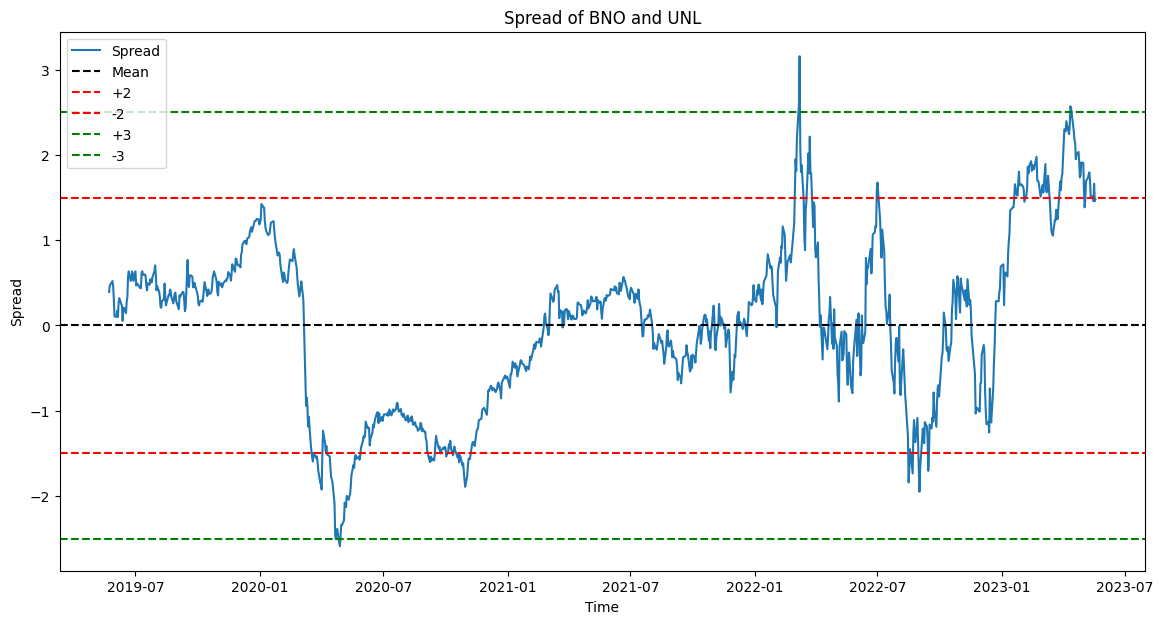

DBE/UNL Hedge Ratio: 0.86


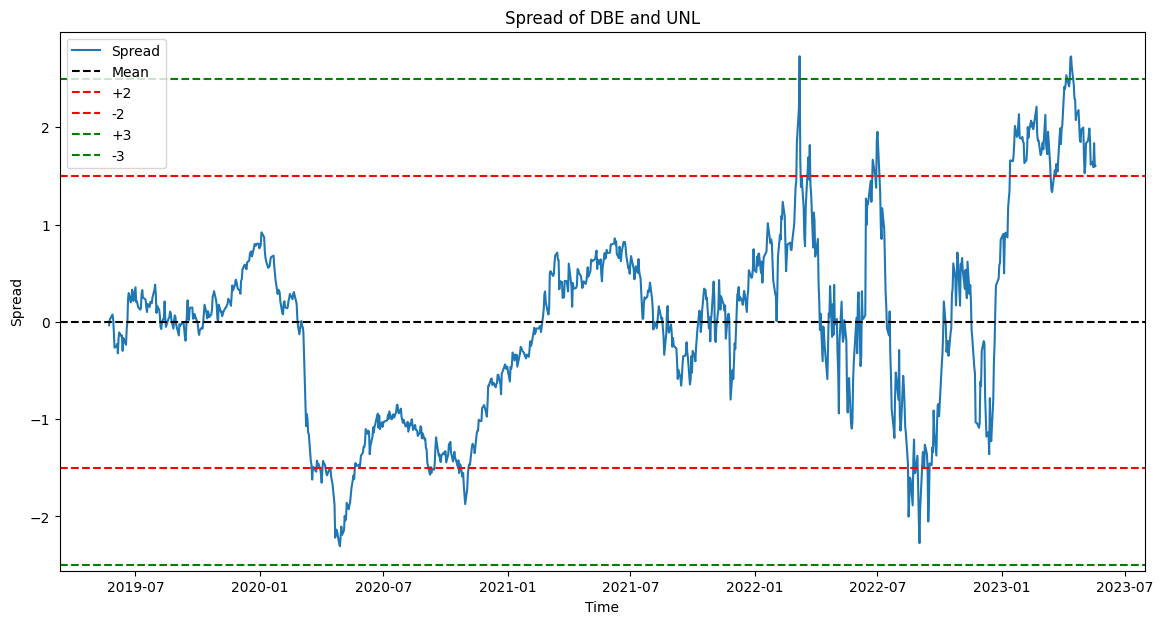

UNL/USL Hedge Ratio: 0.56


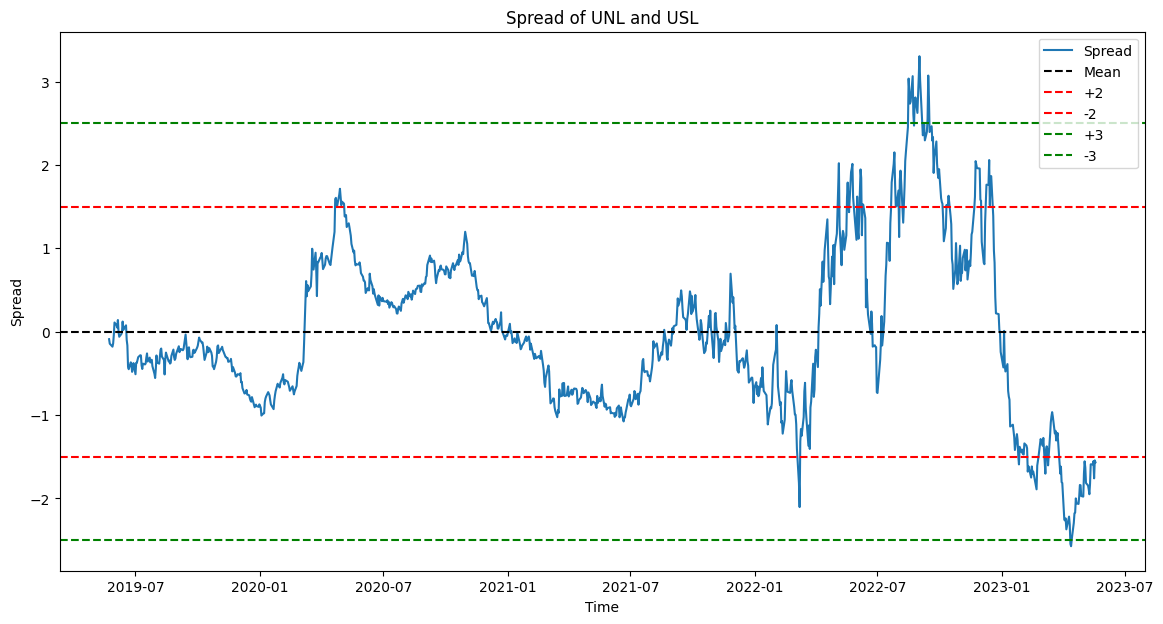

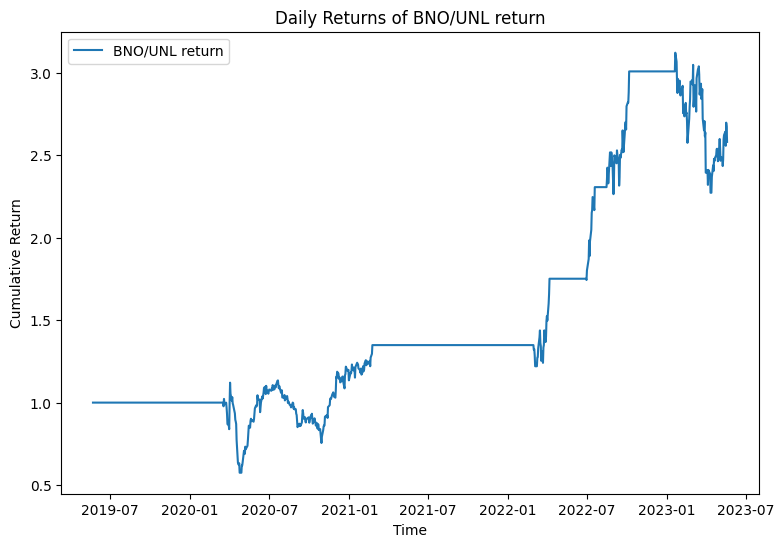

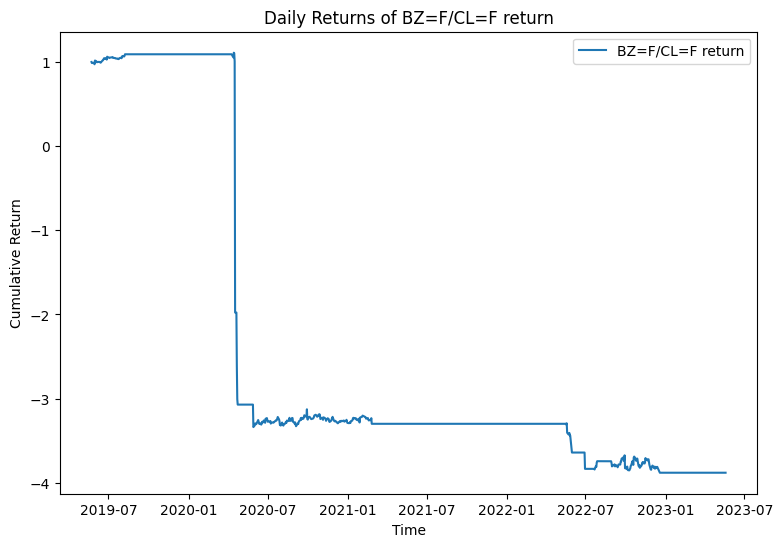

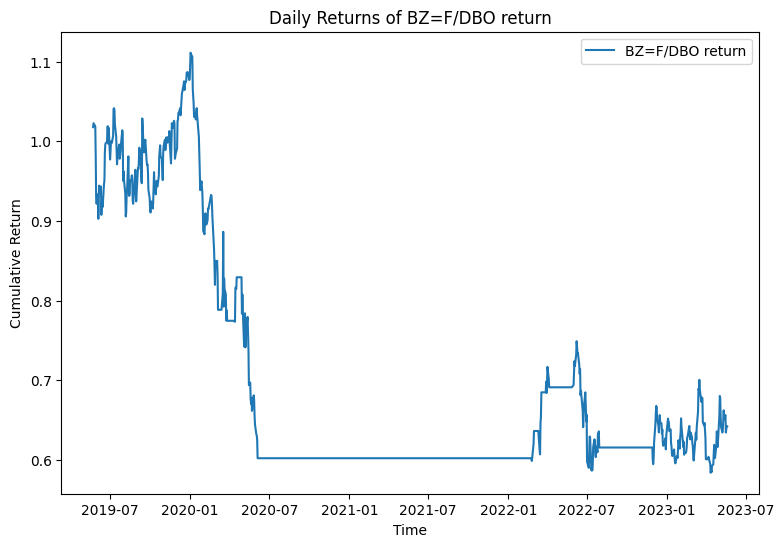

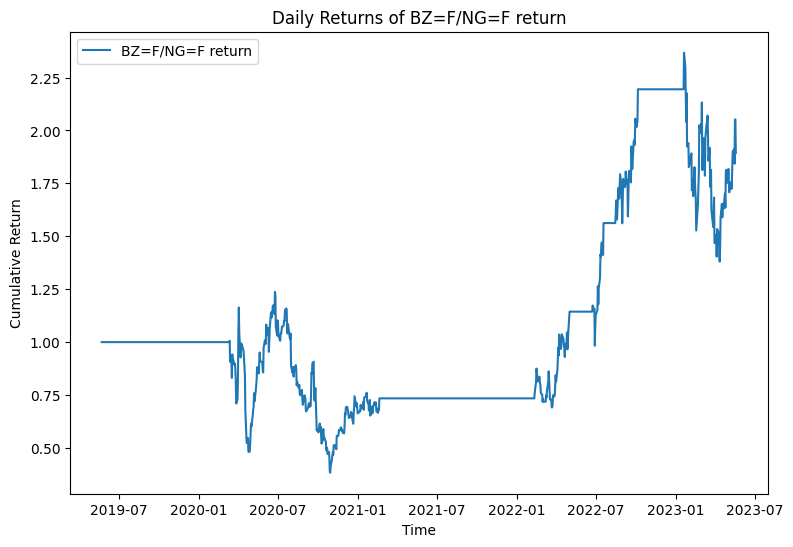

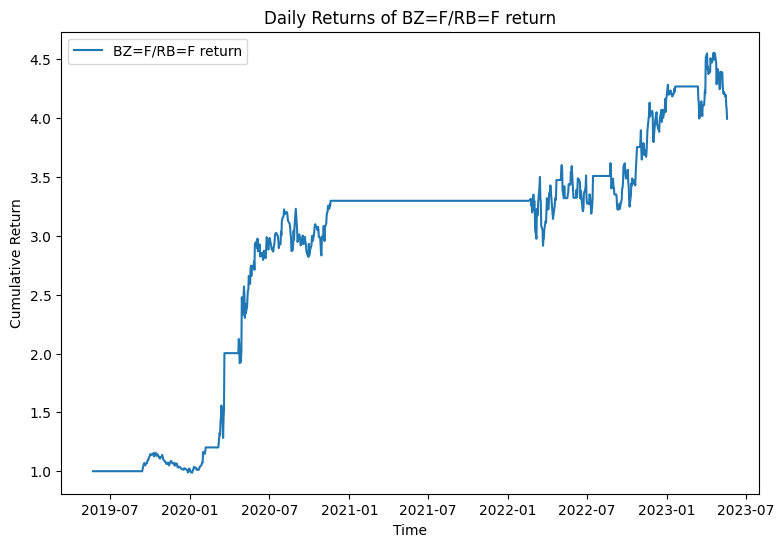

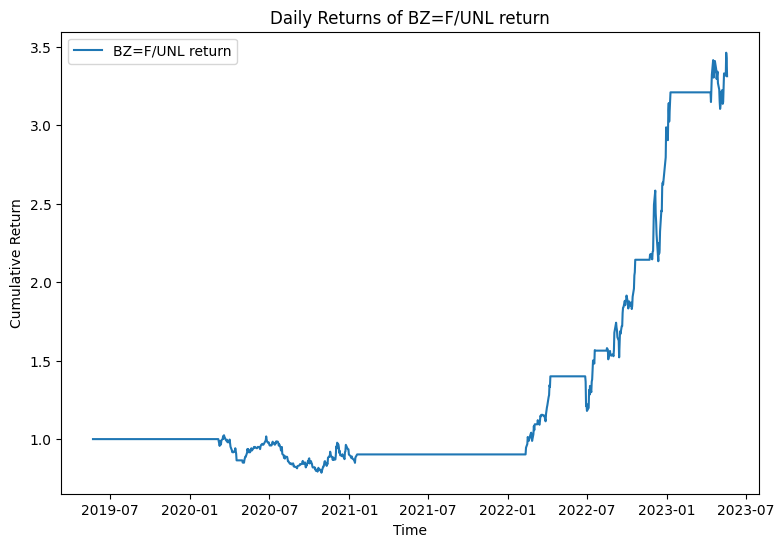

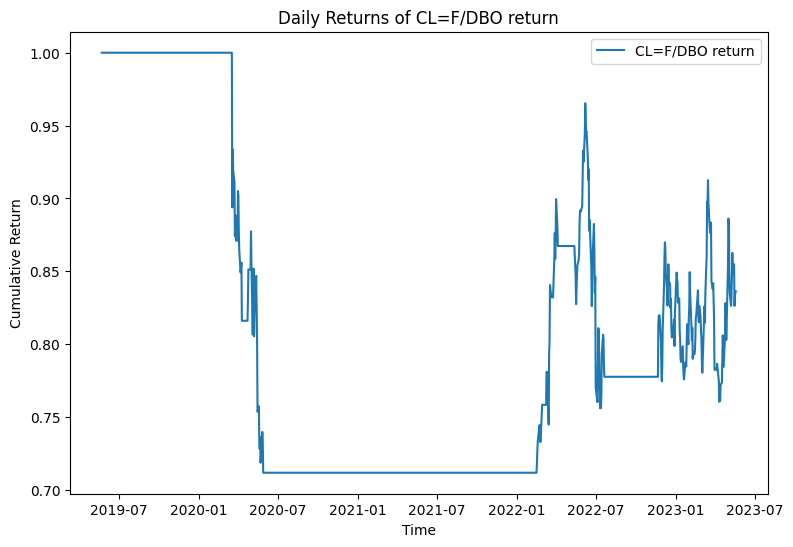

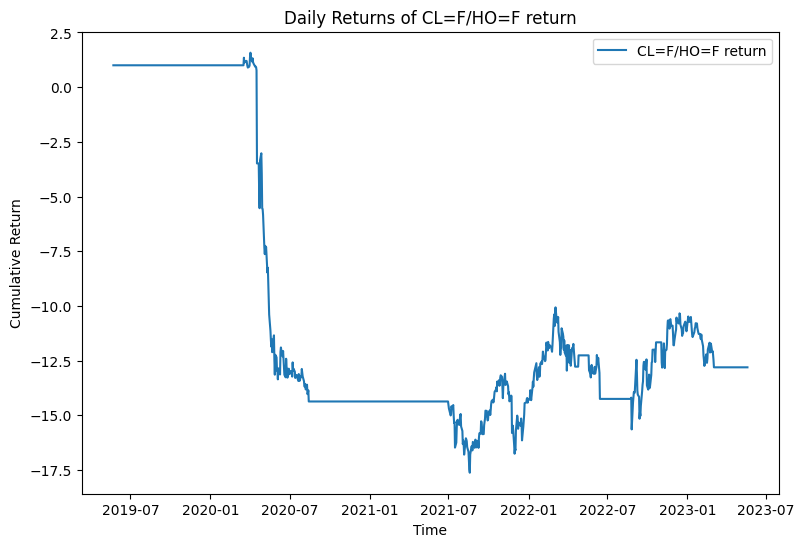

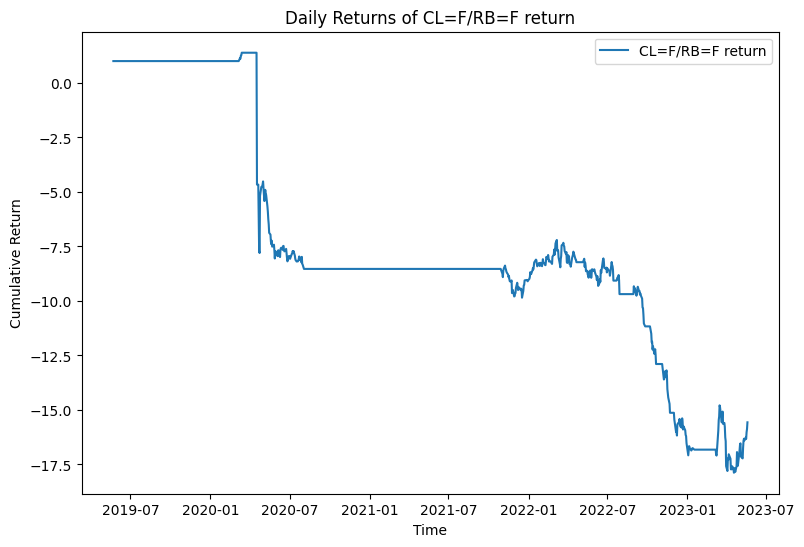

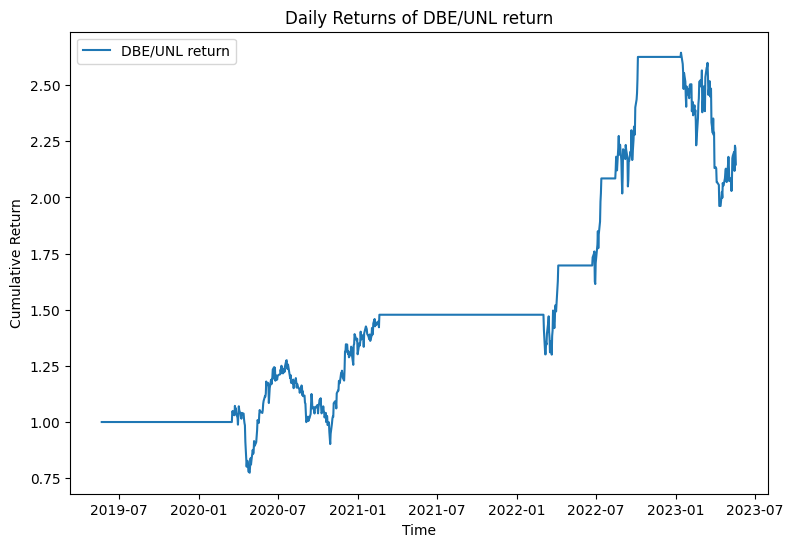

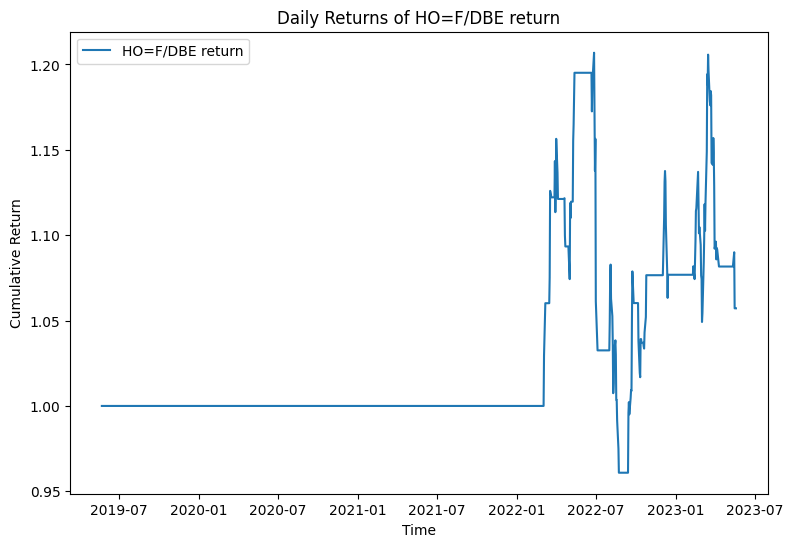

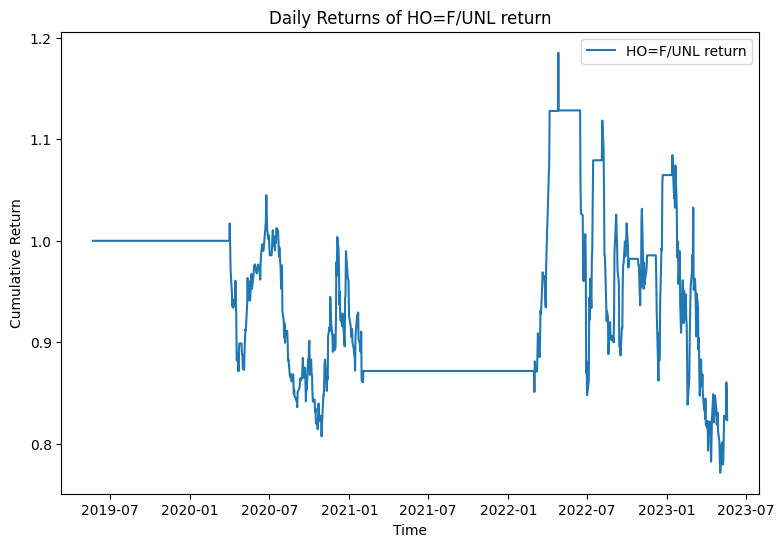

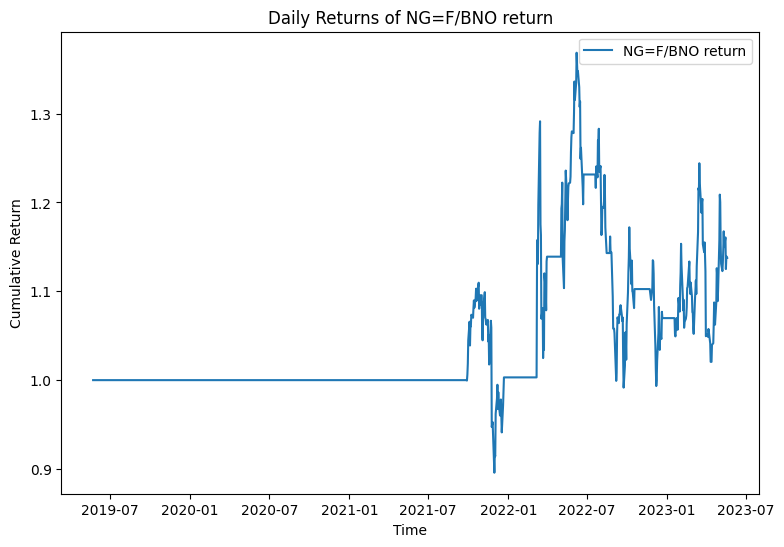

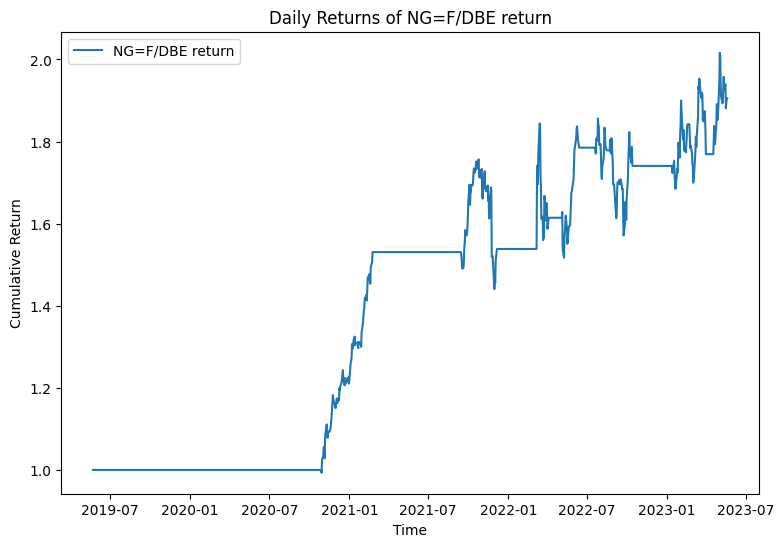

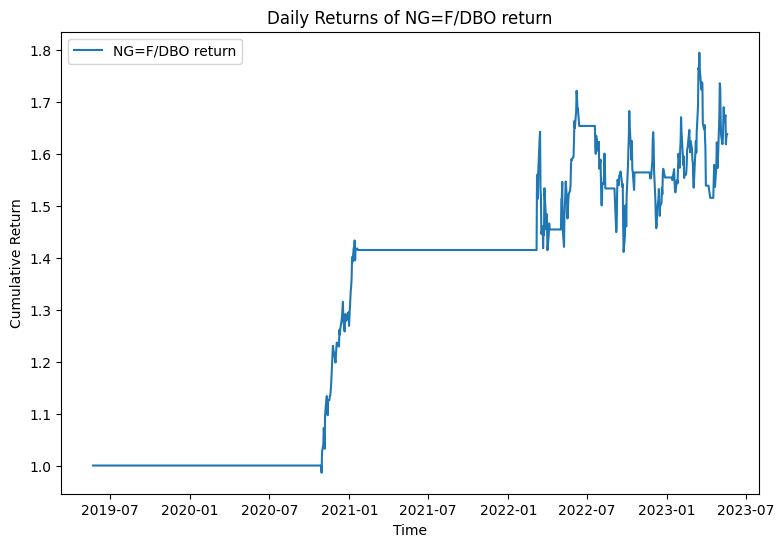

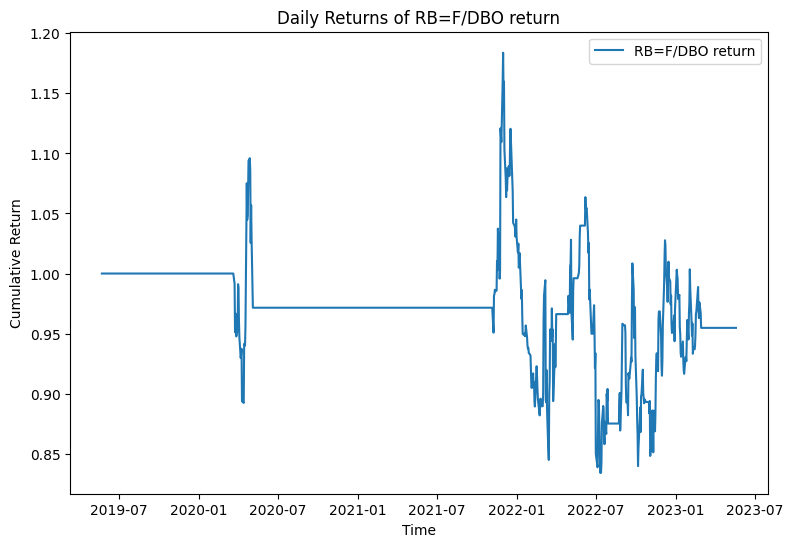

Exception ignored in: <function tqdm.__del__ at 0x000001D09A3A9120>
Traceback (most recent call last):
  File "c:\Users\darre\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\std.py", line 1148, in __del__
  File "c:\Users\darre\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\notebook.py", line 282, in close
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


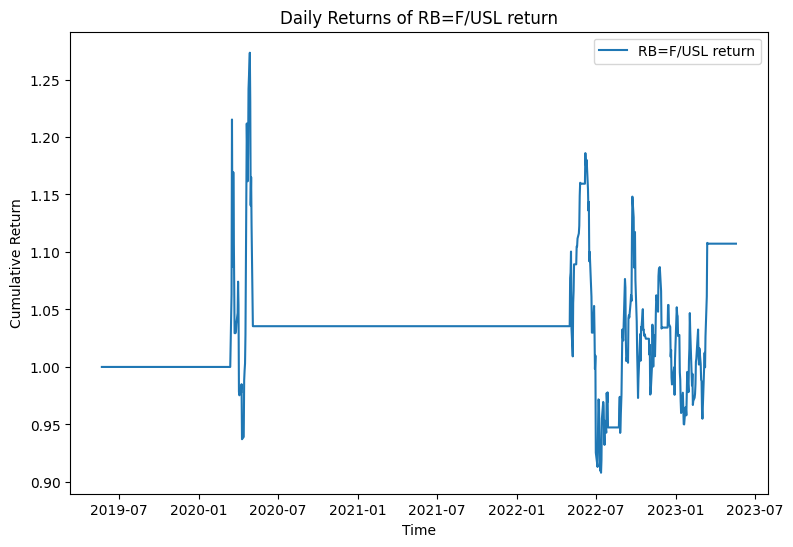

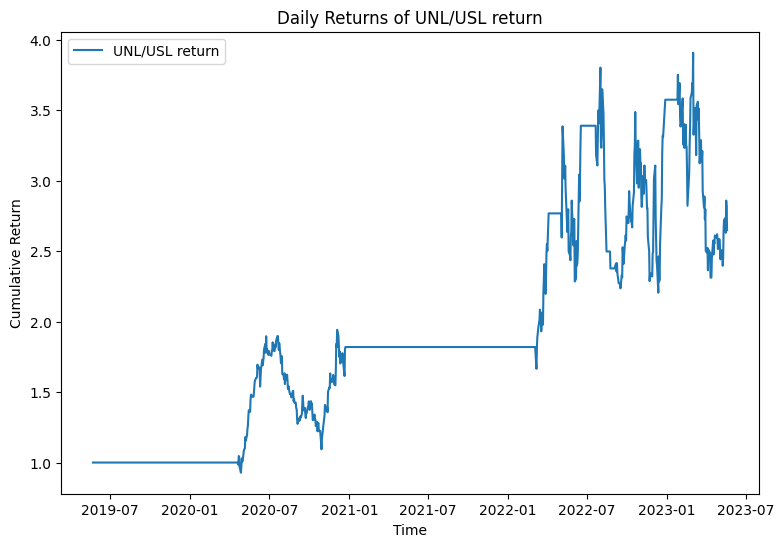

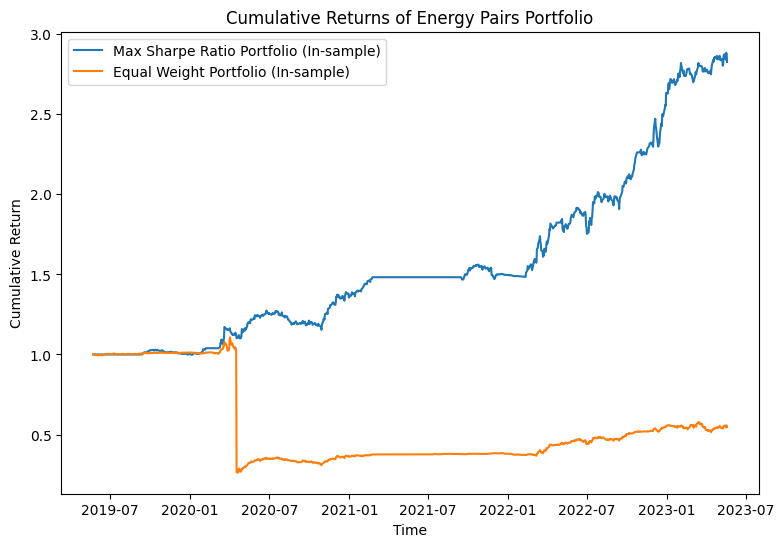


PERFORMANCE STATISTICS FOR Energy Pairs MAX SHARPE
Daily annualized sharpe: 2.1215267955854493
Average annual returns: 26.83127337421264%
Total returns: 107.11214688276951%
Max drawdown: -9.692723498083119%

PERFORMANCE STATISTICS FOR Energy Pairs EQUAL WEIGHTS
Daily annualized sharpe: 0.022252560155224463
Average annual returns: 0.8736356070779734%
Total returns: 3.487608812382703%
Max drawdown: -83.51502094865668%


In [79]:
is_returns_sharpe, is_returns_equal = backtest(energy_data_is, 1.5, 2.5, 'Energy Pairs')

Pair: (BZ=F, CL=F) - R-squared: 0.9847707702014177, p-value: 3.1549816344276415e-06
Pair: (BZ=F, NG=F) - R-squared: 0.6231536248510741, p-value: 0.010442642431772156
Pair: (BZ=F, RB=F) - R-squared: 0.9539057975931339, p-value: 0.006594002443001353
Pair: (BZ=F, DBO) - R-squared: 0.9627512873657074, p-value: 0.03936859854339734
Pair: (BZ=F, UNL) - R-squared: 0.6565620245780157, p-value: 0.016092235196480675
Pair: (CL=F, HO=F) - R-squared: 0.8836724348393492, p-value: 0.023487798885470878
Pair: (CL=F, RB=F) - R-squared: 0.9501608566462174, p-value: 0.0009608812294029536
Pair: (CL=F, DBO) - R-squared: 0.949405552771246, p-value: 0.025316329039821953
Pair: (HO=F, DBE) - R-squared: 0.9670604455768879, p-value: 0.044620174757429104
Pair: (HO=F, UNL) - R-squared: 0.7928755339413406, p-value: 0.011648500585617552
Pair: (NG=F, BNO) - R-squared: 0.5498911017961372, p-value: 0.034843603872951906
Pair: (NG=F, DBE) - R-squared: 0.6660321701446783, p-value: 0.04976989784125948
Pair: (NG=F, DBO) - R-s

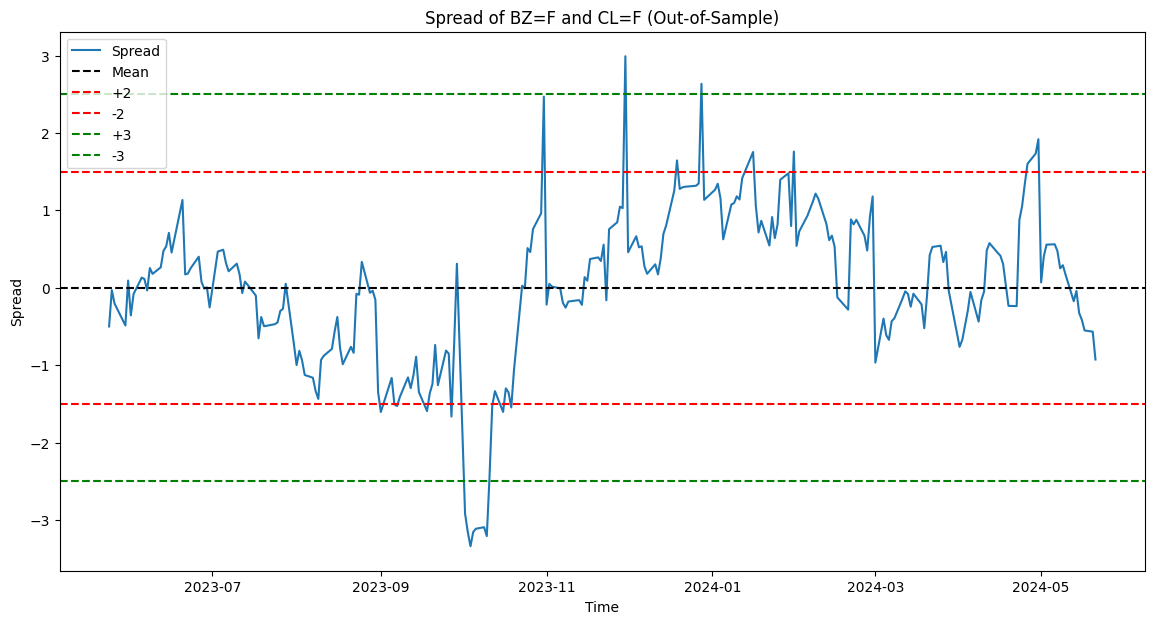

BZ=F/NG=F Hedge Ratio: 0.88


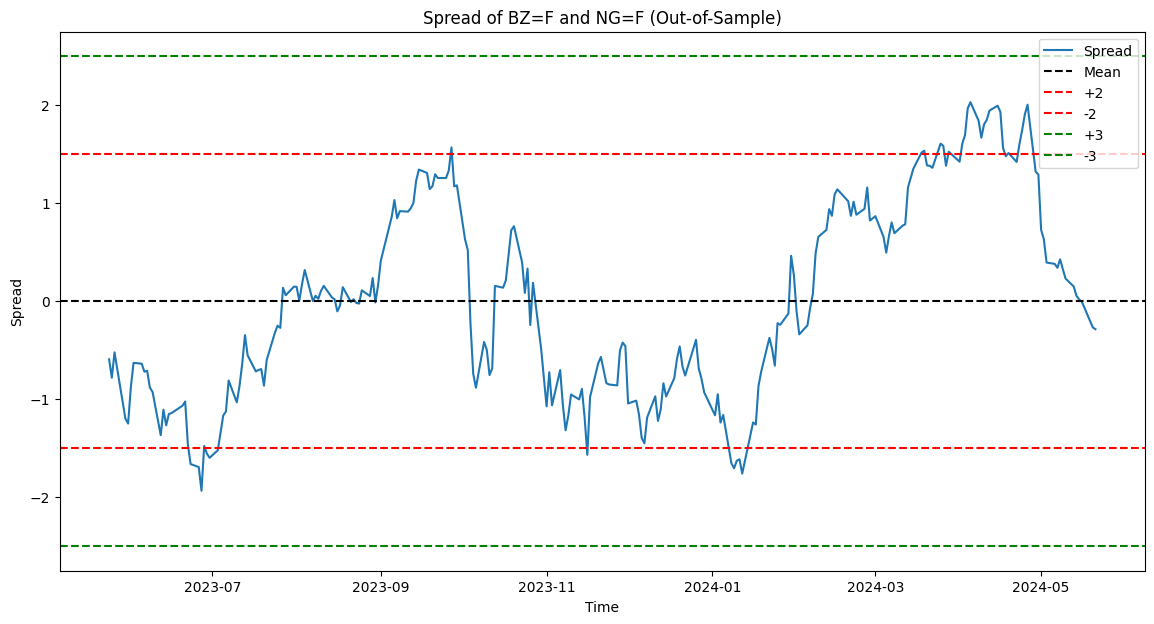

BZ=F/RB=F Hedge Ratio: 0.69


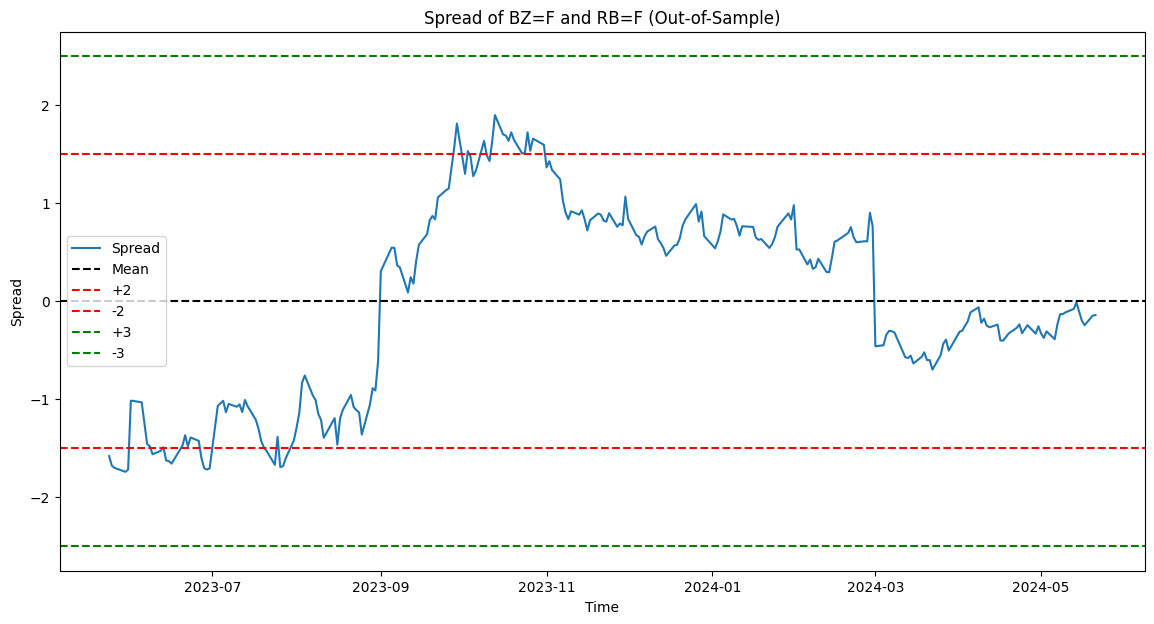

BZ=F/DBO Hedge Ratio: 6040.03


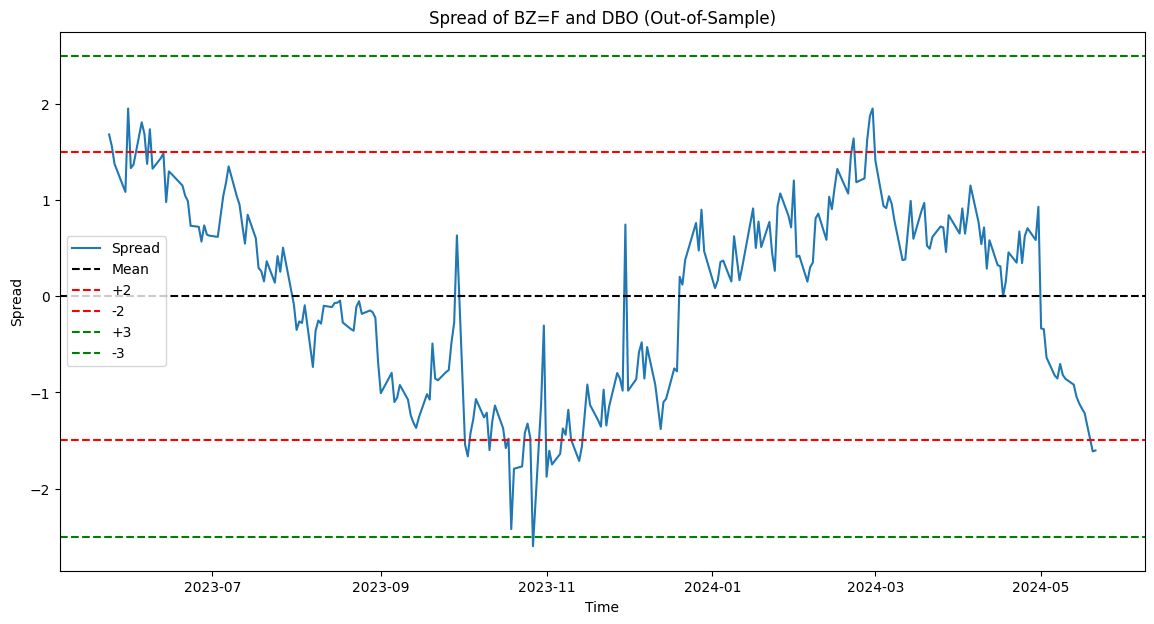

BZ=F/UNL Hedge Ratio: 3216.98


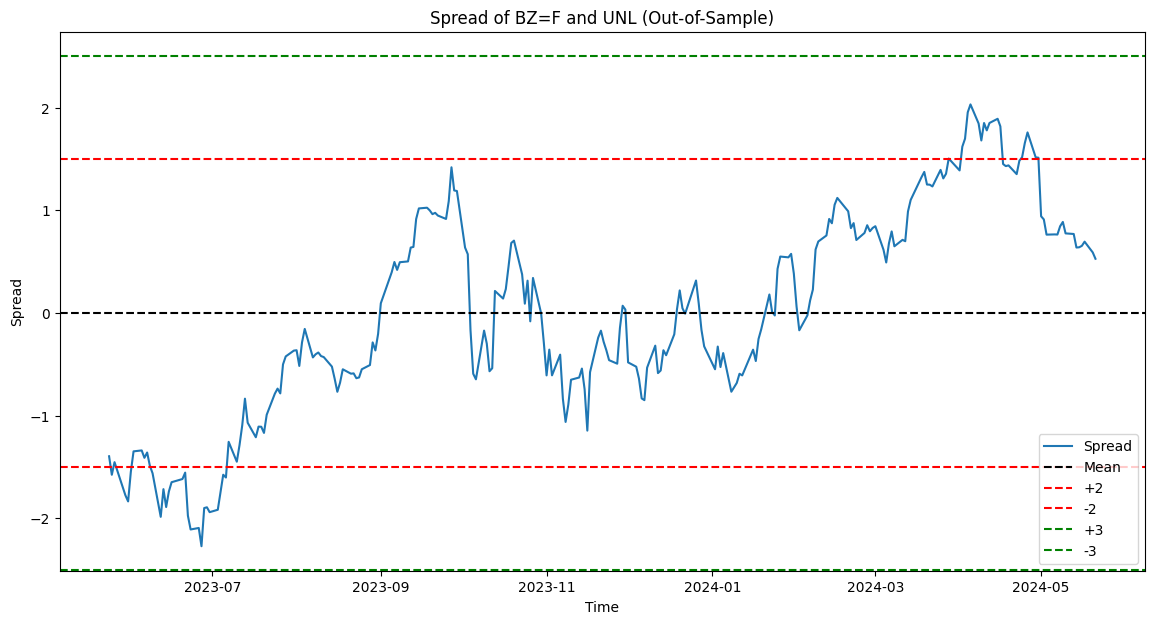

CL=F/HO=F Hedge Ratio: 0.54


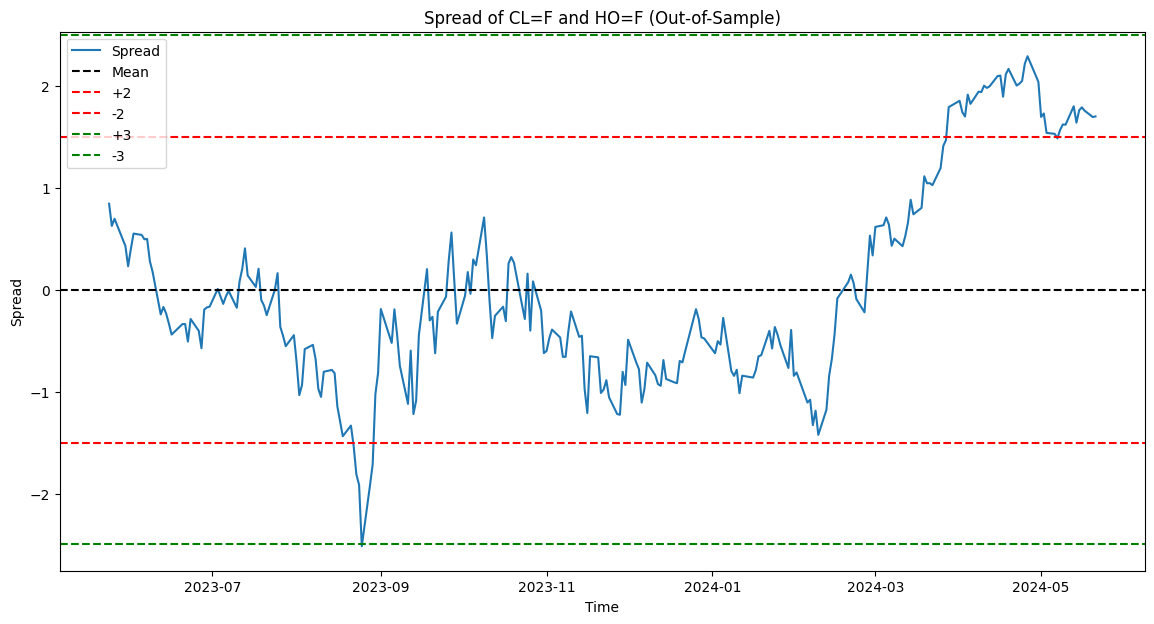

CL=F/RB=F Hedge Ratio: 0.69


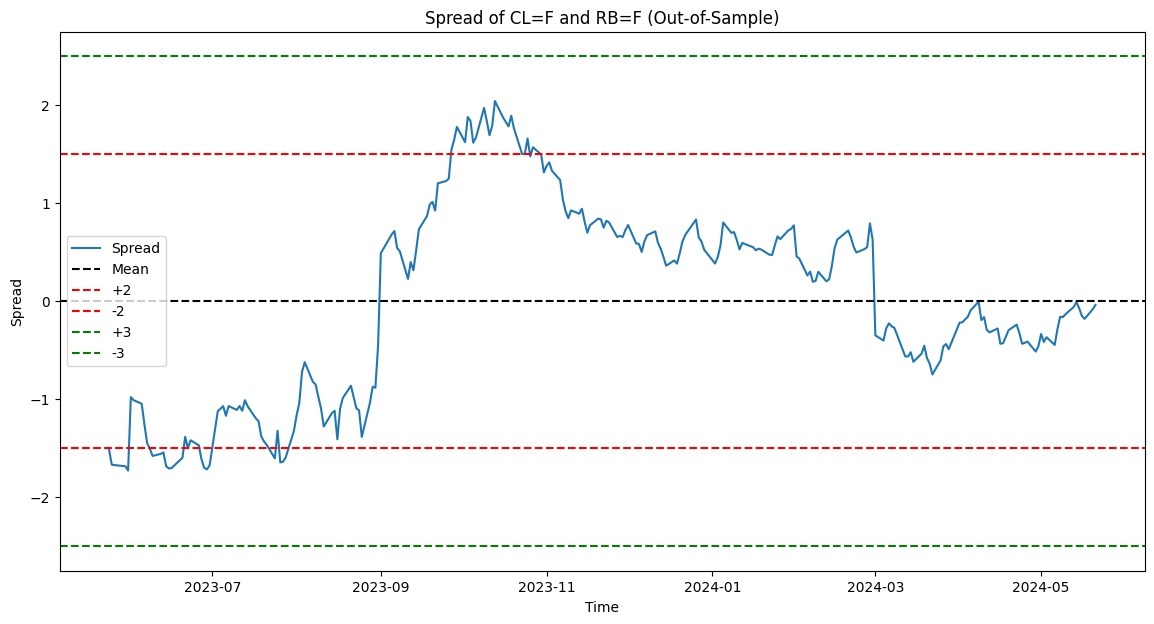

CL=F/DBO Hedge Ratio: 6012.70


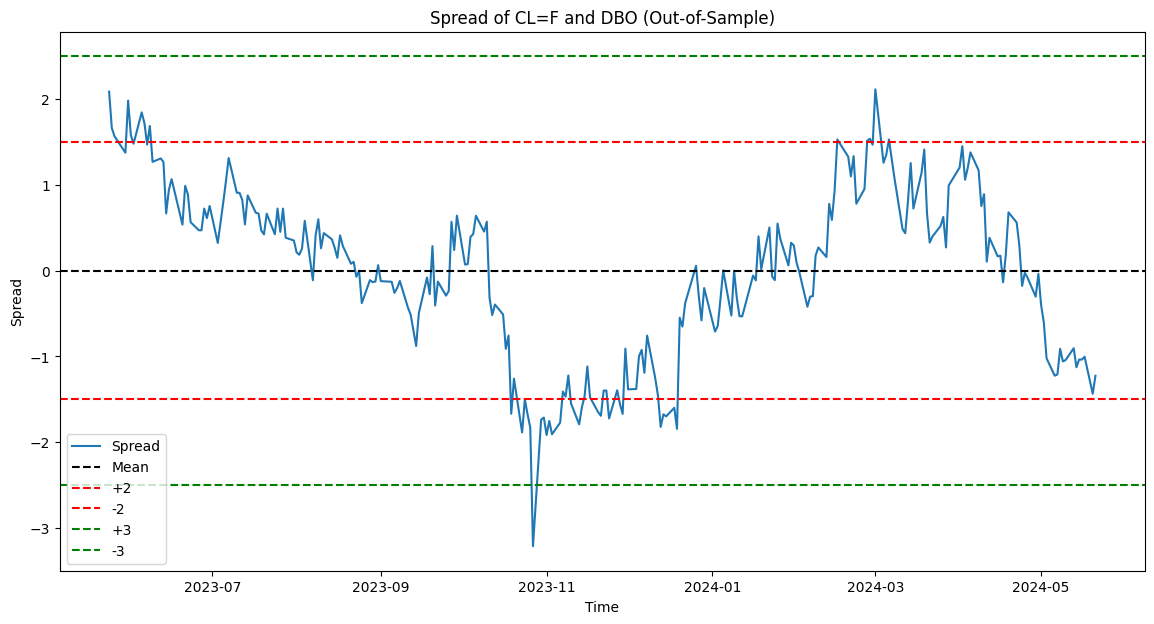

HO=F/DBE Hedge Ratio: 6995.08


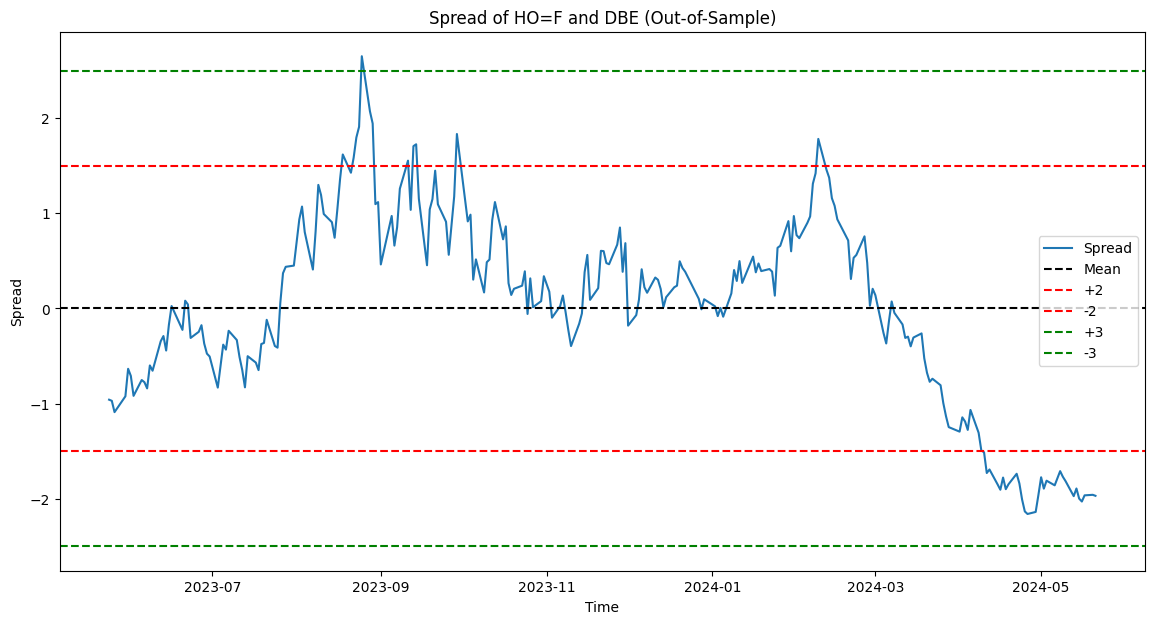

HO=F/UNL Hedge Ratio: 6120.71


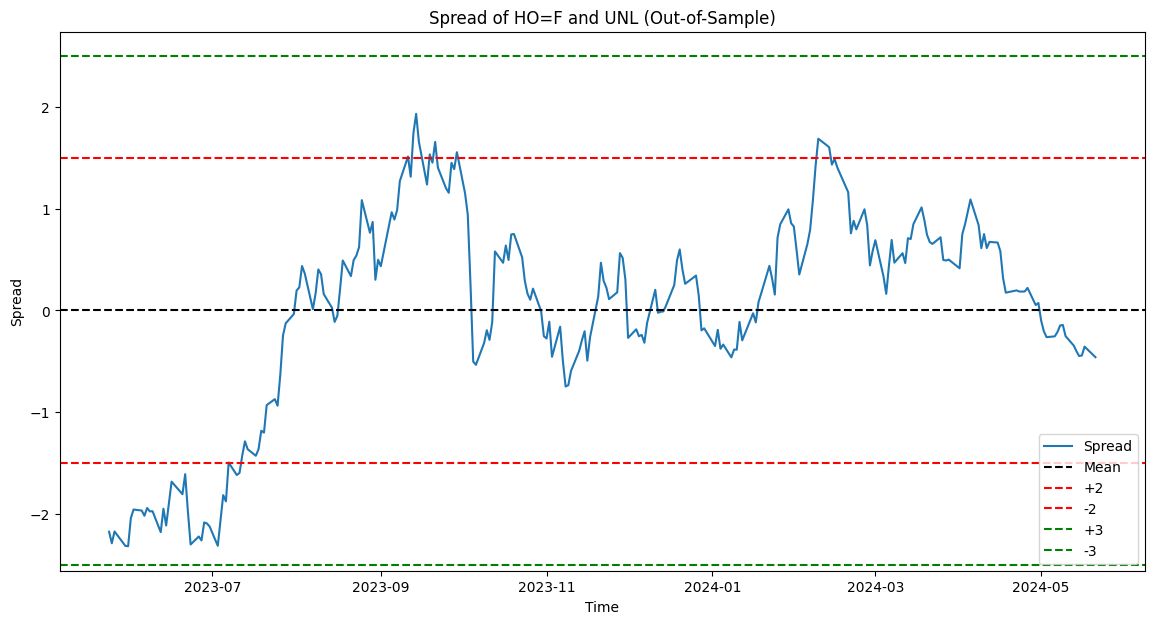

NG=F/BNO Hedge Ratio: 2070.29


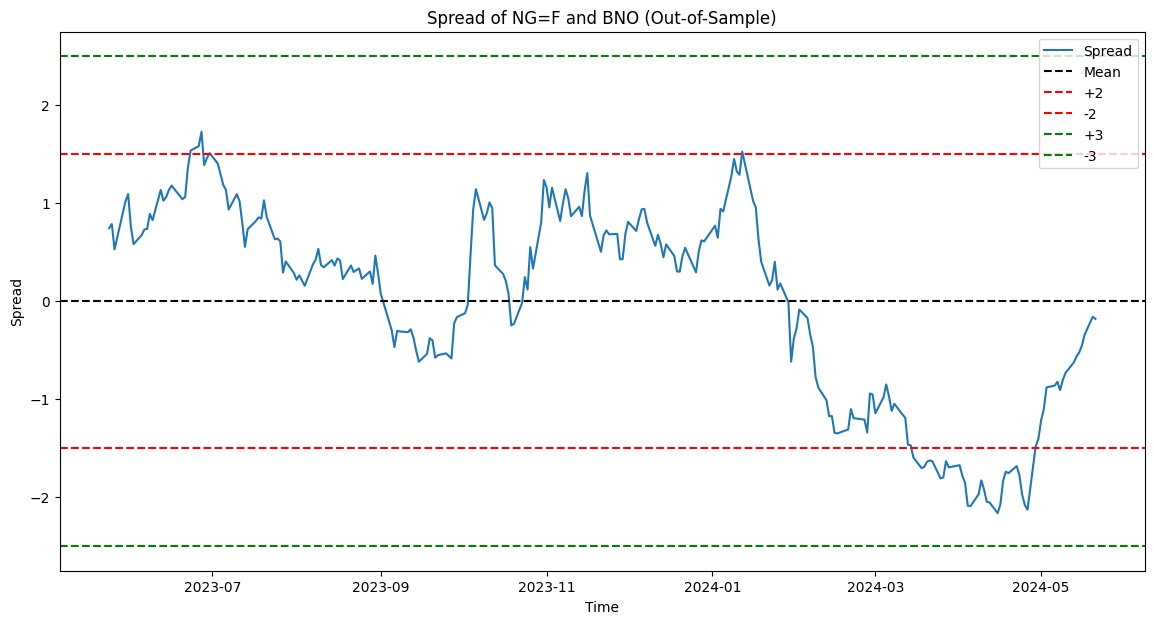

NG=F/DBE Hedge Ratio: 3022.54


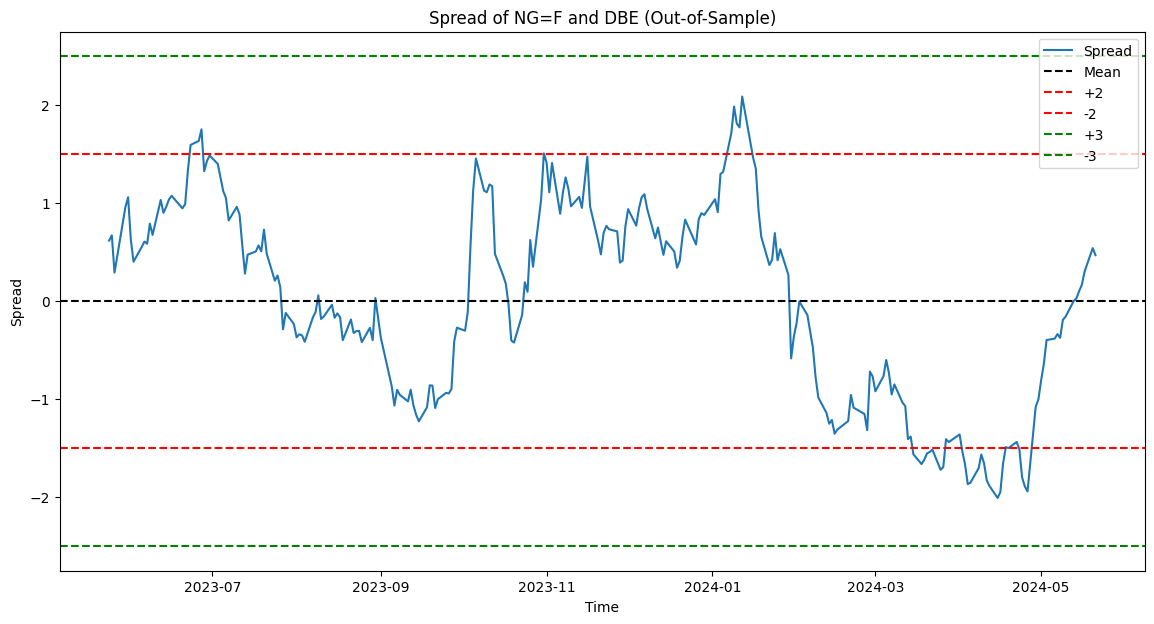

NG=F/DBO Hedge Ratio: 4506.97


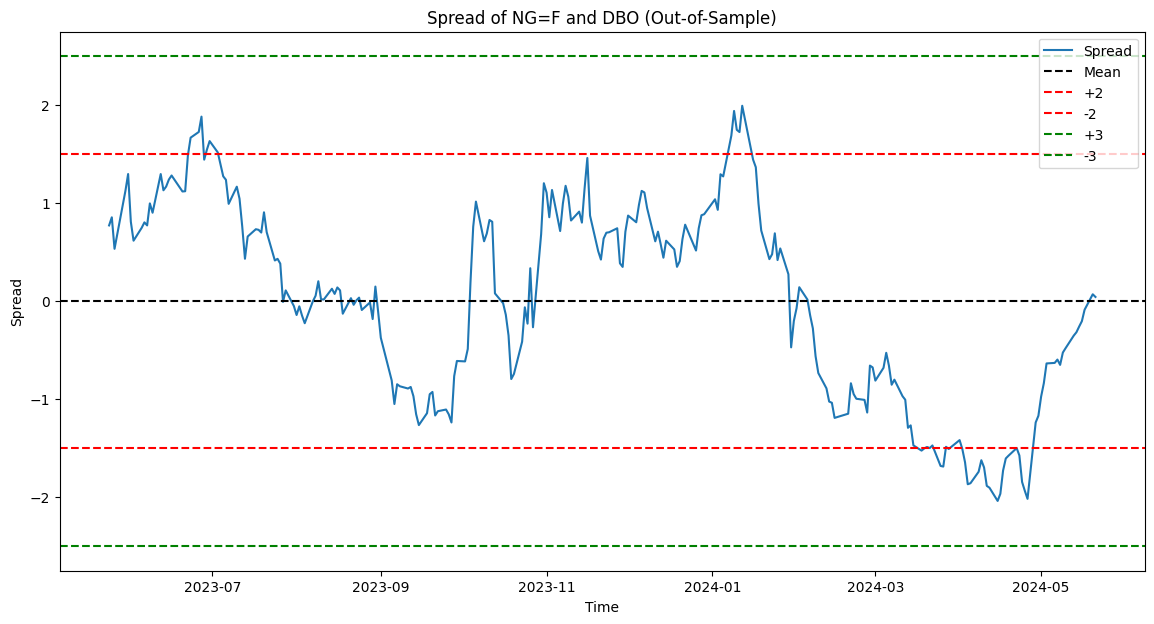

RB=F/DBO Hedge Ratio: 8405.44


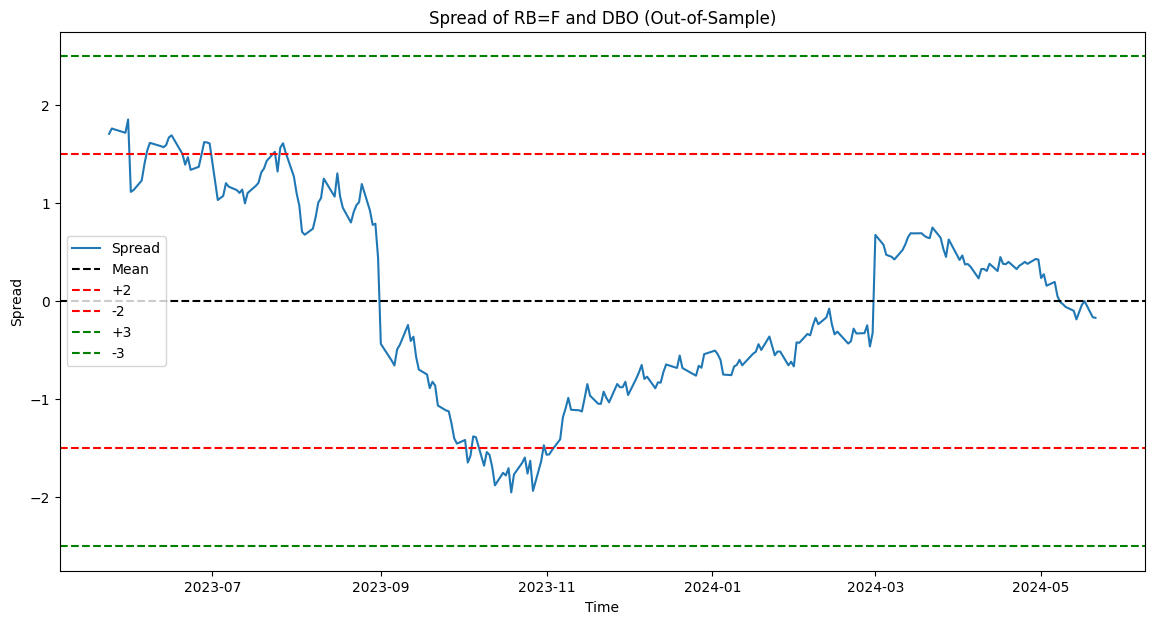

RB=F/USL Hedge Ratio: 3528.51


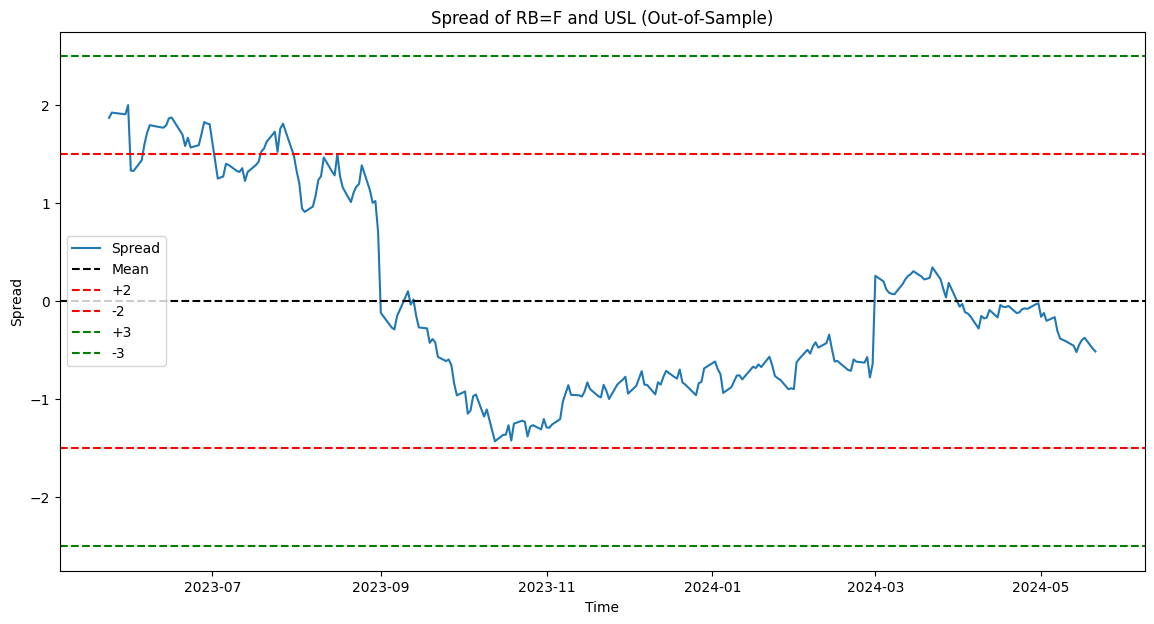

BNO/UNL Hedge Ratio: 1.06


Exception ignored in: <function tqdm.__del__ at 0x000001D09A3A9120>
Traceback (most recent call last):
  File "c:\Users\darre\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\darre\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x000001D09A3A9120>
Traceback (most recent call last):
  File "c:\Users\darre\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\darre\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


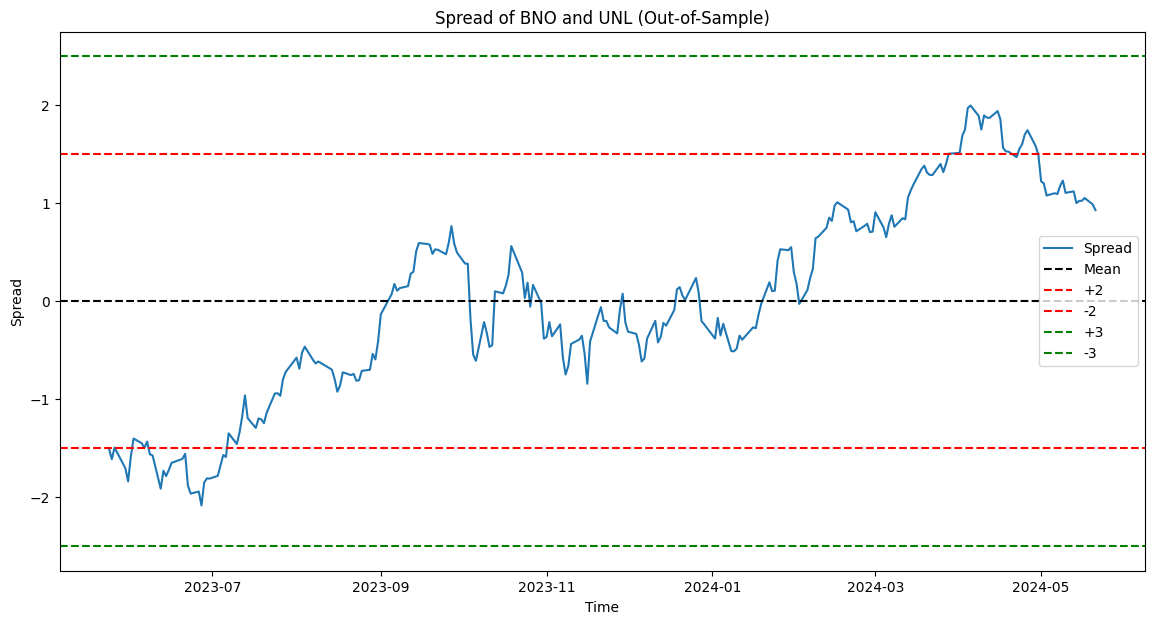

DBE/UNL Hedge Ratio: 0.86


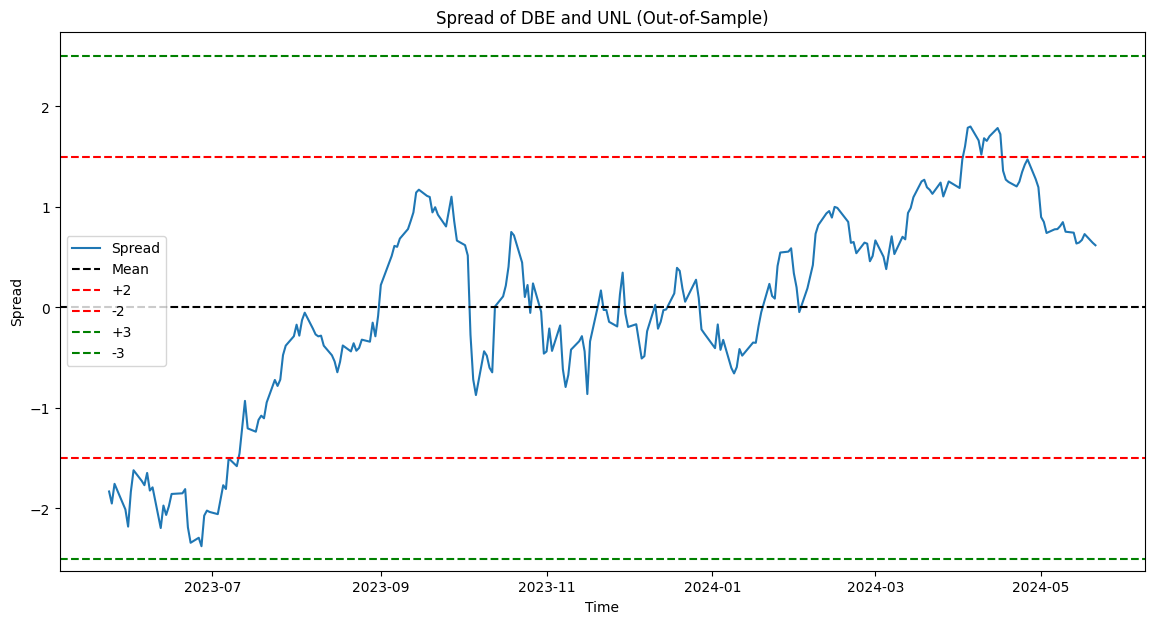

UNL/USL Hedge Ratio: 0.56


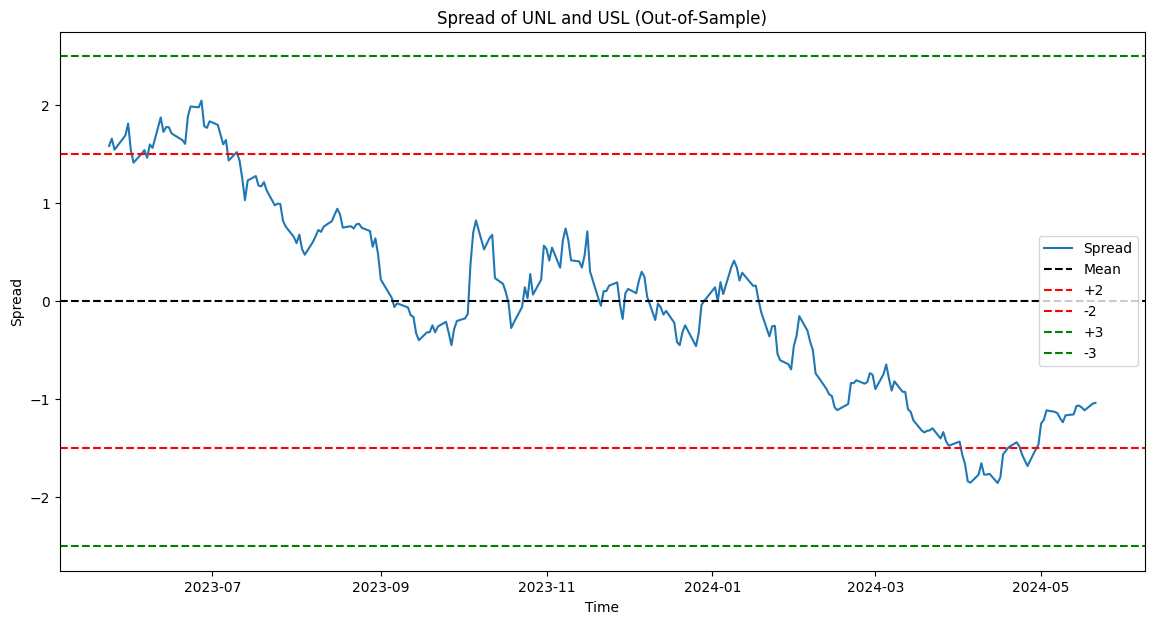

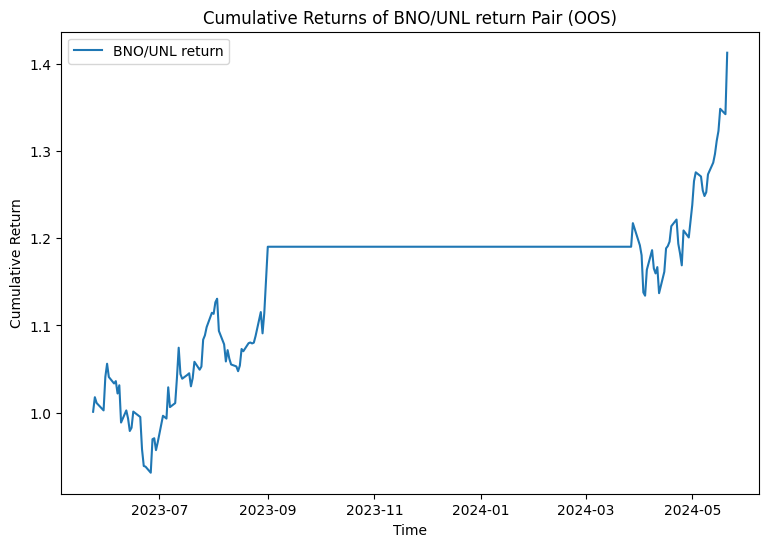

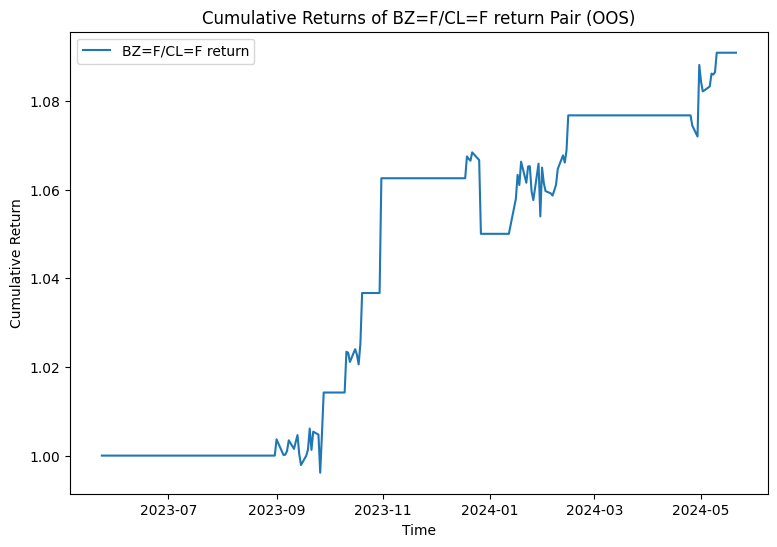

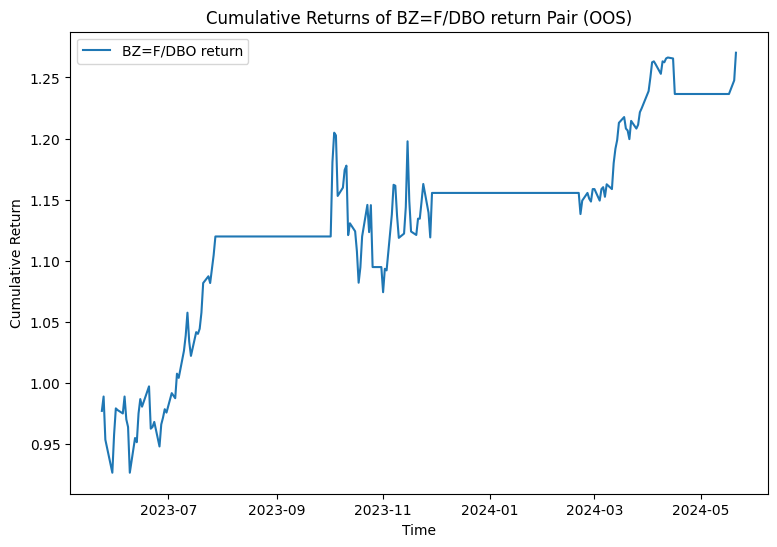

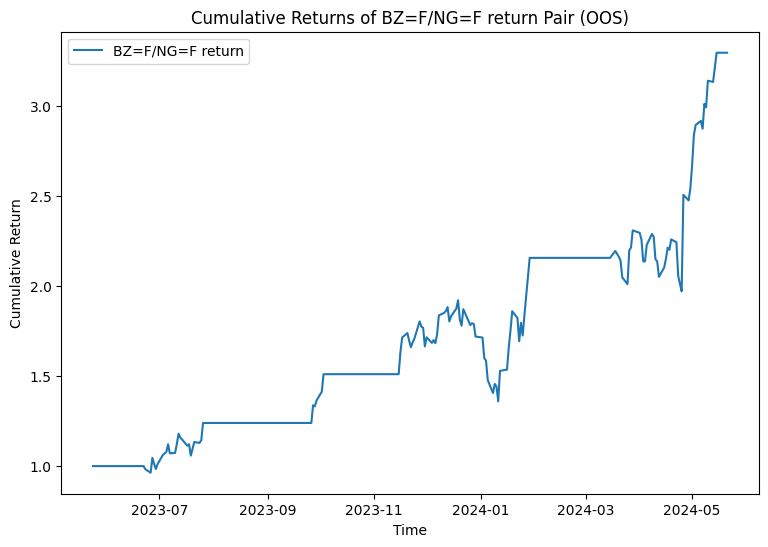

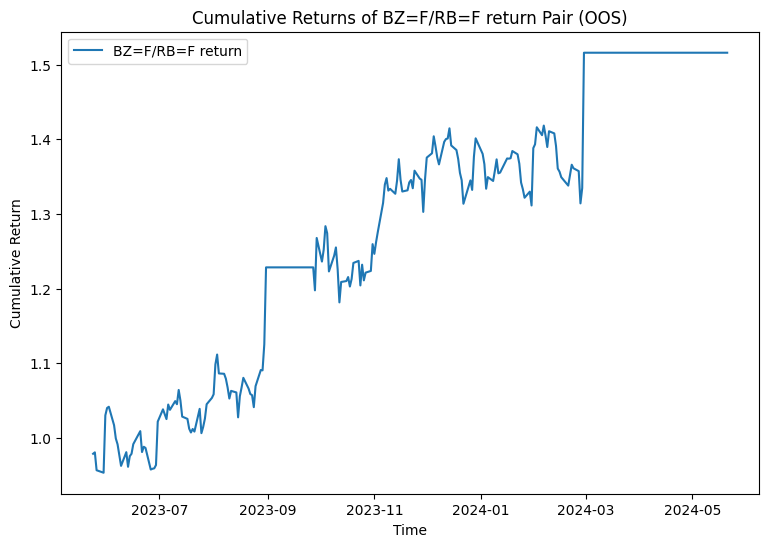

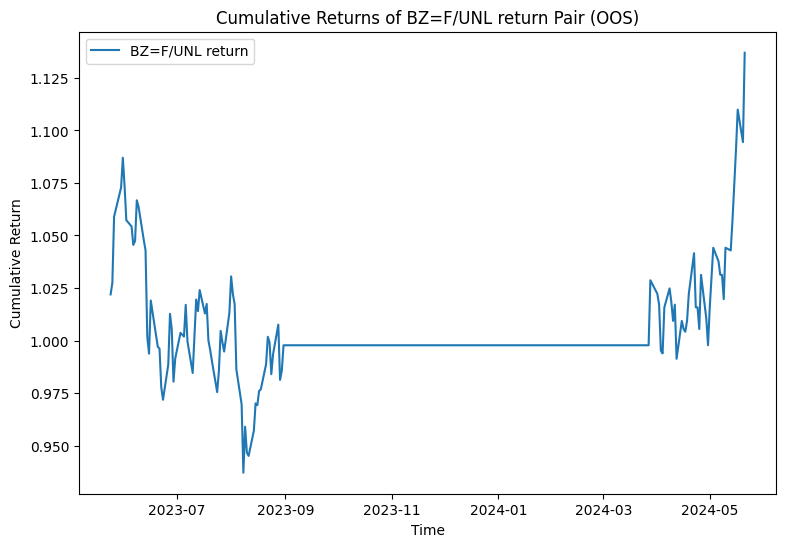

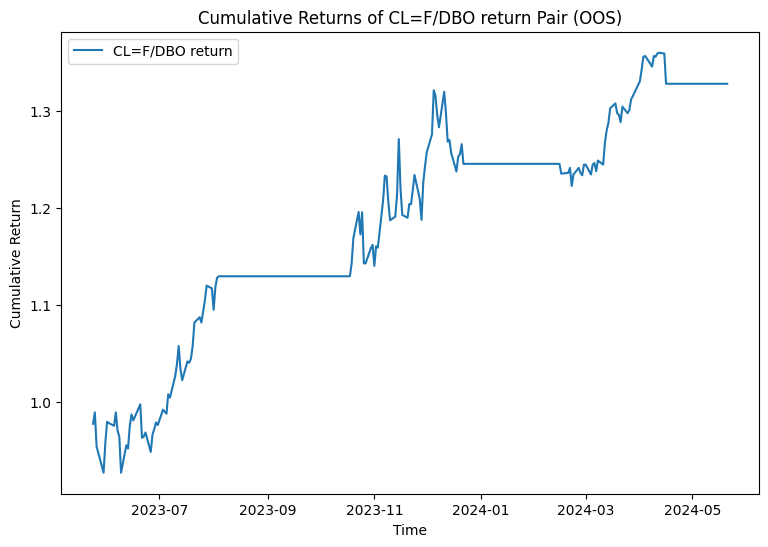

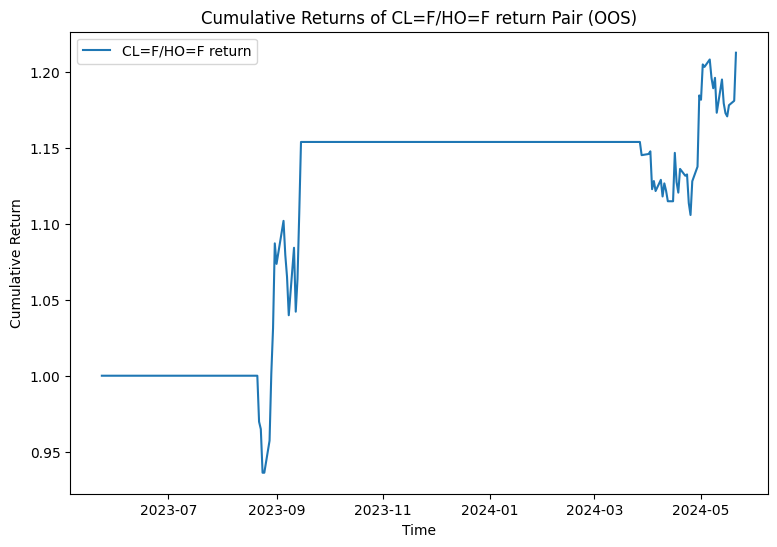

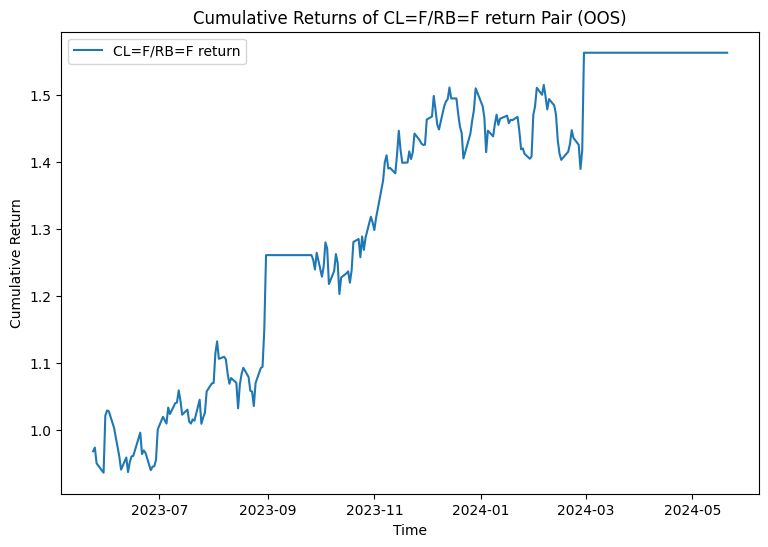

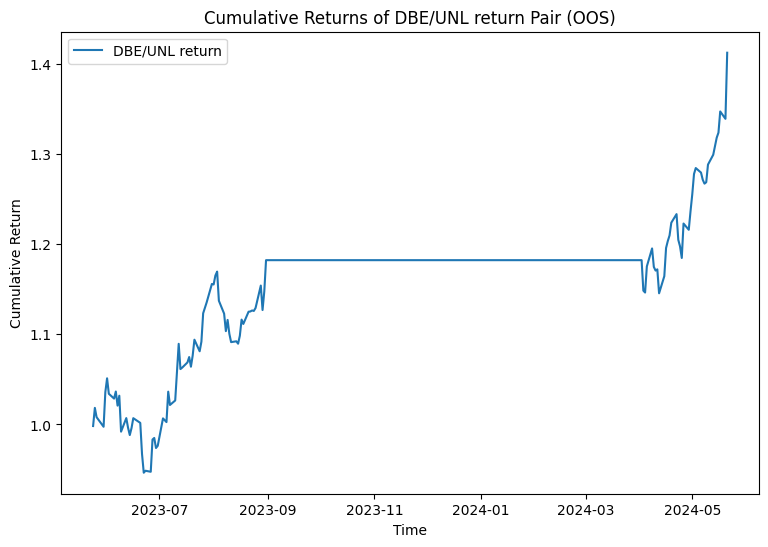

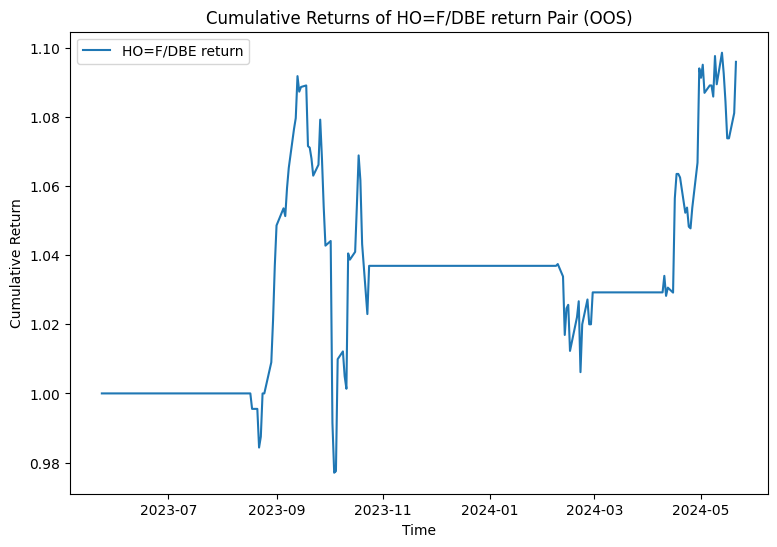

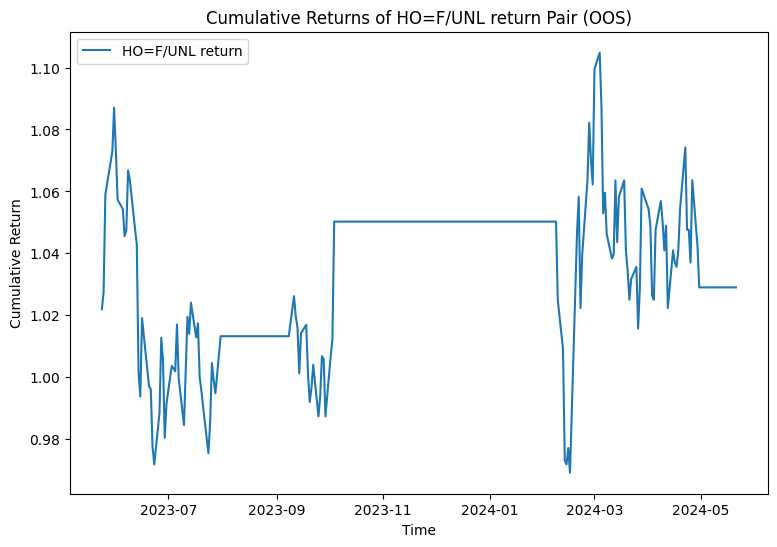

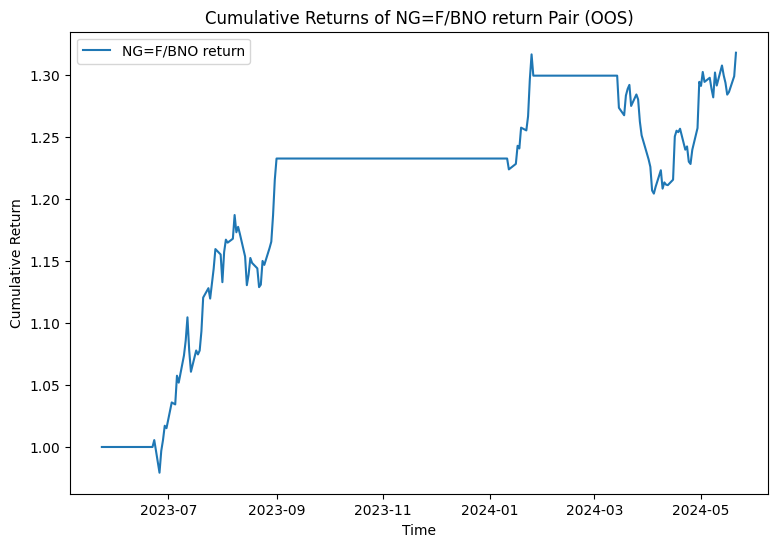

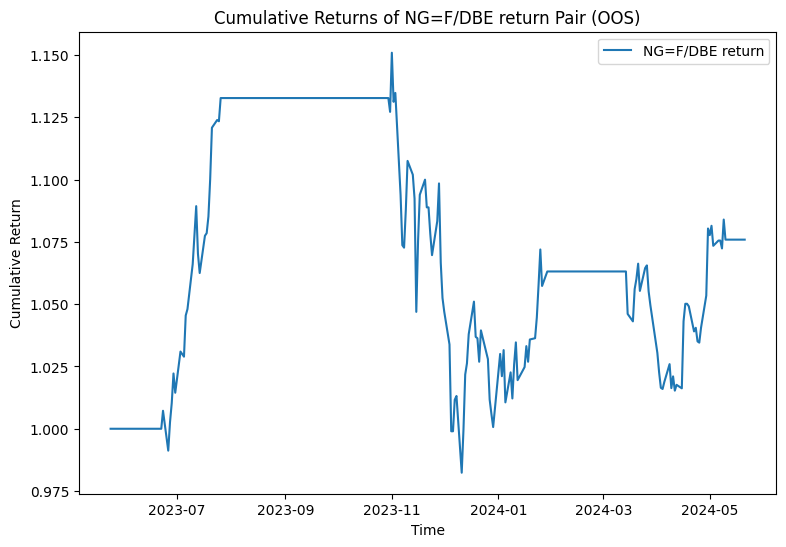

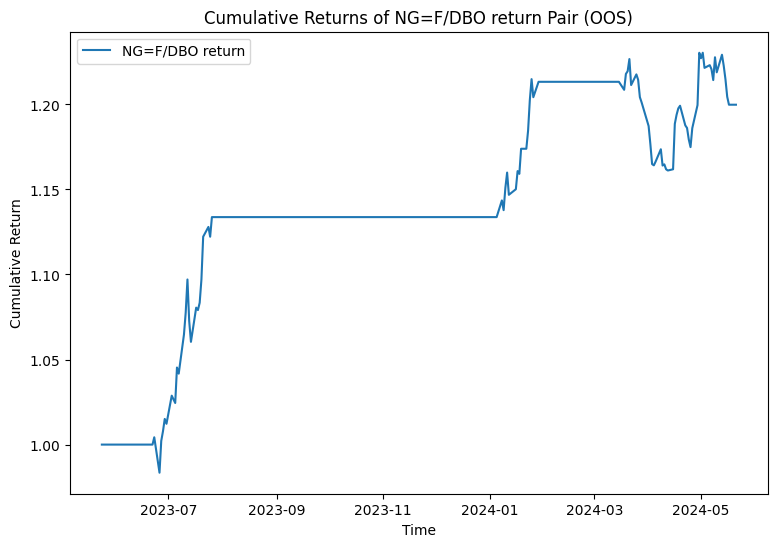

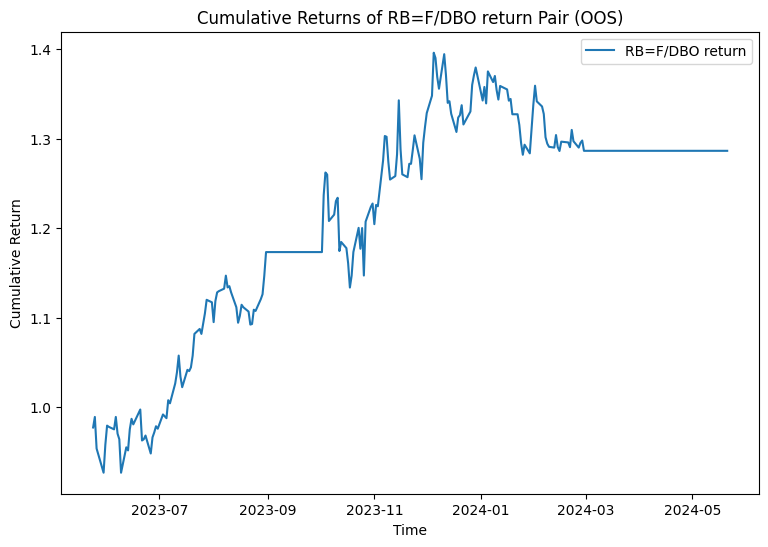

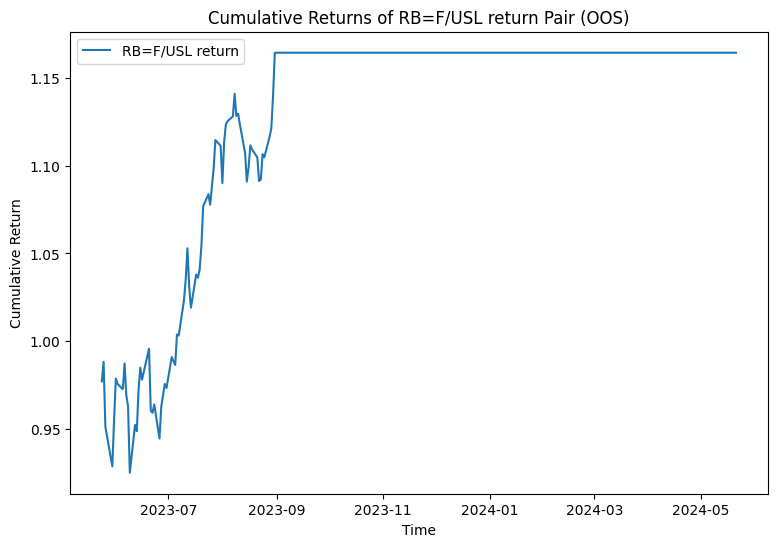

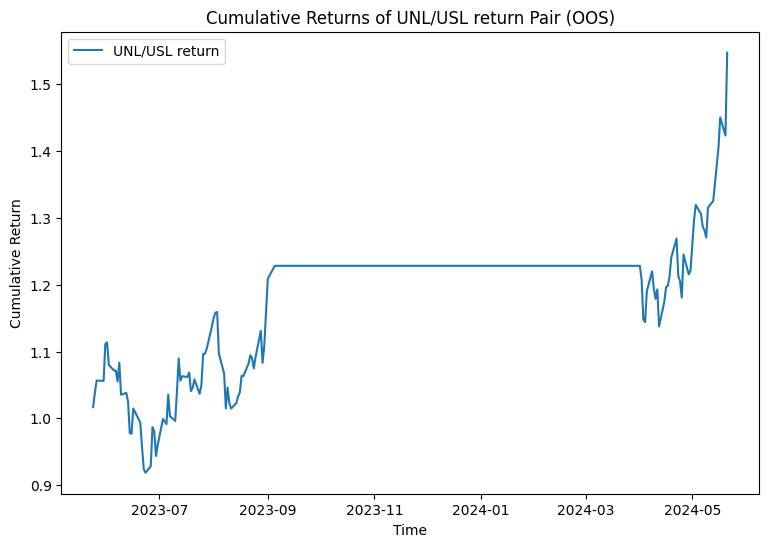

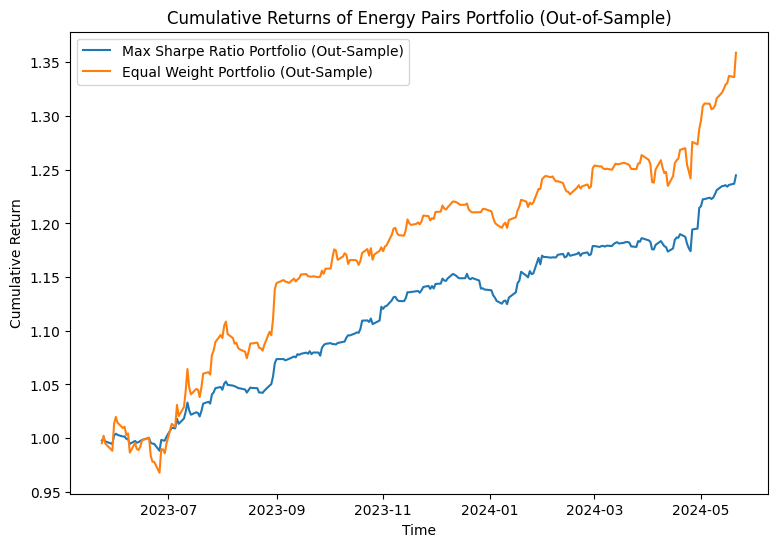


PERFORMANCE STATISTICS FOR Energy Pairs MAX SHARPE
Daily annualized sharpe: 4.0170239126754295
Average annual returns: 22.14830017541642%
Total returns: 22.060410095355245%
Max drawdown: -2.4766646164266937%

PERFORMANCE STATISTICS FOR Energy Pairs EQUAL WEIGHTS
Daily annualized sharpe: 3.1127285742215354
Average annual returns: 31.319116951162577%
Total returns: 31.194834741038918%
Max drawdown: -5.1867457838382185%


In [62]:
os_returns_sharpe, os_returns_equal = backtest_os(energy_data_is, energy_data_os, 1.5, 2.5, 'Energy Pairs')


PERFORMANCE STATISTICS FOR In-sample Max Sharpe allocation
Daily annualized sharpe: 2.1215267955854493
Average annual returns: 26.83127337421264%
Total returns: 107.11214688276951%
Max drawdown: -9.692723498083119%


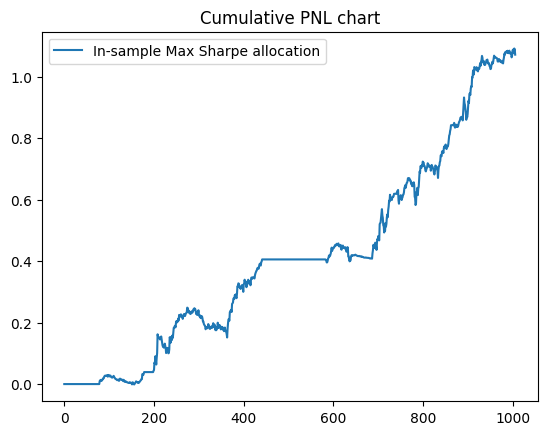

In [66]:
def pnlPerformance(pnl, label):
    cumpnl = pnl.cumsum(skipna = True)
    import matplotlib.pyplot as plt
    import numpy as np
    sharpe = pnl.mean()/np.std(pnl)
    sharpe = sharpe*np.sqrt(252)
    print("")
    print ("PERFORMANCE STATISTICS FOR "+label);
    print("Daily annualized sharpe: "+str(sharpe))
    print ("Average annual returns: "+str(pnl.mean()*252*100)+"%")
    print ("Total returns: "+str(pnl.sum()*100)+"%");
    highwatermark_df = cumpnl.cummax();
    drawdown_df = cumpnl - highwatermark_df;
    maxdrawdown = drawdown_df.min();
    print ("Max drawdown: "+str(maxdrawdown*100)+"%");
    plt.plot(cumpnl.values, label = label);
    plt.legend();
    plt.title("Cumulative PNL chart")

pnlPerformance(is_returns_sharpe, 'In-sample Max Sharpe allocation')